# Importar librerias

In [29]:
import chardet
import pandas as pd
import nltk
import re
import numpy as np
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from fuzzywuzzy import process, fuzz

c:\Users\esteb\AppData\Local\Programs\Python\Python38\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Lectura de los datos

In [2]:
# Abre el archivo en modo binario para detectar su encoding
with open('../data/Online_Retail.csv', 'rb') as file:
    raw_data = file.read()
    result = chardet.detect(raw_data)
    encoding = result['encoding']
    print(f"El encoding detectado es: {encoding}")

El encoding detectado es: ISO-8859-1


In [48]:
# Lectura del dataset 
df_online_retail = pd.read_csv('../data/Online_Retail.csv', encoding=encoding)
df_online_retail.head()

,INVOICE_NO,STOCK_CODE,DESCRIPTION,QUANTITY,INVOICE_DATE,UNIT_PRICE,CUSTOMER_ID,REGION
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2019 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2019 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2019 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2019 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2019 08:26,3.39,17850.0,United Kingdom


In [49]:
# Descripción detallada
df_online_retail.describe(include='all')

,INVOICE_NO,STOCK_CODE,DESCRIPTION,QUANTITY,INVOICE_DATE,UNIT_PRICE,CUSTOMER_ID,REGION
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900,4070,4214,NaN,23260,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,31/10/2020 14:41,NaN,NaN,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,16791.000000,NaN


In [50]:
# Verificar tipos de datos, numero de observaciones, existencia de valores ausentes
df_online_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   INVOICE_NO    541909 non-null  object 
 1   STOCK_CODE    541909 non-null  object 
 2   DESCRIPTION   540455 non-null  object 
 3   QUANTITY      541909 non-null  int64  
 4   INVOICE_DATE  541909 non-null  object 
 5   UNIT_PRICE    541909 non-null  float64
 6   CUSTOMER_ID   406829 non-null  float64
 7   REGION        541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Notas:
- Tenemos 541mil datos. Una cantidad muy grande. 
- Cambiar nombre de columnas a miniusculas
- Columnas con valores ausentes: description, customer_id
    - Encontrar el id a partir de la descripcion? o el stock_code, lo mismo para description
- invoice_no, customer_id a int?
- invoice_date a time
- Por que tenemos números negativos en quantity y unit_price?
- Verificar que no existan valores fantasma en la descripcion y la region
    - Pasar a minusculas y verificar 

# Limpieza de los datos

## Formato al nombre de las columnas

In [51]:
# Pasar el nombre de las columnas a mínusculas y dejarlo en snake_case
df_online_retail.columns = df_online_retail.columns.str.lower()
df_online_retail.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'region'],
      dtype='object')

## Eliminar valores ausentes

In [52]:
# Calcular el porcentaje de valores ausentes por columna
df_online_retail.isna().sum()/len(df_online_retail)*100

invoice_no       0.000000
stock_code       0.000000
description      0.268311
quantity         0.000000
invoice_date     0.000000
unit_price       0.000000
customer_id     24.926694
region           0.000000
dtype: float64

Se optara por dos soluciones para las columnas de valores ausentes:
- desciption: Al solo contar con 0.2% de los datos como valores ausentes se eliminaran. Tenemos suficientes datos para hacer un analisis completo (500mil datos).
- customer_id: Hay un alto porcentaje de valores ausentes, 24% es inusual. Al no contar con una fuente para completar los datos y ser el porcentaje de valores ausentes muy alto, se decidio por remplazarlos por la palabra 'unknown'.

In [53]:
# Tratamiento de valores ausentes
df_online_retail_cleaned = df_online_retail.copy()
df_online_retail_cleaned = df_online_retail_cleaned.dropna(subset=['description'])   # Para la columna descripcion se elimininaran al ser solo el 0.2% de los datos. 
df_online_retail_cleaned = df_online_retail_cleaned.fillna('unknown')                # Para la columna customer_id se reemplazaran por la palabra unknown

In [54]:
# Verificar que no existan valores ausentes
df_online_retail_cleaned.isna().sum()/len(df_online_retail)*100

invoice_no      0.0
stock_code      0.0
description     0.0
quantity        0.0
invoice_date    0.0
unit_price      0.0
customer_id     0.0
region          0.0
dtype: float64

## Eliminar cadenas vacías de description

In [55]:
# Eliminar caracteres especiales usando una expresión regular
df_online_retail_cleaned['description'] = df_online_retail_cleaned['description'].str.replace(r'[^A-Za-z0-9\s]', '', regex=True)

# Limpiar la columna 'description' eliminando espacios en blanco y convirtiendo None a cadenas vacías
df_online_retail_cleaned['description'] = df_online_retail_cleaned['description'].str.strip()

# Encontrar cadenas vacías
empty_strings = df_online_retail_cleaned[df_online_retail_cleaned['description'] == '']
empty_strings.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
7313,537032,21275,,-30,03/12/2019 16:50,0.0,unknown,United Kingdom
21518,538090,20956,,-723,09/12/2019 14:48,0.0,unknown,United Kingdom
38261,539494,21479,,752,20/12/2019 10:36,0.0,unknown,United Kingdom
43662,540100,22837,,-106,04/01/2020 16:53,0.0,unknown,United Kingdom
50806,540558,21258,,-29,10/01/2020 10:04,0.0,unknown,United Kingdom


In [56]:
# Remplazar cadenas vacias por unknown
df_online_retail_cleaned = df_online_retail_cleaned.replace('','unknown')

# Encontrar cadenas vacías
empty_strings = df_online_retail_cleaned[df_online_retail_cleaned['description'] == '']
empty_strings.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region


## Cambiar los tipos de datos

In [57]:
# Pasar la columna invoice_date a tipo datetime
df_online_retail_cleaned['invoice_date'] = pd.to_datetime(df_online_retail_cleaned['invoice_date'])

# Verificar el cambio
df_online_retail_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 540455 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    540455 non-null  object        
 1   stock_code    540455 non-null  object        
 2   description   540455 non-null  object        
 3   quantity      540455 non-null  int64         
 4   invoice_date  540455 non-null  datetime64[ns]
 5   unit_price    540455 non-null  float64       
 6   customer_id   540455 non-null  object        
 7   region        540455 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 37.1+ MB


## Duplicados

## Explicitos

In [58]:
# Cantidad de duplicados
df_online_retail_cleaned.duplicated().sum()

5268

In [59]:
# Ver las observaciones duplicadas
df_online_retail_cleaned[df_online_retail_cleaned.duplicated()]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2019-01-12 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2019-01-12 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2019-01-12 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2019-01-12 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2019-01-12 11:49:00,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2020-09-12 11:34:00,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2020-09-12 11:34:00,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,2020-09-12 11:34:00,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,2020-09-12 11:34:00,2.10,14446.0,United Kingdom


In [60]:
# Tomar una de ellas y compararla con la original
df_online_retail_cleaned[(df_online_retail_cleaned.invoice_no == '536409') & (df_online_retail_cleaned.stock_code == '21866')]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2019-01-12 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2019-01-12 11:45:00,1.25,17908.0,United Kingdom


Nota:
- Si fuese una factura diferentes invoice_no cambiaria...
- Si fuesen dos productos en una factura la cantidad aumentaria...
Por estas dos raones, se eliminaran al considerarse duplicados. 

In [61]:
# Eliminar duplicados explicitos
df_online_retail_cleaned.drop_duplicates(inplace=True)

# Verificar el cambio
df_online_retail_cleaned.duplicated().sum()

0

## Implicitos

### Description

In [62]:
# Función para encontrar posibles errores de tipeo
def find_typo_matches(descriptions, threshold=80):
    unique_descriptions = list(set(descriptions))
    typo_matches = {}
    for desc in unique_descriptions:
        matches = process.extract(desc, unique_descriptions, scorer=fuzz.ratio)
        for match in matches:
            if match[0] != desc and match[1] >= threshold:
                if desc not in typo_matches:
                    typo_matches[desc] = []
                typo_matches[desc].append(match)
    return typo_matches

In [63]:
# Encontrar errores de tipeo en la columna 'description'
typo_matches = find_typo_matches(df_online_retail_cleaned['description'])

In [64]:
# Mostrar los resultados
for key, matches in typo_matches.items():
    print(f"Possible typos for '{key}':")
    for match in matches:
        print(f" - {match[0]} (similarity: {match[1]})")

Possible typos for 'BLACK TEACOFFEESUGAR JARS':
 - WHITE TEACOFFEESUGAR JARS (similarity: 80)
Possible typos for '3D VINTAGE CHRISTMAS STICKERS':
 - 3D TRADITIONAL CHRISTMAS STICKERS (similarity: 81)
 - VINTAGE CHRISTMAS STOCKING (similarity: 80)
Possible typos for 'NATURAL HANGING QUILTED HEARTS':
 - PRETTY HANGING QUILTED HEARTS (similarity: 81)
Possible typos for 'sold as set6 by dotcom':
 - sold as set by dotcom (similarity: 98)
 - sold as set on dotcom (similarity: 88)
Possible typos for 'LE JARDIN BOTANIQUE CUSHION COVER':
 - LA JARDIN BOTANIQUE CUSHION COVER (similarity: 97)
Possible typos for 'BLUE GLASS CHUNKY CHARM BRACELET':
 - WHITE GLASS CHUNKY CHARM BRACELET (similarity: 89)
 - PINK GLASS CHUNKY CHARM BRACELET (similarity: 88)
Possible typos for 'ENAMEL BLUE RIM TEA CONTAINER':
 - ENAMEL BLUE RIM COFFEE CONTAINER (similarity: 89)
 - ENAMEL PINK TEA CONTAINER (similarity: 81)
Possible typos for 'PINK HEART OF GLASS BRACELET':
 - GREEN HEART OF GLASS BRACELET (similarity: 8

- FORKED CACTUS CANDLE (similarity: 82)
Possible typos for 'FRENCH BLUE METAL DOOR SIGN 1':
 - FRENCH BLUE METAL DOOR SIGN 9 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 2 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 0 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 6 (similarity: 97)
Possible typos for 'SINGLE ANTIQUE ROSE HOOK IVORY':
 - MINITURE ANTIQUE ROSE HOOK IVORY (similarity: 87)
 - MINIATURE ANTIQUE ROSE HOOK IVORY (similarity: 86)
Possible typos for 'EMBROIDERED RIBBON REEL EMILY':
 - EMBROIDERED RIBBON REEL DAISY (similarity: 90)
 - EMBROIDERED RIBBON REEL SALLY (similarity: 90)
 - EMBROIDERED RIBBON REEL RACHEL (similarity: 88)
 - EMBROIDERED RIBBON REEL RUBY (similarity: 88)
Possible typos for 'LUNCH BAG PAISLEY PARK':
 - JUMBO BAG PAISLEY PARK (similarity: 82)
Possible typos for 'CHARLOTTE BAG SUKI DESIGN':
 - CHARLOTTE BAG APPLES DESIGN (similarity: 85)
Possible typos for 'ANTIQUE SILVER TEA GLASS ETCHED':
 - ANTIQUE SILVER TEA GLASS ENGRAVED (similarity: 88)
Possible typos for 'MURANO STYLE GLASS BRACELET BLACK':
 - MURANO STYLE GLASS BRACELET GOLD (similarity: 89)
 - MURANO STYLE GLASS BRACELET RED (similarity: 88)
Possible typos for 'FRENCH FLORAL CUSHION COVER':
 - GREEN CAT FLORAL CUSHION COVER (similarity: 88)
 - FRENCH LATTICE CUSHION COVER (similarity: 84)
 - PINK CAT FLORAL CUSHION COVER (similarity: 82)
 - FRENCH PAISLEY CUSHION COVER (similarity: 80)
Possible typos for 'AMBER DROP EARRINGS W LONG BEADS':
 - AMETHYST DROP EARRINGS W LONG BEADS (similarity: 90)
 - BLACK DROP EARRINGS W LONG BEADS (similarity: 88)
 - GOLDAMBER DROP EARRINGS W LEAF (similarity: 81)
Possible typos for 'EMBROIDERED RIBBON REEL SOPHIE':
 - EMBROIDERED RIBBON REEL SUSIE (similarity: 92)
 - EMBROIDERED RIBBON REEL ROSIE (similarity: 92)
 - EMBROIDERED RIBBON REEL RACHEL (similarity: 87)
 - EMBROIDERED RIBBON REEL CLAIRE (similarity: 87)
Possible typos for 'LETTER L BLING KEY RING':
 - LETTER F BLING KEY RING (similarity: 96)
 - LETTER D BLING KEY RING (similarity: 96)
 - LETTER Z BLING KEY RING (similarity: 96)
 - LETTER R BLING KEY RING (similarity: 96)
Possible typos for 'TRIPLE WIRE HOOK IVORY HEART':
 - SINGLE WIRE HOOK IVORY HEART (similarity: 89)
 - TRIPLE WIRE HOOK PINK HEART (similarity: 87)
Possible typos for 'IVORY GIANT GARDEN THERMOMETER':
 - GREEN GIANT GARDEN THERMOMETER (similarity: 87)
 - YELLOW GIANT GARDEN THERMOMETER (similarity: 85)
 - BLUE GIANT GARDEN THERMOMETER (similarity: 85)
Possible typos for 'VINTAGE GLASS COFFEE CADDY':
 - VINTAGE GLASS TEA CADDY (similarity: 86)
Possible typos for 'LARGE BLACK DIAMANTE HAIRSLIDE':
 - LARGE MINT DIAMANTE HAIRSLIDE (similarity: 85)
 - LARGE CRYSTAL DIAMANTE HAIRSLIDE (similarity: 84)
Possible typos for 'PINK JEWELLED PHOTO FRAME':
 - PINK SMALL JEWELLED PHOTOFRAME (similarity: 87)
 - PINK LARGE JEWELED PHOTOFRAME (similarity: 85)
Possible typos for 'ANTIQUE OLIVE GREEN FLOWER EARRINGS':
 - ANTIQUE OPAL WHITE FLOWER EARRINGS (similarity: 81)
Possible typos for 'ADULT APRON APPLE DELIGHT':
 - APRON APPLE DELIGHT (similarity: 86)
Possible typos for 'CARD CHRISTMAS VILLAGE':
 - WRAP CHRISTMAS VILLAGE (similarity: 86)
 - DOORMAT CHRISTMAS VILLAGE (similarity: 81)
Possible typos for 'RED FLOWER CROCHET FOOD COVER':
 - PINK FLOWER CROCHET FOOD COVER (similarity: 88)
Possible typos for 'BISCUIT TIN VINTAGE GREEN':
 - BISCUIT TIN VINTAGE RED (similarity: 92)
 - BISCUIT TIN VINTAGE LEAF (similarity: 86)
Possible typos for 'SMALL POP BOX FUNKY MONKEY':
 - SMALL POP BOXFUNKY MONKEY (similarity: 98)
Possible typos for 'BLUE POLKADOT BEAKER':
 - RED POLKADOT BEAKER (similarity: 87)
Possible typos for 'WOODLAND LARGE BLUE FELT HEART':
 - WOODLAND LARGE RED FELT HEART (similarity: 92)
 - WOODLAND SMALL BLUE FELT HEART (similarity: 87)
 - WOODLAND LARGE PINK FELT HEART (similarity: 87)
Possible typos for 'CHILDRENS CUTLERY POLKADOT GREEN':
 - CHILDRENS CUTLERY POLKADOT BLUE (similarity: 89)
 - CHILDRENS CUTLERY POLKADOT PINK (similarity: 89)
Possible typos for 'BLACK SMALL GLASS CAKE STAND':
 - PINK SMALL GLASS CAKE STAND (similarity: 87)
 - BLACK MEDIUM GLASS CAKE STAND (similarity: 84)
Possible typos for 'PINK HAPPY BIRTHDAY BUNTING':
 - BLUE HAPPY BIRTHDAY BUNTING (similarity: 85)
Possible typos for 'JAM JAR WITH GREEN LID':
 - JAM JAR WITH PINK LID (similarity: 84)
 - JAM JAR WITH BLUE LID (similarity: 84)
Possible typos for '12 PENCIL SMALL TUBE WOODLAND':
 - 12 PENCILS TALL TUBE WOODLAND (similarity: 93)
 - 36 PENCILS TUBE WOODLAND (similarity: 83)
Possible typos for 'SILVER BOOK MARK WITH BEADS':
 - ANTIQUE SILVER BOOK MARK WITH BEADS (similarity: 87)
Possible typos for 'TUSCAN VILLA DOVECOTE BIRD FEEDER':
 - TUSCAN VILLA BIRD FEEDER (similarity: 84)
Possible typos for 'MINI LADLE LOVE HEART PINK':
 - LADLE LOVE HEART PINK (similarity: 89)
 - MINI LADLE LOVE HEART RED (similarity: 86)
Possible typos for 'GLITTER STAR GARLAND WITH BELLS':
 - GLITTER HEART GARLAND WITH BELLS (similarity: 92)
Possible typos for 'FAIRY CAKES NOTEBOOK A6 SIZE':
 - FAIRY CAKES NOTEBOOK A7 SIZE (similarity: 96)
 - FAIRY CAKE NOTEBOOK A5 SIZE (similarity: 95)
Possible typos for 'PACK OF 12 PINK POLKADOT TISSUES':
 - PACK OF 12 PINK PAISLEY TISSUES (similarity: 83)
Possible typos for 'CREAM SWEETHEART LETTER RACK':
 - ZINC WIRE SWEETHEART LETTER TRAY (similarity: 80)
 - CREAM SWEETHEART TRAYS (similarity: 80)
 - ZINC SWEETHEART WIRE LETTER RACK (similarity: 80)
Possible typos for 'RETRO PLASTIC 70S TRAY':
 - RETRO PLASTIC DAISY TRAY (similarity: 87)
 - RETRO PLASTIC POLKA TRAY (similarity: 83)
Possible typos for 'BLUE NEW BAROQUE FLOCK CANDLESTICK':
 - PINK NEW BAROQUE FLOCK CANDLESTICK (similarity: 88)
 - BLUE NEW BAROQUE CANDLESTICK CANDLE (similarity: 81)
Possible typos for '3 TIER CAKE TIN RED AND CREAM':
 - 3 TIER CAKE TIN GREEN AND CREAM (similarity: 93)
Possible typos for 'STAR PORTABLE TABLE LIGHT':
 - SNOWFLAKE PORTABLE TABLE LIGHT (similarity: 84)
Possible typos for 'WOODEN TREE CHRISTMAS SCANDINAVIAN':
 - WOODEN STAR CHRISTMAS SCANDINAVIAN (similarity: 94)
 - WOODEN HEART CHRISTMAS SCANDINAVIAN (similarity: 90)
Possible typos for 'SET6 TURQUOISE BUTTERFLY TLIGHTS':
 - SET6 PURPLE BUTTERFLY TLIGHTS (similarity: 85)
 - SET6 PINK  BUTTERFLY TLIGHTS (similarity: 80)
Possible typos for 'OCEAN SCENT CANDLE JEWELLED DRAWER':
 - ROSE SCENT CANDLE JEWELLED DRAWER (similarity: 93)
 - OCEAN SCENT CANDLE IN JEWELLED BOX (similarity: 82)
Possible typos for 'BLACK MEDIUM GLASS CAKE STAND':
 - BLACK SMALL GLASS CAKE STAND (similarity: 84)
Possible typos for 'NUMBER TILE COTTAGE GARDEN 2':
 - NUMBER TILE COTTAGE GARDEN 8 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 9 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 7 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 5 (similarity: 96)
Possible typos for 'PINK FEATHERS CURTAIN':
 - LILAC FEATHERS CURTAIN (similarity: 84)
Possible typos for 'GREEN GIANT GARDEN THERMOMETER':
 - BLUE GIANT GARDEN THERMOMETER (similarity: 88)
 - IVORY GIANT GARDEN THERMOMETER (similarity: 87)
 - YELLOW GIANT GARDEN THERMOMETER (similarity: 85)
Possible typos for 'WOODLAND SMALL PINK FELT HEART':
 - WOODLAND SMALL RED FELT HEART (similarity: 88)
 - WOODLAND SMALL BLUE FELT HEART (similarity: 87)
 - WOODLAND LARGE PINK FELT HEART (similarity: 87)
Possible typos for 'PINK FELT EASTER EGG BASKET':
 - BLUE FELT EASTER EGG BASKET (similarity: 85)
 - PINK BUNNY EASTER EGG BASKET (similarity: 84)
 - CREAM FELT EASTER EGG BASKET (similarity: 84)
Possible typos for '5 STRAND GLASS NECKLACE CRYSTAL':
 - 5 STRAND GLASS NECKLACE AMETHYST (similarity: 86)
 - 5 STRAND GLASS NECKLACE AMBER (similarity: 83)
 - 5 STRAND GLASS NECKLACE BLACK (similarity: 83)
Possible typos for 'wrongly coded 23343':
 - wrongly coded23343 (similarity: 97)
 - wrongly coded 20713 (similarity: 84)
 - wrongly marked 23343 (similarity: 82)
Possible typos for 'HEART WOODEN CHRISTMAS DECORATION':
 - STAR WOODEN CHRISTMAS DECORATION (similarity: 92)
 - SWALLOW WOODEN CHRISTMAS DECORATION (similarity: 85)
 - PARTY CONE CHRISTMAS DECORATION (similarity: 84)
Possible typos for 'PACK OF 12 RED RETROSPOT TISSUES':
 - PACK OF 12 RED APPLE TISSUES (similarity: 80)
Possible typos for 'PACK OF 12 LONDON TISSUES':
 - PACK OF 12 WOODLAND TISSUES (similarity: 85)
 - PACK OF 12 DOILEY TISSUES (similarity: 84)
 - PACK OF 12 SKULL TISSUES (similarity: 82)
Possible typos for 'PURPLE CHUNKY GLASSBEAD NECKLACE':
 - AMBER CHUNKY GLASSBEAD NECKLACE (similarity: 86)
Possible typos for '16 PIECE CUTLERY SET PANTRY DESIGN':
 - 16 PC CUTLERY SET PANTRY DESIGN (similarity: 95)
Possible typos for 'SWEETHEART WALL TIDY':
 - SWEETHEART WIRE WALL TIDY (similarity: 89)
Possible typos for 'RETROSPOT HEART HOT WATER BOTTLE':
 - GREY HEART HOT WATER BOTTLE (similarity: 85)
Possible typos for 'SET 12 KIDS  WHITE CHALK STICKS':
 - SET 12 RETRO WHITE CHALK STICKS (similarity: 84)
 - SET 12 KIDS COLOUR  CHALK STICKS (similarity: 83)
Possible typos for 'PINKGREEN FLOWER DESIGN BIG MUG':
 - GREENBLUE FLOWER DESIGN BIG MUG (similarity: 87)
 - YELLOWPINK FLOWER DESIGN BIG MUG (similarity: 83)
Possible typos for 'SMALL DECO JEWELLERY STAND':
 - SMALL JEWELLERY STAND (similarity: 89)
 - LARGE DECO JEWELLERY STAND (similarity: 85)
Possible typos for '4 IVORY DINNER CANDLES SILVER FLOCK':
 - 4 PINK DINNER CANDLE SILVER FLOCK (similarity: 88)
 - 4 BLUE DINNER CANDLES SILVER FLOCK (similarity: 87)
 - IVORY PILLAR CANDLE SILVER FLOCK (similarity: 84)
Possible typos for 'HANGING METAL RABBIT DECORATION':
 - HANGING METAL CHICKEN DECORATION (similarity: 83)
Possible typos for 'SMALL WHITE RETROSPOT MUG IN BOX':
 - SMALL RED RETROSPOT MUG IN BOX (similarity: 90)
Possible typos for 'BLUE FELT EASTER EGG BASKET':
 - CREAM FELT EASTER EGG BASKET (similarity: 87)
 - PINK FELT EASTER EGG BASKET (similarity: 85)
 - BLUE BUNNY EASTER EGG BASKET (similarity: 84)
Possible typos for 'RESIN NECKLACE W PASTEL BEADS':
 - RESIN BRACELET W PASTEL BEADS (similarity: 83)
 - LAZER CUT NECKLACE W PASTEL BEADS (similarity: 81)
Possible typos for 'SKULLS AND CROSSBONES WRAP':
 - SKULL AND CROSSBONES  GARLAND (similarity: 84)
Possible typos for 'BLUE DISCO HANDBAG':
 - SILVER DISCO HANDBAG (similarity: 84)
Possible typos for 'SET OF 3 HEART COOKIE CUTTERS':
 - SET OF 3 BUTTERFLY COOKIE CUTTERS (similarity: 84)
Possible typos for 'ANTIQUE OPAL WHITE FLOWER EARRINGS':
 - ANTIQUE OLIVE GREEN FLOWER EARRINGS (similarity: 81)
Possible typos for 'MIRRORED WALL ART PHOTO FRAMES':
 - MIRRORED WALL ART POPPIES (similarity: 80)
Possible typos for 'BLACK FINE BEAD NECKLACE W TASSEL':
 - AMBER FINE BEAD NECKLACE W TASSEL (similarity: 88)
 - PURPLE FINE BEAD NECKLACE W TASSEL (similarity: 87)
 - BLACKWHITE NECKLACE W TASSEL (similarity: 82)
Possible typos for 'PEACE SMALL WOOD LETTERS':
 - HOME SMALL WOOD LETTERS (similarity: 85)
Possible typos for 'CRYSTAL CZECH CROSS PHONE CHARM':
 - CRYSTAL FROG PHONE CHARM (similarity: 80)
 - CRYSTAL SEA HORSE PHONE CHARM (similarity: 80)
Possible typos for 'HANGING SPRING FLOWER EGG SMALL':
 - HANGING SPRING FLOWER EGG LARGE (similarity: 87)
Possible typos for 'PINKWHITE CHRISTMAS TREE 60CM':
 - PINKWHITE CHRISTMAS TREE 30CM (similarity: 97)
 - WHITE CHRISTMAS TREE 60CM (similarity: 93)
 - PINK AND WHITE CHRISTMAS TREE 120CM (similarity: 88)
 - DUSTY PINK CHRISTMAS TREE 60CM (similarity: 81)
Possible typos for 'WOVEN ROSE GARDEN CUSHION COVER':
 - WOVEN FROST CUSHION COVER (similarity: 82)
Possible typos for 'LUNCH BAG SPACEBOY DESIGN':
 - JUMBO BAG SPACEBOY DESIGN (similarity: 84)
 - LUNCH BAG APPLE DESIGN (similarity: 81)
 - LUNCH BAG ALPHABET DESIGN (similarity: 80)
Possible typos for 'VICTORIAN SEWING BOX MEDIUM':
 - VICTORIAN SEWING BOX SMALL (similarity: 83)
 - VICTORIAN SEWING BOX LARGE (similarity: 83)
Possible typos for 'BLUE PAINTED KASHMIRI CHAIR':
 - PINK PAINTED KASHMIRI CHAIR (similarity: 85)
Possible typos for 'FRENCH GARDEN SIGN BLUE METAL':
 - FRENCH LAUNDRY SIGN BLUE METAL (similarity: 85)
 - FRENCH WC SIGN BLUE METAL (similarity: 85)
 - FRENCH KITCHEN SIGN BLUE METAL (similarity: 85)
 - FRENCH TOILET SIGN BLUE METAL (similarity: 83)
Possible typos for 'HAND WARMER BIRD DESIGN':
 - HAND WARMER OWL DESIGN (similarity: 84)
 - HAND WARMER BABUSHKA DESIGN (similarity: 80)
Possible typos for 'VINTAGE BLUE TINSEL REEL':
 - VINTAGE GOLD TINSEL REEL (similarity: 88)
Possible typos for '12 PENCILS TALL TUBE POSY':
 - 12 PENCILS TALL TUBE SKULLS (similarity: 85)
 - 12 PENCILS TALL TUBE WOODLAND (similarity: 81)
 - 12 PENCILS SMALL TUBE SKULL (similarity: 81)
 - 36 PENCILS TUBE POSY (similarity: 80)
Possible typos for '12 RED ROSE PEG PLACE SETTINGS':
 - 12 IVORY ROSE PEG PLACE SETTINGS (similarity: 90)
 - 12 PINK ROSE PEG PLACE SETTINGS (similarity: 89)
Possible typos for 'MOP PENDANT SHELL NECKLACE':
 - GREEN PENDANT SHELL NECKLACE (similarity: 85)
 - ROSE PENDANT TRIPLE SHELL NECKLACE (similarity: 80)
Possible typos for 'PARTY PIZZA DISH PINK POLKADOT':
 - PARTY PIZZA DISH GREEN POLKADOT (similarity: 89)
 - PARTY PIZZA DISH BLUE POLKADOT (similarity: 87)
Possible typos for 'CREAM CLIMBING HYDRANGA ART FLOWER':
 - BLUE CLIMBING HYDRANGA ART FLOWER (similarity: 90)
Possible typos for 'FOLDING UMBRELLA PINKWHITE POLKADOT':
 - FOLDING UMBRELLA REDWHITE POLKADOT (similarity: 90)
 - FOLDING UMBRELLA WHITERED POLKADOT (similarity: 90)
 - FOLDING UMBRELLA CHOCOLATE POLKADOT (similarity: 83)
 - FOLDING UMBRELLA CREAM POLKADOT (similarity: 82)
Possible typos for 'DRAWER KNOB VINTAGE GLASS BALL':
 - DRAWER KNOB VINTAGE GLASS STAR (similarity: 90)
 - DRAWER KNOB VINTAGE GLASS HEXAGON (similarity: 86)
Possible typos for 'YELLOW PINK FLOWER DESIGN BIG BOWL':
 - YELLOWPINK FLOWER DESIGN BIG MUG (similarity: 88)
Possible typos for 'COSY HOUR CIGAR BOX MATCHES':
 - COSY HOUR GIANT TUBE MATCHES (similarity: 80)
Possible typos for 'ENAMEL BOWL PANTRY':
 - ENAMEL JUG PANTRY (similarity: 80)
 - ENAMEL MUG PANTRY (similarity: 80)
Possible typos for 'GREY FLORAL FELTCRAFT SHOULDER BAG':
 - RED FLORAL FELTCRAFT SHOULDER BAG (similarity: 96)
 - PINK FLORAL FELTCRAFT SHOULDER BAG (similarity: 88)
Possible typos for 'WHITE VINT ART DECO CRYSTAL NECKLAC':
 - BLACK VINT ART DEC CRYSTAL NECKLACE (similarity: 83)
Possible typos for 'BLUEGREEN SHELL NECKLACE W PENDANT':
 - BLUENAT SHELL NECKLACE W PENDANT (similarity: 91)
 - SILVERNAT SHELL NECKLACE W PENDANT (similarity: 85)
Possible typos for 'GREEN VINTAGE SPOT BEAKER':
 - RED VINTAGE SPOT BEAKER (similarity: 92)
 - PINK VINTAGE SPOT BEAKER (similarity: 86)
 - BLUE VINTAGE SPOT BEAKER (similarity: 86)
Possible typos for 'ASSORTED COLOUR SUCTION CUP HOOK':
 - ASSORTED MONKEY SUCTION CUP HOOK (similarity: 84)
 - ASSORTED COLOUR LIZARD SUCTION HOOK (similarity: 84)
Possible typos for 'BAKING MOULD CUPCAKE CHOCOLATE':
 - BAKING MOULD TOFFEE CUP CHOCOLATE (similarity: 83)
 - BAKING MOULD TOFFEE CUP  CHOCOLATE (similarity: 81)
Possible typos for 'SKULLS GREETING CARD':
 - SWALLOWS GREETING CARD (similarity: 86)
Possible typos for 'SILVER APERITIF GLASS':
 - GOLD APERITIF GLASS (similarity: 80)
Possible typos for 'SET 10 CARDS DINKY TREE 17076':
 - SET 10 CARDS WISHING TREE 17116 (similarity: 80)
 - SET 10 CARDS MAGICAL TREE 17086 (similarity: 80)
Possible typos for 'PINKFLOWER RABBIT EGG WARMER':
 - PINK FLOWERS RABBIT EASTER (similarity: 81)
Possible typos for 'CANDY SPOT EGG WARMER RABBIT':
 - CANDY SPOT EGG WARMER HARE (similarity: 85)
Possible typos for 'AMETHYST HOOP EARRING FLORAL LEAF':
 - CRYSTAL HOOP EARRING FLORAL LEAF (similarity: 86)
Possible typos for 'WINE BOTTLE DRESSING DARK BLUE':
 - WINE BOTTLE DRESSING LTBLUE (similarity: 88)
Possible typos for 'GREEN SQUARE COMPACT MIRROR':
 - BLUE SQUARE COMPACT MIRROR (similarity: 87)
 - GREEN HEART COMPACT MIRROR (similarity: 87)
 - GREEN ROUND COMPACT MIRROR (similarity: 83)
Possible typos for 'DRAWER KNOB CERAMIC BLACK':
 - DRAWER KNOB CERAMIC RED (similarity: 83)
 - DRAWER KNOB CERAMIC IVORY (similarity: 80)
Possible typos for 'RED RETROSPOT PUDDING BOWL':
 - RED RETROSPOT BIG BOWL (similarity: 88)
 - RED RETROSPOT BOWL (similarity: 82)
Possible typos for 'PACK OF 12 WOODLAND TISSUES':
 - PACK OF 12 LONDON TISSUES (similarity: 85)
 - PACK OF 12 DOILEY TISSUES (similarity: 81)
Possible typos for 'MIRROR LOVE BIRD TLIGHT HOLDER':
 - CLEAR LOVE BIRD TLIGHT HOLDER (similarity: 85)
 - BLACK LOVE BIRD TLIGHT HOLDER (similarity: 81)
 - MIRROR MOSAIC TLIGHT HOLDER (similarity: 81)
Possible typos for 'PURPLE ACRYLIC FACETED BANGLE':
 - GREY ACRYLIC FACETED BANGLE (similarity: 89)
 - CLEAR ACRYLIC FACETED BANGLE (similarity: 88)
 - RED   ACRYLIC FACETED BANGLE (similarity: 88)
Possible typos for 'CAST IRON HOOK GARDEN FORK':
 - CAST IRON HOOK GARDEN TROWEL (similarity: 85)
Possible typos for 'BEADED CRYSTAL HEART BLUE ON STICK':
 - BEADED CRYSTAL HEART GREEN ON STICK (similarity: 90)
 - BEADED CRYSTAL HEART PINK ON STICK (similarity: 88)
 - BEADED CRYSTAL HEART BLUE SMALL (similarity: 83)
 - BEADED CRYSTAL HEART BLUE  LARGE (similarity: 82)
Possible typos for 'PINK NEW BAROQUE FLOCK CANDLESTICK':
 - BLUE NEW BAROQUE FLOCK CANDLESTICK (similarity: 88)
Possible typos for 'GREEN ENAMELGLASS HAIR COMB':
 - PINK ENAMELGLASS HAIR COMB (similarity: 87)
 - PURPLE ENAMELGLASS HAIR COMB (similarity: 87)
 - JADE GREEN ENAMEL HAIR COMB (similarity: 81)
Possible typos for 'HAND WARMER OWL DESIGN':
 - HAND WARMER BIRD DESIGN (similarity: 84)
Possible typos for 'CHUNKY CRACKED GLAZE NECKLACE IVORY':
 - CRACKED GLAZE NECKLACE IVORY (similarity: 89)
Possible typos for 'GLASS BEAD HOOP EARRINGS BLACK':
 - GLASS BEAD HOOP EARRINGS MONTANA (similarity: 84)
 - GLASS BEAD HOOP EARRINGS GREEN (similarity: 83)
 - GLASS BEAD HOOP EARRINGS AMETHYST (similarity: 83)
 - GLASS BEAD HOOP NECKLACE BLACK (similarity: 80)
Possible typos for 'DECORATIVE FLORE BATHROOM BOTTLE':
 - DECORATIVE ROSE BATHROOM BOTTLE (similarity: 92)
 - DECORATIVE CATS BATHROOM BOTTLE (similarity: 86)
Possible typos for 'METAL SIGN HER DINNER IS SERVED':
 - METAL SIGN HIS DINNER IS SERVED (similarity: 94)
Possible typos for 'GREENBLUE FLOWER DESIGN BIG MUG':
 - PINKGREEN FLOWER DESIGN BIG MUG (similarity: 87)
 - BLUEYELLOW FLOWER DESIGN BIG MUG (similarity: 83)
Possible typos for 'TURQ STONECRYSTAL EARRINGS':
 - RED STONECRYSTAL EARRINGS (similarity: 90)
 - GREEN STONECRYSTAL EARRINGS (similarity: 87)
 - WHITE STONECRYSTAL EARRINGS (similarity: 87)
Possible typos for 'wrongly sold sets':
 - wrongly sold as sets (similarity: 92)
Possible typos for 'VINTAGE BLUE KITCHEN CABINET':
 - VINTAGE RED KITCHEN CABINET (similarity: 91)
Possible typos for 'FLOWER FAIRY5 SUMMER BDRAW LINERS':
 - FLOWER FAIRY 5 SUMMER DRAW LINERS (similarity: 97)
 - FLOWER FAIRY 5 DRAWER LINERS (similarity: 82)
Possible typos for 'GLASS APOTHECARY BOTTLE TONIC':
 - GLASS APOTHECARY BOTTLE ELIXIR (similarity: 85)
 - GLASS APOTHECARY BOTTLE PERFUME (similarity: 80)
Possible typos for 'CUTE BIRD CEATURE SCREEN':
 - CUTE RABBIT CEATURE SCREEN (similarity: 88)
Possible typos for 'WALL ARTONLY ONE PERSON':
 - WALL ART ONLY ONE PERSON (similarity: 98)
Possible typos for 'GLITTER CHRISTMAS TREE WITH BELLS':
 - GLITTER CHRISTMAS TREE (similarity: 80)
Possible typos for 'PACK OF 6 PANNETONE GIFT BOXES':
 - PACK OF 6 PANETTONE GIFT BOXES (similarity: 97)
 - PACK OF 6 SWEETIE GIFT BOXES (similarity: 83)
Possible typos for 'LAUREL STAR ANTIQUE GOLD':
 - LAUREL HEART ANTIQUE GOLD (similarity: 90)
 - LAUREL STAR ANTIQUE SILVER (similarity: 84)
Possible typos for 'BLOSSOM IMAGES GIFT WRAP SET':
 - CURIOUS IMAGES GIFT WRAP SET (similarity: 82)
 - ROMANTIC IMAGES GIFT WRAP SET (similarity: 81)
Possible typos for 'SWALLOW SQUARE TISSUE BOX':
 - SKULLS SQUARE TISSUE BOX (similarity: 86)
Possible typos for 'HAPPY BIRTHDAY CARD TEDDYCAKE':
 - HAPPY BIRTHDAY CARD STRIPEY TEDDY (similarity: 81)
Possible typos for 'SET OF 36 SPACEBOY PAPER DOILIES':
 - SET OF 36 PANTRY PAPER DOILIES (similarity: 87)
 - SET OF 36 TEATIME PAPER DOILIES (similarity: 83)
 - SET OF 36 DINOSAUR PAPER DOILIES (similarity: 81)
 - SET OF 36 MUSHROOM PAPER DOILIES (similarity: 81)
Possible typos for 'LIGHT PINK FLOCK GLASS CANDLEHOLDER':
 - PINK FLOCK GLASS CANDLEHOLDER (similarity: 91)
 - BLUE FLOCK GLASS CANDLEHOLDER (similarity: 81)
Possible typos for 'SET 10 CARDS 12 DAYS WRAP  17058':
 - SET 10 CARDS 12 DAYS OF XMAS 17059 (similarity: 82)
Possible typos for 'GIFT BAG PSYCHEDELIC APPLES':
 - CARD PSYCHEDELIC APPLES (similarity: 80)
Possible typos for 'TINY CRYSTAL BRACELET GREEN':
 - TINY CRYSTAL BRACELET RED (similarity: 92)
 - TINY CRYSTAL BRACELET BLUE (similarity: 87)
Possible typos for 'SET OF 4 NAPKIN CHARMS 3 KEYS':
 - SET OF 4 NAPKIN CHARMS HEARTS (similarity: 86)
 - SET OF 4 NAPKIN CHARMS LEAVES (similarity: 86)
 - SET OF 4 NAPKIN CHARMS CUTLERY (similarity: 85)
 - SET OF 4 NAPKIN CHARMS STARS (similarity: 84)
Possible typos for 'GARDENIA 1 WICK MORRIS BOXED CANDLE':
 - GARDENIA 3 WICK MORRIS BOXED CANDLE (similarity: 97)
 - ROSE 1 WICK MORRIS BOXED CANDLE (similarity: 88)
 - 3 GARDENIA MORRIS BOXED CANDLES (similarity: 85)
 - ROSE 3 WICK MORRIS BOX CANDLE (similarity: 81)
Possible typos for 'FLOWER GLASS GARLD NECKL36AMETHYST':
 - FLOWER GLASS GARLD NECKL36TURQUOIS (similarity: 82)
 - FLOWER GLASS GARLAND NECKL36BLUE (similarity: 82)
 - FLOWER GLASS GARLAND NECKL36GREEN (similarity: 81)
 - FLOWER GLASS GARLAND NECKL36BLACK (similarity: 81)
Possible typos for 'CARD GINGHAM ROSE':
 - WRAP GINGHAM ROSE (similarity: 82)
Possible typos for 'WOODEN ROUNDERS GARDEN SET':
 - WOODEN CROQUET GARDEN SET (similarity: 86)
Possible typos for 'WHITE SPOT BLUE CERAMIC DRAWER KNOB':
 - WHITE SPOT RED CERAMIC DRAWER KNOB (similarity: 93)
 - RED SPOT CERAMIC DRAWER KNOB (similarity: 83)
 - BLUE SPOT CERAMIC DRAWER KNOB (similarity: 81)
Possible typos for 'CRYSTAL SEA HORSE PHONE CHARM':
 - CRYSTAL STILETTO PHONE CHARM (similarity: 81)
Possible typos for '4 GOLD FLOCK CHRISTMAS BALLS':
 - 4 PINK FLOCK CHRISTMAS BALLS (similarity: 86)
Possible typos for 'SWEETHEART WIRE WALL TIDY':
 - SWEETHEART WALL TIDY (similarity: 89)
Possible typos for 'Thrown awayrusty':
 - Thrown away (similarity: 81)
 - thrown away (similarity: 81)
Possible typos for 'SET OF 6 SPICE TINS PANTRY DESIGN':
 - SET OF 3 CAKE TINS PANTRY DESIGN (similarity: 89)
 - SET OF 36 DOILIES PANTRY DESIGN (similarity: 81)
Possible typos for 'ZINC  STAR TLIGHT HOLDER':
 - ZINC STAR TLIGHT HOLDER (similarity: 98)
 - ZINC  HEART TLIGHT HOLDER (similarity: 90)
 - STAR  TLIGHT HOLDER (similarity: 84)
Possible typos for 'CHRISTMAS HANGING TREE WITH BELL':
 - CHRISTMAS HANGING STAR WITH BELL (similarity: 94)
 - CHRISTMAS HANGING HEART WITH BELL (similarity: 89)
Possible typos for 'DOORMAT ENGLISH ROSE':
 - WRAP ENGLISH ROSE (similarity: 81)
Possible typos for '12 IVORY ROSE PEG PLACE SETTINGS':
 - 12 RED ROSE PEG PLACE SETTINGS (similarity: 90)
 - 12 PINK ROSE PEG PLACE SETTINGS (similarity: 89)
Possible typos for 'LUNCH BAG SUKI DESIGN':
 - LUNCH BAG SUKI  DESIGN (similarity: 98)
Possible typos for 'ANTIQUE SILVER BOOK MARK WITH BEADS':
 - SILVER BOOK MARK WITH BEADS (similarity: 87)
Possible typos for 'water damage':
 - water damaged (similarity: 96)
 - Water damaged (similarity: 96)
Possible typos for 'LONG SILVER NECKLACE PASTEL FLOWER':
 - CHUNKY SILVER NECKLACE PASTEL FLOWE (similarity: 87)
 - FINE SILVER NECKLACE W PASTEL FLOWE (similarity: 87)
Possible typos for 'GIRLS ALPHABET IRON ON PATCHES':
 - BOYS ALPHABET IRON ON PATCHES (similarity: 88)
Possible typos for 'FIRE POLISHED GLASS BRACELET BLACK':
 - FIRE POLISHED GLASS BRACELET RED (similarity: 88)
 - FIRE POLISHED GLASS BRACELET MONTAN (similarity: 87)
 - FIRE POLISHED GLASS BRACELET GREEN (similarity: 85)
Possible typos for 'LARGE CAMPHOR WOOD FIELD MUSHROOM':
 - SMALL CAMPHOR WOOD FIELD  MUSHROOM (similarity: 87)
Possible typos for 'MEDIUM PARLOUR PICTURE FRAME':
 - LARGE PARLOUR PICTURE FRAME (similarity: 84)
 - SMALL PARLOUR PICTURE FRAME (similarity: 84)
 - MEDIUM PARLOUR FRAME (similarity: 83)
Possible typos for 'AMAZON':
 - Amazon (similarity: 100)
 - amazon (similarity: 100)
Possible typos for 'RECYCLED ACAPULCO MAT LAVENDER':
 - RECYCLED ACAPULCO MAT RED (similarity: 87)
 - RECYCLED ACAPULCO MAT BLUE (similarity: 86)
 - RECYCLED ACAPULCO MAT GREEN (similarity: 84)
 - RECYCLED ACAPULCO MAT PINK (similarity: 82)
Possible typos for 'SET 36 COLOUR PENCILS LOVE LONDON':
 - SET 12 COLOUR PENCILS LOVE LONDON (similarity: 94)
Possible typos for 'EGG CUP MILKMAID HELGA':
 - EGG CUP MILKMAID HEIDI (similarity: 86)
 - EGG CUP MILKMAID INGRID (similarity: 80)
Possible typos for 'WHITE STITCHED WALL CLOCK':
 - PINK STITCHED WALL CLOCK (similarity: 86)
 - BLACK STITCHED WALL CLOCK (similarity: 80)
Possible typos for 'GLASS TWIST BON BON JAR':
 - GLASS BON BON JAR (similarity: 85)
Possible typos for 'HEART TRELLIS TRIPLE TLIGHT HOLDER':
 - HEART TRELLISTRIPLE TLIGHT HOLDER (similarity: 99)
Possible typos for 'FLOWER GLASS GARLAND NECKL36GREEN':
 - FLOWER GLASS GARLAND NECKL36BLUE (similarity: 89)
 - FLOWER GLASS GARLAND NECKL36BLACK (similarity: 85)
 - FLOWER GLASS GARLD NECKL36TURQUOIS (similarity: 81)
 - FLOWER GLASS GARLD NECKL36AMETHYST (similarity: 81)
Possible typos for 'YELLOW FELT HANGING HEART W FLOWER':
 - BLUE FELT HANGING HEART W FLOWER (similarity: 88)
 - PINK FELT HANGING HEART W FLOWER (similarity: 85)
 - BLUE FELT HANGING HEART WITH FLOWER (similarity: 84)
Possible typos for 'GLITTER HEART DECORATION':
 - GLITTER SNOW PEAR TREE DECORATION (similarity: 81)
 - BELL HEART DECORATION (similarity: 80)
Possible typos for 'BLOSSOM IMAGES SCRAP BOOK SET':
 - CURIOUS IMAGES SCRAP BOOK SET (similarity: 83)
 - ROMANTIC IMAGES SCRAP BOOK SET (similarity: 81)
 - BLOSSOM  IMAGES NOTEBOOK SET (similarity: 81)
Possible typos for 'SINGLE WIRE HOOK IVORY HEART':
 - TRIPLE WIRE HOOK IVORY HEART (similarity: 89)
 - SINGLE WIRE HOOK PINK HEART (similarity: 87)
Possible typos for 'HERB MARKER BASIL':
 - HERB MARKER PARSLEY (similarity: 83)
Possible typos for '16 PC CUTLERY SET PANTRY DESIGN':
 - 16 PIECE CUTLERY SET PANTRY DESIGN (similarity: 95)
Possible typos for 'wrongly marked 23343 in box':
 - wrongly marked 23343 (similarity: 85)
Possible typos for 'GREEN ROSE WASHBAG':
 - PINK ROSE WASHBAG (similarity: 80)
Possible typos for 'HANGING HEART JAR TLIGHT HOLDER':
 - HANGING JAM JAR TLIGHT HOLDER (similarity: 90)
 - HANGING JAM JAR TLIGHT HOLDERS (similarity: 89)
 - HANGING HEART ZINC TLIGHT HOLDER (similarity: 89)
 - RED HANGING HEART TLIGHT HOLDER (similarity: 87)
Possible typos for 'PEARL  SHELL 42NECKL IVORY':
 - PEARL  SHELL 42NECKL GREEN (similarity: 85)
Possible typos for 'BAKING MOULD HEART WHITE CHOCOLATE':
 - BAKING MOULD ROSE WHITE CHOCOLATE (similarity: 90)
 - BAKING MOULD HEART MILK CHOCOLATE (similarity: 90)
Possible typos for 'VINTAGE KITCHEN PRINT VEGETABLES':
 - VINTAGE KITCHEN PRINT FRUITS (similarity: 80)
Possible typos for 'TLIGHT HOLDER HANGING LOVE BIRD':
 - TLIGHT HOLDER HANGING LACE (similarity: 84)
Possible typos for 'PINK CREAM FELT CRAFT TRINKET BOX':
 - PINK BLUE FELT CRAFT TRINKET BOX (similarity: 89)
Possible typos for 'SMALL RED RETROSPOT MUG IN BOX':
 - SMALL WHITE RETROSPOT MUG IN BOX (similarity: 90)
Possible typos for 'ENAMEL PINK COFFEE CONTAINER':
 - ENAMEL PINK TEA CONTAINER (similarity: 87)
 - ENAMEL BLUE RIM COFFEE CONTAINER (similarity: 83)
Possible typos for 'ORANGE VOTIVE CANDLE':
 - JASMINE VOTIVE CANDLE (similarity: 83)
Possible typos for 'BIRDHOUSE DECORATION MAGIC GARDEN':
 - BUNNY DECORATION MAGIC GARDEN (similarity: 84)
Possible typos for 'BLUEYELLOW CERAMIC CANDLE HOLDER':
 - YELLOWPINK CERAMIC CANDLE HOLDER (similarity: 88)
 - GREENBLUE CERAMIC CANDLE HOLDER (similarity: 83)
 - PURPLEBLUE CERAMIC CANDLE HOLDER (similarity: 81)
Possible typos for 'BEADED CHANDELIER TLIGHT HOLDER':
 - GEMSTONE CHANDELIER TLIGHT HOLDER (similarity: 84)
 - CRYSTAL CHANDELIER TLIGHT HOLDER (similarity: 83)
 - FLOWERS CHANDELIER TLIGHT HOLDER (similarity: 83)
 - IVORY CHANDELIER TLIGHT HOLDER (similarity: 82)
Possible typos for 'TRAVEL CARD WALLET TRANSPORT':
 - TRAVEL CARD WALLET RETROSPOT (similarity: 89)
Possible typos for 'PINK METAL SWINGING BUNNY':
 - GREEN METAL SWINGING BUNNY (similarity: 86)
Possible typos for 'VINTAGE BILLBOARD TEA MUG':
 - VINTAGE BILLBOARD MUG (similarity: 91)
 - VINTAGE BILLBOARD LOVEHATE MUG (similarity: 87)
 - VINTAGE BILLBOARD DRINK ME MUG (similarity: 84)
Possible typos for 'BAROQUE BUTTERFLY EARRINGS MONTANA':
 - BAROQUE BUTTERFLY EARRINGS PINK (similarity: 86)
 - BAROQUE BUTTERFLY EARRINGS CRYSTAL (similarity: 85)
 - BAROQUE BUTTERFLY EARRINGS BLACK (similarity: 85)
 - BAROQUE BUTTERFLY EARRINGS RED (similarity: 84)
Possible typos for 'ROCOCO WALL MIROR':
 - ROCOCO WALL MIRROR WHITE (similarity: 83)
Possible typos for 'FRYING PAN RED POLKADOT':
 - FRYING PAN BLUE POLKADOT (similarity: 89)
 - FRYING PAN PINK POLKADOT (similarity: 85)
Possible typos for 'RED SPOT CERAMIC DRAWER KNOB':
 - BLUE SPOT CERAMIC DRAWER KNOB (similarity: 91)
 - RED STRIPE CERAMIC DRAWER KNOB (similarity: 90)
 - WHITE SPOT RED CERAMIC DRAWER KNOB (similarity: 84)
 - WHITE SPOT BLUE CERAMIC DRAWER KNOB (similarity: 83)
Possible typos for 'PACK OF 6 SKULL PAPER CUPS':
 - PACK OF 6 SKULL PAPER PLATES (similarity: 89)
 - PACK OF 20 SKULL PAPER NAPKINS (similarity: 82)
Possible typos for 'SMALL SILVER TRELLIS CANDLEPOT':
 - SMALL SILVER FLOWER CANDLE POT (similarity: 80)
Possible typos for 'CARD HOLDER LOVE BIRD LARGE':
 - CARD HOLDER LOVE BIRD SMALL (similarity: 85)
Possible typos for 'FELT FARM ANIMAL CHICKEN':
 - FELT FARM ANIMAL HEN (similarity: 91)
 - FELT FARM ANIMAL SHEEP (similarity: 83)
 - FELT FARM ANIMAL WHITE BUNNY (similarity: 81)
Possible typos for 'WHITE FRANGIPANI NECKLACE':
 - PURPLE FRANGIPANI NECKLACE (similarity: 82)
Possible typos for 'Dotcomgiftshop Gift Voucher 10000':
 - Dotcomgiftshop Gift Voucher 1000 (similarity: 98)
 - Dotcomgiftshop Gift Voucher 3000 (similarity: 95)
 - Dotcomgiftshop Gift Voucher 4000 (similarity: 95)
 - Dotcomgiftshop Gift Voucher 5000 (similarity: 95)
Possible typos for 'SMALL PARLOUR FRAME':
 - SMALL PARLOUR PICTURE FRAME (similarity: 83)
Possible typos for '6 GIFT TAGS VINTAGE CHRISTMAS':
 - GIFT BAG LARGE VINTAGE CHRISTMAS (similarity: 82)
 - 6 GIFT TAGS 50S CHRISTMAS (similarity: 81)
Possible typos for 'SMALL POLKADOT CHOCOLATE GIFT BAG':
 - SMALL STRIPES CHOCOLATE GIFT BAG (similarity: 80)
Possible typos for 'RED DINER WALL CLOCK':
 - BLUE DINER WALL CLOCK (similarity: 88)
 - IVORY DINER WALL CLOCK (similarity: 86)
 - PINK DINER WALL CLOCK (similarity: 83)
 - MINT DINER WALL CLOCK (similarity: 83)
Possible typos for 'PACK OF 12 VINTAGE LEAF TISSUES':
 - PACK OF 12 VINTAGE DOILY TISSUES (similarity: 89)
 - PACK OF 12 VINTAGE CHRISTMAS TISSUE (similarity: 82)
Possible typos for 'SET6 POSIES PAPER CUPS':
 - SET6 POSIES PAPER PLATES (similarity: 87)
 - SET6 COLLAGE PAPER CUPS (similarity: 80)
Possible typos for 'ZINC PLANT POT HOLDER':
 - ZINC HEARTS PLANT POT HOLDER (similarity: 86)
Possible typos for 'MARIE ANTOINETTE TRINKET BOX SILVER':
 - MARIE ANTOINETTE TRINKET BOX GOLD (similarity: 88)
 - MARIE ANTOIENETT TRINKET BOX GOLD (similarity: 85)
Possible typos for 'HOT WATER BOTTLE BABUSHKA':
 - HOT WATER BOTTLE BABUSHKA LARGE (similarity: 89)
Possible typos for 'BLUE SQUARE COMPACT MIRROR':
 - GREEN SQUARE COMPACT MIRROR (similarity: 87)
 - BLUE HEART COMPACT MIRROR (similarity: 86)
 - BLUE ROUND COMPACT MIRROR (similarity: 82)
Possible typos for 'VINTAGE COFFEE GRINDER BOX':
 - DECROTIVEVINTAGE COFFEE GRINDER BOX (similarity: 85)
Possible typos for 'HERB MARKER CHIVES':
 - HERB MARKER THYME (similarity: 80)
Possible typos for 'wrong barcode 22467':
 - wrong barcode (similarity: 81)
Possible typos for 'FRENCH BLUE METAL DOOR SIGN 0':
 - FRENCH BLUE METAL DOOR SIGN 9 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 2 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 1 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 6 (similarity: 97)
Possible typos for 'MAGNETS PACK OF 4 VINTAGE COLLAGE':
 - MAGNETS PACK OF 4 VINTAGE LABELS (similarity: 89)
Possible typos for 'LAVENDER INCENSE IN TIN':
 - LAVENDER INCENSE 40 CONES IN TIN (similarity: 84)
Possible typos for 'BUNNY WOODEN PAINTED WITH FLOWER':
 - BUNNY WOODEN PAINTED WITH BIRD (similarity: 87)
Possible typos for 'SET OF 3 WOODEN STOCKING DECORATION':
 - SET OF 3 WOODEN SLEIGH DECORATIONS (similarity: 87)
 - SET OF 3 WOODEN TREE DECORATIONS (similarity: 84)
 - SET OF 3 WOODEN HEART DECORATIONS (similarity: 82)
Possible typos for 'VINTAGE JINGLE BELLS HEART':
 - VINTAGE JINGLE BELLS WREATH (similarity: 91)
Possible typos for 'PEACE WOODEN BLOCK LETTERS':
 - WELCOME  WOODEN BLOCK LETTERS (similarity: 87)
 - NOEL WOODEN BLOCK LETTERS (similarity: 86)
 - JOY WOODEN BLOCK LETTERS (similarity: 84)
Possible typos for 'GREEN LEAVES AND BEADS PHONE CHARM':
 - BLUE LEAVES AND BEADS PHONE CHARM (similarity: 90)
 - PINK LEAVES AND BEADS PHONE CHARM (similarity: 90)
 - PURPLE LEAVES AND BEADS PHONE CHAR (similarity: 88)
Possible typos for 'IVORY LOVE BIRD CANDLE':
 - PINK LOVE BIRD CANDLE (similarity: 84)
Possible typos for 'ORIGAMI JASMINE INCENSECANDLE SET':
 - ORIGAMI ROSE INCENSECANDLE SET (similarity: 89)
 - ORIGAMI VANILLA INCENSECANDLE SET (similarity: 85)
 - ORIGAMI LAVENDER INCENSECANDL SET (similarity: 85)
 - ORIGAMI OPIUM INCENSECANDLE SET (similarity: 84)
Possible typos for 'ROLL WRAP 50S RED CHRISTMAS':
 - ROLL WRAP 50S CHRISTMAS (similarity: 92)
 - WRAP 50S  CHRISTMAS (similarity: 83)
Possible typos for 'SILVER DIAMANTE PEN IN GIFT BOX':
 - BLUE  DIAMANTE PEN IN GIFT BOX (similarity: 89)
 - LILAC DIAMANTE PEN IN GIFT BOX (similarity: 89)
 - PINK DIAMANTE PEN IN GIFT BOX (similarity: 87)
 - GREEN  DIAMANTE PEN IN GIFT BOX (similarity: 84)
Possible typos for 'MONTANA DIAMOND CLUSTER NECKLACE':
 - BLACK DIAMOND CLUSTER NECKLACE (similarity: 84)
Possible typos for 'BAG 250g SWIRLY MARBLES':
 - BAG 125g SWIRLY MARBLES (similarity: 96)
 - BAG 500g SWIRLY MARBLES (similarity: 96)
Possible typos for 'MINI PAINTED GARDEN DECORATION':
 - MINI  ZINC GARDEN DECORATIONS (similarity: 85)
Possible typos for 'PINK  HONEYCOMB PAPER BALL':
 - PINK  HONEYCOMB PAPER FAN (similarity: 90)
Possible typos for 'FLOWER GLASS GARLAND NECKL36BLACK':
 - FLOWER GLASS GARLAND NECKL36BLUE (similarity: 92)
 - FLOWER GLASS GARLAND NECKL36GREEN (similarity: 85)
 - FLOWER GLASS GARLD NECKL36AMETHYST (similarity: 81)
Possible typos for 'HEN HOUSE DECORATION':
 - GREEN BIRDHOUSE DECORATION (similarity: 83)
 - BLUE BIRDHOUSE DECORATION (similarity: 80)
Possible typos for 'MURANO STYLE GLASS BRACELET RED':
 - MURANO STYLE GLASS BRACELET GOLD (similarity: 92)
 - MURANO STYLE GLASS BRACELET BLACK (similarity: 88)
Possible typos for 'BLUE PAISLEY SKETCHBOOK':
 - BLUE PAISLEY POCKET BOOK (similarity: 85)
 - BLUE PAISLEY NOTEBOOK (similarity: 82)
Possible typos for 'FRYING PAN RED RETROSPOT':
 - MILK PAN RED RETROSPOT (similarity: 83)
Possible typos for 'NATURAL SLATE RECTANGLE CHALKBOARD':
 - NATURAL SLATE HEART CHALKBOARD (similarity: 84)
Possible typos for 'SMALL TAHITI BEACH BAG':
 - LARGE TAHITI BEACH BAG (similarity: 82)
Possible typos for 'TURQUOISE BERTIE GLASS BEAD CHARM':
 - PURPLE BERTIE GLASS BEAD BAG CHARM (similarity: 81)
 - AQUA BERTIE GLASS BEAD BAG CHARM (similarity: 80)
Possible typos for 'CHRISTMAS MUSICAL ZINC HEART':
 - CHRISTMAS MUSICAL ZINC STAR (similarity: 91)
 - CHRISTMAS MUSICAL ZINC TREE (similarity: 87)
Possible typos for 'PORCELAIN ROSE SMALL':
 - PORCELAIN ROSE LARGE (similarity: 80)
Possible typos for 'EMBROIDERED RIBBON REEL RUBY':
 - EMBROIDERED RIBBON REEL REBECCA (similarity: 88)
 - EMBROIDERED RIBBON REEL EMILY (similarity: 88)
 - EMBROIDERED RIBBON REEL DAISY (similarity: 88)
 - EMBROIDERED RIBBON REEL SUSIE (similarity: 88)
Possible typos for 'PINK GLASS TASSLE BAG CHARM':
 - RED GLASS TASSLE BAG CHARM (similarity: 87)
 - GREEN GLASS TASSLE BAG CHARM (similarity: 87)
 - PURPLE GLASS TASSLE BAG CHARM (similarity: 86)
 - AMBER GLASS TASSLE BAG CHARM (similarity: 84)
Possible typos for 'WHITE HEART CONFETTI IN TUBE':
 - PINK  HEART CONFETTI IN TUBE (similarity: 86)
Possible typos for 'MINI CAKE STAND WITH HANGING CAKES':
 - CERAMIC CAKE STAND  HANGING CAKES (similarity: 84)
Possible typos for 'PAPERWEIGHT VINTAGE COLLAGE':
 - PAPERWEIGHT VINTAGE PAISLEY (similarity: 81)
Possible typos for 'CHILDS GARDEN BRUSH BLUE':
 - CHILDS GARDEN RAKE BLUE (similarity: 85)
 - CHILDS GARDEN FORK BLUE (similarity: 85)
 - CHILDS GARDEN BRUSH PINK (similarity: 83)
 - CHILDS GARDEN SPADE BLUE (similarity: 83)
Possible typos for 'SUKI  SHOULDER BAG':
 - SKULL SHOULDER BAG (similarity: 83)
Possible typos for 'JUMBO BAG PAISLEY PARK':
 - LUNCH BAG PAISLEY PARK (similarity: 82)
Possible typos for 'SINGLE HEART ZINC TLIGHT HOLDER':
 - HANGING HEART ZINC TLIGHT HOLDER (similarity: 89)
Possible typos for '5 HOOK HANGER MAGIC TOADSTOOL':
 - 5 HOOK HANGER RED MAGIC TOADSTOOL (similarity: 94)
Possible typos for 'ROLL WRAP 50S CHRISTMAS':
 - ROLL WRAP 50S RED CHRISTMAS (similarity: 92)
 - WRAP 50S  CHRISTMAS (similarity: 86)
 - ROLL WRAP VINTAGE CHRISTMAS (similarity: 80)
Possible typos for 'WOVEN FROST CUSHION COVER':
 - WOVEN SUNSET CUSHION COVER (similarity: 86)
 - WOVEN BERRIES CUSHION COVER (similarity: 85)
 - WOVEN ROSE GARDEN CUSHION COVER (similarity: 82)
 - WOVEN CANDY CUSHION COVER (similarity: 80)
Possible typos for 'SET OF 4 ENGLISH ROSE COASTERS':
 - SET OF 4 ENGLISH ROSE PLACEMATS (similarity: 82)
 - SET OF 4 GREEN CAROUSEL COASTERS (similarity: 81)
Possible typos for 'Crushed':
 - crushed (similarity: 100)
Possible typos for 'CANDY SHOP  STICKER SHEET':
 - CAKE SHOP  STICKER SHEET (similarity: 90)
Possible typos for 'CHRISTMAS DECOUPAGE CANDLE':
 - SET3 CHRISTMAS DECOUPAGE CANDLES (similarity: 90)
 - SET OF 2 CHRISTMAS DECOUPAGE CANDLE (similarity: 85)
Possible typos for 'BEADED CRYSTAL HEART BLUE  LARGE':
 - BEADED CRYSTAL HEART GREEN LARGE (similarity: 88)
 - BEADED CRYSTAL HEART PINK LARGE (similarity: 86)
 - BEADED CRYSTAL HEART BLUE SMALL (similarity: 86)
 - BEADED CRYSTAL HEART BLUE ON STICK (similarity: 82)
Possible typos for 'RABBIT  DESIGN  COTTON TOTE BAG':
 - LOLITA  DESIGN  COTTON TOTE BAG (similarity: 87)
 - SKULLS  DESIGN  COTTON TOTE BAG (similarity: 81)
Possible typos for 'TROPICAL  HONEYCOMB PAPER GARLAND':
 - MULTICOLOUR HONEYCOMB PAPER GARLAND (similarity: 82)
 - WHITE HONEYCOMB PAPER GARLAND (similarity: 81)
Possible typos for 'LARGE MINT DIAMANTE HAIRSLIDE':
 - LARGE BLACK DIAMANTE HAIRSLIDE (similarity: 85)
 - LARGE CRYSTAL DIAMANTE HAIRSLIDE (similarity: 85)
Possible typos for 'amazon adjust':
 - Amazon Adjustment (similarity: 87)
Possible typos for 'LARGE HEART FLOWERS HOOK':
 - SMALL HEART FLOWERS HOOK (similarity: 83)
Possible typos for 'LUNCH BAG DOLLY GIRL DESIGN':
 - JUMBO BAG DOLLY GIRL DESIGN (similarity: 85)
 - CHARLOTTE BAG DOLLY GIRL DESIGN (similarity: 83)
Possible typos for 'LARGE HEART MEASURING SPOONS':
 - SMALL HEART MEASURING SPOONS (similarity: 86)
Possible typos for 'SWALLOW WOODEN CHRISTMAS DECORATION':
 - STAR WOODEN CHRISTMAS DECORATION (similarity: 90)
 - HEART WOODEN CHRISTMAS DECORATION (similarity: 85)
Possible typos for 'PARTY PIZZA DISH GREEN POLKADOT':
 - PARTY PIZZA DISH PINK POLKADOT (similarity: 89)
 - PARTY PIZZA DISH BLUE POLKADOT (similarity: 89)
Possible typos for 'ANT SILVER FUSCHIA BOUDICCA RING':
 - ANT SILVER PURPLE BOUDICCA RING (similarity: 83)
 - ANT SILVER TURQUOISE BOUDICCA RING (similarity: 82)
Possible typos for 'SET OF 2 CHRISTMAS DECOUPAGE CANDLE':
 - SET3 CHRISTMAS DECOUPAGE CANDLES (similarity: 90)
 - CHRISTMAS DECOUPAGE CANDLE (similarity: 85)
Possible typos for 'BLUE  DIAMANTE PEN IN GIFT BOX':
 - SILVER DIAMANTE PEN IN GIFT BOX (similarity: 89)
 - GREEN  DIAMANTE PEN IN GIFT BOX (similarity: 89)
 - LILAC DIAMANTE PEN IN GIFT BOX (similarity: 87)
 - PINK DIAMANTE PEN IN GIFT BOX (similarity: 85)
Possible typos for 'RETROSPOT SMALL TUBE MATCHES':
 - RETROSPOT GIANT TUBE MATCHES (similarity: 86)
Possible typos for 'ORIGAMI SANDLEWOOD INCENSEFLOWER':
 - ORIGAMI SANDLEWOOD INCENSECAND SET (similarity: 82)
Possible typos for '12 PENCILS TALL TUBE RED RETROSPOT':
 - 12 PENCILS SMALL TUBE RED RETROSPOT (similarity: 96)
 - 36 PENCILS TUBE RED RETROSPOT (similarity: 86)
Possible typos for 'LARGE PINK GLASS SUNDAE DISH':
 - SMALL PINK GLASS SUNDAE DISH (similarity: 86)
Possible typos for 'PAPER LANTERN 9 POINT DELUXE STAR':
 - PAPER LANTERN 5 POINT SEQUIN STAR (similarity: 85)
 - PAPER LANTERN 9 POINT SNOW STAR (similarity: 84)
 - PAPER LANTERN 5 POINT STUDDED STAR (similarity: 84)
 - PAPER LANTERN 9 POINT HOLLY STAR S (similarity: 84)
Possible typos for 'FOLDING MIRROR HOT PINK':
 - FOLDING BUTTERFLY MIRROR HOT PINK (similarity: 82)
Possible typos for 'SMALL SQUARE CUT GLASS CANDLESTICK':
 - SMALL ROUND CUT GLASS CANDLESTICK (similarity: 87)
Possible typos for 'RED STONECRYSTAL EARRINGS':
 - GREEN STONECRYSTAL EARRINGS (similarity: 92)
 - TURQ STONECRYSTAL EARRINGS (similarity: 90)
 - WHITE STONECRYSTAL EARRINGS (similarity: 88)
Possible typos for 'SET10 PINK POLKADOT PARTY CANDLES':
 - SET10 IVORY POLKADOT PARTY CANDLES (similarity: 90)
 - SET10 RED POLKADOT PARTY CANDLES (similarity: 89)
 - SET10 BLUE POLKADOT PARTY CANDLES (similarity: 88)
Possible typos for 'VINTAGE DOILY DELUXE SEWING KIT':
 - VINTAGE DOILY TRAVEL SEWING KIT (similarity: 87)
Possible typos for 'DIAMANTE HAIR GRIP PACK2 LT ROSE':
 - DIAMANTE HAIR GRIP PACK2 RUBY (similarity: 85)
 - DIAMANTE HAIR GRIP PACK2 BLACK DIA (similarity: 82)
 - DIAMANTE HAIR GRIP PACK2 PERIDOT (similarity: 81)
 - DIAMANTE HAIR GRIP PACK2 MONTANA (similarity: 81)
Possible typos for 'PINK SMALL GLASS CAKE STAND':
 - BLACK SMALL GLASS CAKE STAND (similarity: 87)
Possible typos for '3D SHEET OF DOG STICKERS':
 - 3D SHEET OF CAT STICKERS (similarity: 88)
Possible typos for 'BAKING MOULD TOFFEE CUP  CHOCOLATE':
 - BAKING MOULD TOFFEE CUP CHOCOLATE (similarity: 99)
 - BAKING MOULD CUPCAKE CHOCOLATE (similarity: 81)
Possible typos for 'IVORY HANGING DECORATION  EGG':
 - IVORY HANGING DECORATION  HEART (similarity: 90)
 - IVORY HANGING DECORATION  BIRD (similarity: 88)
Possible typos for 'HANGING SPRING FLOWER EGG LARGE':
 - HANGING SPRING FLOWER EGG SMALL (similarity: 87)
Possible typos for 'LILAC DIAMANTE PEN IN GIFT BOX':
 - SILVER DIAMANTE PEN IN GIFT BOX (similarity: 89)
 - PINK DIAMANTE PEN IN GIFT BOX (similarity: 88)
 - BLUE  DIAMANTE PEN IN GIFT BOX (similarity: 87)
 - GREEN  DIAMANTE PEN IN GIFT BOX (similarity: 82)
Possible typos for 'SET OF 3 PINK FLYING DUCKS':
 - SET OF 3 BLACK FLYING DUCKS (similarity: 87)
 - SET OF 3 GOLD FLYING DUCKS (similarity: 85)
Possible typos for 'LADLE LOVE HEART RED':
 - MINI LADLE LOVE HEART RED (similarity: 89)
 - LADLE LOVE HEART PINK (similarity: 83)
Possible typos for 'PACK OF 20 SKULL PAPER NAPKINS':
 - PACK OF 6 SKULL PAPER CUPS (similarity: 82)
 - PACK OF 20 SPACEBOY NAPKINS (similarity: 81)
Possible typos for 'CHILDS GARDEN FORK PINK':
 - CHILDS GARDEN RAKE PINK (similarity: 91)
 - CHILDS GARDEN BRUSH PINK (similarity: 85)
 - CHILDS GARDEN TROWEL PINK (similarity: 83)
 - CHILDS GARDEN FORK BLUE (similarity: 83)
Possible typos for 'PINK AND BLACK STRING CURTAIN':
 - PINKBLUE STRING CURTAIN (similarity: 81)
Possible typos for 'GLITTER HEART GARLAND WITH BELLS':
 - GLITTER STAR GARLAND WITH BELLS (similarity: 92)
Possible typos for 'TEA COSY BLUE STRIPE':
 - TEA COSY RED  STRIPE (similarity: 85)
Possible typos for 'VINTAGE BEAD PINK JEWEL BOX':
 - VINTAGE BEAD PINK JEWEL STAND (similarity: 86)
Possible typos for 'PURPLE ANEMONE ARTIFICIAL FLOWER':
 - WHITE ANEMONE ARTIFICIAL FLOWER (similarity: 86)
 - PURPLE FOXGLOVE ARTIIFCIAL FLOWER (similarity: 80)
Possible typos for '3 HOOK HANGER MAGIC GARDEN':
 - HOOK 1 HANGER MAGIC GARDEN (similarity: 92)
Possible typos for 'CHILDS GARDEN RAKE BLUE':
 - CHILDS GARDEN FORK BLUE (similarity: 91)
 - CHILDS GARDEN SPADE BLUE (similarity: 89)
 - CHILDS GARDEN TROWEL BLUE (similarity: 88)
 - CHILDS GARDEN BRUSH BLUE (similarity: 85)
Possible typos for 'NUMBER TILE VINTAGE FONT 6':
 - NUMBER TILE VINTAGE FONT 2 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 9 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 1 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 7 (similarity: 96)
Possible typos for 'YELLOW EASTER EGG HUNT START POST':
 - BLUE EASTER EGG HUNT START POST (similarity: 88)
 - GREEN EASTER EGG HUNT START POST (similarity: 86)
Possible typos for 'RED WHITE SCARF  HOT WATER BOTTLE':
 - GREY HEART HOT WATER BOTTLE (similarity: 80)
Possible typos for 'BLACK PIRATE TREASURE CHEST':
 - BROWN  PIRATE TREASURE CHEST (similarity: 84)
Possible typos for 'ANTIQUE SILVER TEA GLASS ENGRAVED':
 - ANTIQUE SILVER TEA GLASS ETCHED (similarity: 88)
Possible typos for 'JUMBO BAG PINK POLKADOT':
 - LUNCH BAG PINK POLKADOT (similarity: 83)
Possible typos for 'JARDIN ETCHED GLASS CHEESE DISH':
 - JARDIN ETCHED GLASS BUTTER DISH (similarity: 84)
Possible typos for 'VINTAGE UNION JACK PENNANT':
 - VINTAGE UNION JACK APRON (similarity: 84)
 - VINTAGE UNION JACK BUNTING (similarity: 81)
Possible typos for 'SET6 IVORY BIRD TLIGHT CANDLES':
 - SET6 PINK BIRD TLIGHT CANDLES (similarity: 88)
 - SET6 BLACK BIRD TLIGHT CANDLES (similarity: 83)
Possible typos for 'CHRISTMAS RETROSPOT STAR WOOD':
 - CHRISTMAS RETROSPOT TREE WOOD (similarity: 93)
 - CHRISTMAS RETROSPOT HEART WOOD (similarity: 92)
 - CHRISTMAS RETROSPOT ANGEL WOOD (similarity: 88)
Possible typos for 'SET OF 4 NAPKIN CHARMS HEARTS':
 - SET OF 4 NAPKIN CHARMS STARS (similarity: 91)
 - SET OF 4 NAPKIN CHARMS LEAVES (similarity: 90)
 - SET OF 4 NAPKIN CHARMS CROWNS (similarity: 86)
 - SET OF 4 NAPKIN CHARMS 3 KEYS (similarity: 86)
Possible typos for 'SET OF 4 KNICK KNACK TINS LEAF':
 - SET OF 4 KNICK KNACK TINS LEAVES (similarity: 94)
 - SET OF 4 KNICK KNACK TINS DOILEY (similarity: 90)
 - SET OF 4 KNICK KNACK TINS DOILY (similarity: 89)
 - SET OF 4 KNICK KNACK TINS  DOILEY (similarity: 89)
Possible typos for 'JUMBO BAG SCANDINAVIAN PAISLEY':
 - JUMBO BAG SCANDINAVIAN BLUE PAISLEY (similarity: 92)
Possible typos for 'VINTAGE CREAM CAT FOOD CONTAINER':
 - VINTAGE CREAM DOG FOOD CONTAINER (similarity: 91)
Possible typos for 'CHOCOLATE 1 WICK MORRIS BOX CANDLE':
 - CHOCOLATE 3 WICK MORRIS BOX CANDLE (similarity: 97)
 - ROSE 3 WICK MORRIS BOX CANDLE (similarity: 83)
 - ROSE 1 WICK MORRIS BOXED CANDLE (similarity: 83)
Possible typos for 'PINK ROSEBUD  PEARL NECKLACE':
 - WHITE ROSEBUD  PEARL NECKLACE (similarity: 88)
 - PINK ROSEBUD PEARL BRACELET (similarity: 80)
Possible typos for 'REGENCY TEA PLATE PINK':
 - REGENCY TEA PLATE GREEN (similarity: 84)
 - REGENCY TEA PLATE ROSES (similarity: 80)
Possible typos for 'WHITE BELL HONEYCOMB PAPER GARLAND':
 - WHITE HONEYCOMB PAPER GARLAND (similarity: 92)
 - WHITE DOVE HONEYCOMB PAPER GARLAND (similarity: 91)
 - WHITE BELL HONEYCOMB PAPER (similarity: 87)
Possible typos for 'ALARM CLOCK BAKELIKE PINK':
 - ALARM CLOCK BAKELIKE GREEN (similarity: 86)
 - ALARM CLOCK BAKELIKE RED (similarity: 86)
 - ALARM CLOCK BAKELIKE IVORY (similarity: 86)
 - ALARM CLOCK BAKELIKE ORANGE (similarity: 85)
Possible typos for 'GREEN WITH METAL BAG CHARM':
 - WHITE WITH METAL BAG CHARM (similarity: 85)
Possible typos for 'WALL ART BICYCLE SAFTEY':
 - WALL ART BICYCLE SAFETY (similarity: 96)
Possible typos for 'FOLDING UMBRELLA CHOCOLATE POLKADOT':
 - FOLDING UMBRELLA CREAM POLKADOT (similarity: 85)
 - FOLDING UMBRELLA REDWHITE POLKADOT (similarity: 84)
 - FOLDING UMBRELLA WHITERED POLKADOT (similarity: 84)
 - FOLDING UMBRELLA BLACKBLUE POLKADOT (similarity: 83)
Possible typos for 'GYMKHANNA TREASURE BOOK BOX':
 - GYMKHANA TREASURE BOOK BOX (similarity: 98)
Possible typos for 'PINK SQUARE TABLE CLOCK':
 - BLACK SQUARE TABLE CLOCK (similarity: 85)
 - WHITE SQUARE TABLE CLOCK (similarity: 85)
Possible typos for 'ICE CREAM SUNDAE LIP GLOSS':
 - ICE CREAM PEN LIP GLOSS (similarity: 86)
Possible typos for 'SET OF 3 BLACK FLYING DUCKS':
 - SET OF 3 PINK FLYING DUCKS (similarity: 87)
 - SET OF 3 GOLD FLYING DUCKS (similarity: 87)
Possible typos for 'LARGE PURPLE BABUSHKA NOTEBOOK':
 - LARGE RED BABUSHKA NOTEBOOK (similarity: 91)
 - SMALL PURPLE BABUSHKA NOTEBOOK (similarity: 87)
 - LARGE YELLOW BABUSHKA NOTEBOOK (similarity: 83)
Possible typos for 'MONEY BOX FIRST AID DESIGN':
 - MONEY BOX FIRST ADE DESIGN (similarity: 96)
Possible typos for 'LAUREL HEART ANTIQUE GOLD':
 - LAUREL STAR ANTIQUE GOLD (similarity: 90)
 - BELL HEART ANTIQUE GOLD (similarity: 88)
 - LAUREL HEART ANTIQUE SILVER (similarity: 85)
 - JINGLE BELL HEART ANTIQUE GOLD (similarity: 80)
Possible typos for 'SET OF 16 VINTAGE RED CUTLERY':
 - SET OF 16 VINTAGE ROSE CUTLERY (similarity: 95)
 - SET OF 16 VINTAGE IVORY CUTLERY (similarity: 90)
 - SET OF 16 VINTAGE BLACK CUTLERY (similarity: 87)
 - SET OF 16 VINTAGE SKY BLUE CUTLERY (similarity: 86)
Possible typos for 'RETROSPOT CANDLE  MEDIUM':
 - RETROSPOT CANDLE  SMALL (similarity: 81)
 - RETROSPOT CANDLE  LARGE (similarity: 81)
Possible typos for 'SET 12 COLOUR PENCILS DOILEY':
 - SET 12 COLOURING PENCILS DOILEY (similarity: 95)
 - SET 12 COLOURING PENCILS DOILY (similarity: 93)
 - SET 36 COLOUR PENCILS DOILEY (similarity: 93)
 - SET 36 COLOURING PENCILS DOILEY (similarity: 88)
Possible typos for 'BUNDLE OF 3 RETRO EXERCISE BOOKS':
 - BUNDLE OF 3 ALPHABET EXERCISE BOOKS (similarity: 87)
 - BUNDLE OF 3 SCHOOL EXERCISE BOOKS (similarity: 86)
 - BUNDLE OF 3 RETRO NOTE BOOKS (similarity: 83)
Possible typos for 'SQUARE MINI PORTRAIT FRAME':
 - HEART MINI PORTRAIT FRAME (similarity: 86)
 - OVAL  MINI PORTRAIT FRAME (similarity: 82)
Possible typos for 'PHOTO FRAME LINEN AND LACE LARGE':
 - PHOTO FRAME LINEN AND LACE SMALL (similarity: 88)
Possible typos for 'AMETHYST DROP EARRINGS W LONG BEADS':
 - AMBER DROP EARRINGS W LONG BEADS (similarity: 90)
 - BLACK DROP EARRINGS W LONG BEADS (similarity: 84)
Possible typos for 'KEEP OUT BOYS DOOR HANGER':
 - KEEP OUT GIRLS DOOR HANGER (similarity: 86)
Possible typos for 'ROUND BLUE CLOCK WITH SUCKER':
 - ROUND PURPLE CLOCK WITH SUCKER (similarity: 90)
 - FLOWER BLUE CLOCK WITH SUCKER (similarity: 84)
Possible typos for 'ENGLISH ROSE SCENTED HANGING HEART':
 - ENGLISH ROSE SCENTED HANGING FLOWER (similarity: 90)
Possible typos for 'RETROSPOT GIANT TUBE MATCHES':
 - RETROSPOT SMALL TUBE MATCHES (similarity: 86)
 - RETROSPOT CIGAR BOX MATCHES (similarity: 80)
Possible typos for 'LETTER E BLING KEY RING':
 - LETTER F BLING KEY RING (similarity: 96)
 - LETTER D BLING KEY RING (similarity: 96)
 - LETTER Z BLING KEY RING (similarity: 96)
 - LETTER R BLING KEY RING (similarity: 96)
Possible typos for 'HEART FILIGREE DOVE LARGE':
 - HEART FILIGREE DOVE  SMALL (similarity: 82)
Possible typos for 'DOLLY CABINET 2 DRAWERS':
 - DOLLY CABINET 3 DRAWERS (similarity: 96)
Possible typos for 'CAT BOWL VINTAGE CREAM':
 - DOG BOWL VINTAGE CREAM (similarity: 86)
Possible typos for 'AMETHYST CHUNKY BEAD BRACELET W STR':
 - AMBER CHUNKY BEAD BRACELET W STRAP (similarity: 87)
 - BLACK CHUNKY BEAD BRACELET W STRAP (similarity: 81)
Possible typos for 'CLASSIC SUGAR DISPENSER':
 - CLASSIC CAFE SUGAR DISPENSER (similarity: 90)
Possible typos for 'SET6 PURPLE BUTTERFLY TLIGHTS':
 - SET6 TURQUOISE BUTTERFLY TLIGHTS (similarity: 85)
 - SET6 PINK  BUTTERFLY TLIGHTS (similarity: 84)
Possible typos for 'Display':
 - display (similarity: 100)
Possible typos for 'WHITE MOROCCAN METAL LANTERN':
 - WHITE METAL LANTERN (similarity: 81)
Possible typos for 'Dotcomgiftshop Gift Voucher 5000':
 - Dotcomgiftshop Gift Voucher 3000 (similarity: 97)
 - Dotcomgiftshop Gift Voucher 4000 (similarity: 97)
 - Dotcomgiftshop Gift Voucher 1000 (similarity: 97)
 - Dotcomgiftshop Gift Voucher 2000 (similarity: 97)
Possible typos for 'BOOM BOX SPEAKER BOYS':
 - BOOM BOX SPEAKER GIRLS (similarity: 84)
Possible typos for 'FOLDING UMBRELLA CREAM POLKADOT':
 - FOLDING UMBRELLA REDWHITE POLKADOT (similarity: 86)
 - FOLDING UMBRELLA WHITERED POLKADOT (similarity: 86)
 - FOLDING UMBRELLA BLACKBLUE POLKADOT (similarity: 85)
 - FOLDING UMBRELLA CHOCOLATE POLKADOT (similarity: 85)
Possible typos for 'ROSE COLOUR PAIR HEART HAIR SLIDES':
 - CRYSTAL PAIR HEART HAIR SLIDES (similarity: 81)
 - GREEN PAIR HEART HAIR SLIDES (similarity: 81)
Possible typos for 'BLUE PAISLEY NOTEBOOK':
 - BLUE PAISLEY POCKET BOOK (similarity: 84)
 - BLUE PAISLEY SKETCHBOOK (similarity: 82)
Possible typos for 'BAKING MOULD TOFFEE CUP CHOCOLATE':
 - BAKING MOULD TOFFEE CUP  CHOCOLATE (similarity: 99)
 - BAKING MOULD CUPCAKE CHOCOLATE (similarity: 83)
 - BAKING MOULD ROSE MILK CHOCOLATE (similarity: 80)
Possible typos for 'PINK BLUE FELT CRAFT TRINKET BOX':
 - PINK CREAM FELT CRAFT TRINKET BOX (similarity: 89)
Possible typos for 'VINTAGE JINGLE BELLS WREATH':
 - VINTAGE JINGLE BELLS HEART (similarity: 91)
Possible typos for '3 WHITE CHOC MORRIS BOXED CANDLES':
 - 3 ROSE MORRIS BOXED CANDLES (similarity: 80)
Possible typos for 'WHITE CHRISTMAS STAR DECORATION':
 - CHRISTMAS TREE STAR DECORATION (similarity: 82)
Possible typos for 'SET4 BIRD MIRROR MAGNETS':
 - SET4 DAISY MIRROR MAGNETS (similarity: 86)
 - SET4 BUTTERFLY MIRROR MAGNETS (similarity: 83)
Possible typos for 'CHRISTMAS TREE HANGING SILVER':
 - CHRISTMAS TREE HANGING GOLD (similarity: 86)
Possible typos for 'SET OF 36 DOILIES SPACEBOY DESIGN':
 - SET OF 36 DOILIES PANTRY DESIGN (similarity: 88)
Possible typos for 'RED RETROSPOT SHOPPING BAG':
 - RED RETROSPOT SHOPPER BAG (similarity: 90)
 - RED RETROSPOT PEG BAG (similarity: 85)
 - RED RETROSPOT PICNIC BAG (similarity: 84)
 - RED RETROSPOT WASHBAG (similarity: 81)
Possible typos for 'FLAG OF ST GEORGE':
 - FLAG OF ST GEORGE CHAIR (similarity: 85)
Possible typos for 'LUNCH BAG DOILEY PATTERN':
 - JUMBO BAG DOILEY PATTERNS (similarity: 82)
Possible typos for 'FOLDING MIRROR IVORY':
 - FOLDING MIRROR RED (similarity: 84)
 - FOLDING BUTTERFLY MIRROR IVORY (similarity: 80)
Possible typos for 'Printing smudgesthrown away':
 - printing smudgesthrown away (similarity: 100)
Possible typos for 'PINK FELT HANGING HEART W FLOWER':
 - BLUE FELT HANGING HEART W FLOWER (similarity: 88)
 - YELLOW FELT HANGING HEART W FLOWER (similarity: 85)
 - BLUE FELT HANGING HEART WITH FLOWER (similarity: 84)
Possible typos for 'LARGE RED RETROSPOT WINDMILL':
 - SMALL RED RETROSPOT WINDMILL (similarity: 86)
Possible typos for 'AMBER CHUNKY BEAD BRACELET W STRAP':
 - BLACK CHUNKY BEAD BRACELET W STRAP (similarity: 88)
 - AMETHYST CHUNKY BEAD BRACELET W STR (similarity: 87)
Possible typos for 'JOY LARGE WOOD LETTERS':
 - LOVE LARGE WOOD LETTERS (similarity: 89)
 - RELAX LARGE WOOD LETTERS (similarity: 83)
Possible typos for 'SET OF 16 VINTAGE ROSE CUTLERY':
 - SET OF 16 VINTAGE RED CUTLERY (similarity: 95)
 - SET OF 16 VINTAGE IVORY CUTLERY (similarity: 89)
 - SET OF 16 VINTAGE SKY BLUE CUTLERY (similarity: 88)
 - SET OF 16 VINTAGE BLACK CUTLERY (similarity: 85)
Possible typos for 'CHRISTMAS HANGING STAR WITH BELL':
 - CHRISTMAS HANGING TREE WITH BELL (similarity: 94)
 - CHRISTMAS HANGING HEART WITH BELL (similarity: 92)
Possible typos for 'COFFEE MUG PINK PAISLEY DESIGN':
 - COFFEE MUG BLUE PAISLEY DESIGN (similarity: 87)
 - COFFEE MUG APPLES DESIGN (similarity: 81)
Possible typos for 'FIRE POLISHED GLASS NECKL GREEN':
 - FIRE POLISHED GLASS NECKL BRONZE (similarity: 89)
 - FIRE POLISHED GLASS NECKL GOLD (similarity: 89)
 - FIRE POLISHED GLASS BRACELET GREEN (similarity: 86)
Possible typos for 'PINK VINTAGE VICTORIAN EARRINGS':
 - BROWN VINTAGE VICTORIAN EARRINGS (similarity: 89)
Possible typos for 'MINI CAKE STAND TLIGHT HOLDER':
 - ZINC STAR TLIGHT HOLDER (similarity: 81)
Possible typos for '4 PINK DINNER CANDLE SILVER FLOCK':
 - 4 IVORY DINNER CANDLES SILVER FLOCK (similarity: 88)
 - 4 BLUE DINNER CANDLES SILVER FLOCK (similarity: 87)
 - PINK PILLAR CANDLE SILVER FLOCK (similarity: 84)
Possible typos for 'FOUR RABBIT EASTER DECORATIONS':
 - RABBIT EASTER DECORATION (similarity: 89)
Possible typos for 'CERAMIC CAKE DESIGN SPOTTED PLATE':
 - CERAMIC CAKE DESIGN SPOTTED MUG (similarity: 88)
Possible typos for 'WIRE FLOWER TLIGHT HOLDER':
 - ZINC HEART FLOWER TLIGHT HOLDER (similarity: 82)
Possible typos for 'CHRISTMAS HANGING HEART WITH BELL':
 - CHRISTMAS HANGING STAR WITH BELL (similarity: 92)
 - CHRISTMAS HANGING TREE WITH BELL (similarity: 89)
 - HANGING HEART WITH BELL (similarity: 82)
Possible typos for 'ENAMEL JUG PANTRY':
 - ENAMEL MUG PANTRY (similarity: 94)
 - ENAMEL BOWL PANTRY (similarity: 80)
Possible typos for 'ROMANTIC IMAGES GIFT WRAP SET':
 - BLOSSOM IMAGES GIFT WRAP SET (similarity: 81)
 - CURIOUS IMAGES GIFT WRAP SET (similarity: 81)
Possible typos for 'PSYCHEDELIC TILE HOOK':
 - PSYCHEDELIC TILE COASTER (similarity: 80)
Possible typos for 'WAKE UP COCKEREL TILE COASTER':
 - WAKE UP COCKEREL TILE HOOK (similarity: 84)
Possible typos for 'Dotcomgiftshop Gift Voucher 1000':
 - Dotcomgiftshop Gift Voucher 10000 (similarity: 98)
 - Dotcomgiftshop Gift Voucher 3000 (similarity: 97)
 - Dotcomgiftshop Gift Voucher 4000 (similarity: 97)
 - Dotcomgiftshop Gift Voucher 5000 (similarity: 97)
Possible typos for 'BOYS VINTAGE TIN SEASIDE BUCKET':
 - GIRLS VINTAGE TIN SEASIDE BUCKET (similarity: 89)
Possible typos for 'DOLLCRAFT GIRL AMELIE':
 - DOLLCRAFT GIRL AMELIE KIT (similarity: 91)
Possible typos for 'WHITE TEACOFFEESUGAR JARS':
 - BLACK TEACOFFEESUGAR JARS (similarity: 80)
Possible typos for 'TRIPLE WIRE HOOK PINK HEART':
 - SINGLE WIRE HOOK PINK HEART (similarity: 89)
 - TRIPLE WIRE HOOK IVORY HEART (similarity: 87)
Possible typos for 'BLACK FLOWER CANDLE PLATE':
 - BLACK SILOUETTE CANDLE PLATE (similarity: 83)
Possible typos for 'SMALL WHITE HEART OF WICKER':
 - LARGE WHITE HEART OF WICKER (similarity: 85)
Possible typos for 'CERAMIC CHERRY CAKE MONEY BANK':
 - CERAMIC HEART FAIRY CAKE MONEY BANK (similarity: 89)
 - CERAMIC STRAWBERRY CAKE MONEY BANK (similarity: 88)
Possible typos for 'PEARLISED IVORY HEART LARGE':
 - PEARLISED IVORY HEART SMALL (similarity: 85)
Possible typos for 'MIDNIGHT BLUE GLASSSILVER BRACELET':
 - AMBER GLASSSILVER BRACELET (similarity: 80)
Possible typos for 'FIRE POLISHED GLASS NECKL BRONZE':
 - FIRE POLISHED GLASS NECKL GREEN (similarity: 89)
 - FIRE POLISHED GLASS NECKL GOLD (similarity: 87)
Possible typos for 'DECORATIVE ROSE BATHROOM BOTTLE':
 - DECORATIVE FLORE BATHROOM BOTTLE (similarity: 92)
 - DECORATIVE CATS BATHROOM BOTTLE (similarity: 90)
Possible typos for 'PARTY CONE CHRISTMAS DECORATION':
 - HEART WOODEN CHRISTMAS DECORATION (similarity: 84)
 - STAR WOODEN CHRISTMAS DECORATION (similarity: 83)
 - PARTY CONES CANDY DECORATION (similarity: 81)
Possible typos for 'LARGE RED BABUSHKA NOTEBOOK':
 - LARGE PURPLE BABUSHKA NOTEBOOK (similarity: 91)
 - LARGE YELLOW BABUSHKA NOTEBOOK (similarity: 88)
 - SMALL RED BABUSHKA NOTEBOOK (similarity: 85)
Possible typos for 'GREEN MURANO TWIST BRACELET':
 - BLUE MURANO TWIST BRACELET (similarity: 87)
 - PINK MURANO TWIST BRACELET (similarity: 87)
 - WHITE MURANO TWIST BRACELET (similarity: 85)
 - GREEN MURANO TWIST NECKLACE (similarity: 81)
Possible typos for '36 FOIL STAR CAKE CASES':
 - 36 FOIL HEART CAKE CASES (similarity: 89)
Possible typos for 'FELT EGG COSY BLUE RABBIT':
 - FELT EGG COSY WHITE RABBIT (similarity: 86)
Possible typos for 'SET4 BUTTERFLY MIRROR MAGNETS':
 - SET4 BIRD MIRROR MAGNETS (similarity: 83)
Possible typos for 'HOT STUFF HOT WATER BOTTLE':
 - WHITE SKULL HOT WATER BOTTLE (similarity: 81)
Possible typos for 'CAKE STAND VICTORIAN FILIGREE MED':
 - CAKE STAND VICTORIAN FILIGREE SMALL (similarity: 91)
 - CAKE STAND VICTORIAN FILIGREE LARGE (similarity: 91)
Possible typos for 'NUMBER TILE COTTAGE GARDEN 7':
 - NUMBER TILE COTTAGE GARDEN 8 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 9 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 2 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 5 (similarity: 96)
Possible typos for 'Water damaged':
 - water damaged (similarity: 100)
 - water damage (similarity: 96)
 - wet damaged (similarity: 83)
Possible typos for 'BOX OF 6 MINI VINTAGE CRACKERS':
 - BOX OF 6 MINI 50S CRACKERS (similarity: 82)
Possible typos for 'BLUEYELLOW FLOWER DESIGN BIG MUG':
 - YELLOWPINK FLOWER DESIGN BIG MUG (similarity: 88)
 - GREENBLUE FLOWER DESIGN BIG MUG (similarity: 83)
Possible typos for 'SET OF 6 STRAWBERRY CHOPSTICKS':
 - SET OF 6 CAKE CHOPSTICKS (similarity: 81)
Possible typos for 'TEA TIME TEA SET IN GIFT BOX':
 - TEA TIME TEAPOT IN GIFT BOX (similarity: 91)
 - TEA TIME CAKE STAND IN GIFT BOX (similarity: 85)
Possible typos for 'samples':
 - SAMPLES (similarity: 100)
Possible typos for 'WHITE GOOSE FEATHER TREE 60CM':
 - PINK GOOSE FEATHER TREE 60CM (similarity: 88)
 - GREEN GOOSE FEATHER TREE 60CM (similarity: 86)
Possible typos for 'UNION JACK FLAG PASSPORT COVER':
 - PINK UNION JACK  PASSPORT COVER (similarity: 85)
Possible typos for 'GREY HEART HOT WATER BOTTLE':
 - RETROSPOT HEART HOT WATER BOTTLE (similarity: 85)
 - RED WHITE SCARF  HOT WATER BOTTLE (similarity: 80)
Possible typos for 'MIRRORED WALL ART LADIES':
 - MIRRORED WALL ART SPLODGES (similarity: 88)
 - MIRRORED WALL ART POPPIES (similarity: 86)
 - MIRRORED WALL ART SNOWFLAKES (similarity: 85)
 - MIRRORED WALL ART STARS (similarity: 85)
Possible typos for '12 PENCILS TALL TUBE WOODLAND':
 - 12 PENCIL SMALL TUBE WOODLAND (similarity: 93)
 - 36 PENCILS TUBE WOODLAND (similarity: 83)
 - 12 PENCILS TALL TUBE POSY (similarity: 81)
Possible typos for 'PURPLE BERTIE GLASS BEAD BAG CHARM':
 - AQUA BERTIE GLASS BEAD BAG CHARM (similarity: 88)
 - PINK BERTIE GLASS BEAD BAG CHARM (similarity: 88)
 - AMBER BERTIE GLASS BEAD BAG CHARM (similarity: 87)
 - TURQUOISE BERTIE GLASS BEAD CHARM (similarity: 81)
Possible typos for 'DIAMANTE NECKLACE BLACK':
 - DIAMANTE NECKLACE (similarity: 85)
 - DIAMANTE NECKLACE PURPLE (similarity: 81)
Possible typos for 'GREEN FERN SKETCHBOOK':
 - GREEN FERN POCKET BOOK (similarity: 84)
 - GREEN FERN NOTEBOOK (similarity: 80)
Possible typos for 'BAKING MOULD CHOCOLATE CUP CAKES':
 - BAKING MOULD CHOCOLATE CUPCAKES (similarity: 98)
Possible typos for 'WOODEN ADVENT CALENDAR CREAM':
 - WOODEN ADVENT CALENDAR RED (similarity: 93)
 - WOODEN BOX ADVENT CALENDAR (similarity: 81)
Possible typos for 'PINK GAUZE BUTTERFLY LAMPSHADE':
 - LILAC GAUZE BUTTERFLY LAMPSHADE (similarity: 89)
Possible typos for 'PAPER LANTERN 9 POINT HOLLY STAR S':
 - PAPER LANTERN 9 POINT HOLLY STAR L (similarity: 97)
 - PAPER LANTERN 9 POINT HOLLY STAR 23 (similarity: 96)
 - PAPER LANTERN 9 POINT HOLLY STAR 40 (similarity: 96)
 - PAPER LANTERN 9 POINT SNOW STAR (similarity: 86)
Possible typos for 'LETTER M BLING KEY RING':
 - LETTER F BLING KEY RING (similarity: 96)
 - LETTER D BLING KEY RING (similarity: 96)
 - LETTER Z BLING KEY RING (similarity: 96)
 - LETTER R BLING KEY RING (similarity: 96)
Possible typos for 'DOORMAT I LOVE LONDON':
 - WRAP I LOVE LONDON (similarity: 82)
Possible typos for 'LARGE ZINC GLASS CANDLEHOLDER':
 - SMALL ZINCGLASS CANDLEHOLDER (similarity: 84)
 - PINK GLASS CANDLEHOLDER (similarity: 81)
Possible typos for 'RED RETROSPOT BIG BOWL':
 - RED RETROSPOT BOWL (similarity: 90)
 - RED RETROSPOT PUDDING BOWL (similarity: 88)
 - RED RETROSPOT SUGAR JAM BOWL (similarity: 80)
Possible typos for 'SMALL HAMMERED SILVER CANDLEPOT':
 - SMALL REGAL  SILVER CANDLEPOT (similarity: 83)
Possible typos for 'GARDEN PATH POCKET BOOK':
 - GARDEN PATH SKETCHBOOK (similarity: 84)
 - GARDEN PATH NOTEBOOK (similarity: 84)
Possible typos for 'GIANT MEDINA STAMPED METAL BOWL':
 - LARGE MEDINA STAMPED METAL BOWL (similarity: 87)
 - SMALL MEDINA STAMPED METAL BOWL (similarity: 87)
 - MEDIUM MEDINA STAMPED METAL BOWL (similarity: 86)
 - MEDINA STAMPED METAL STOOL (similarity: 81)
Possible typos for 'BAROQUE BUTTERFLY EARRINGS RED':
 - BAROQUE BUTTERFLY EARRINGS PINK (similarity: 89)
 - BAROQUE BUTTERFLY EARRINGS CRYSTAL (similarity: 88)
 - BAROQUE BUTTERFLY EARRINGS BLACK (similarity: 87)
 - BAROQUE BUTTERFLY EARRINGS MONTANA (similarity: 84)
Possible typos for 'MISTLETOE HEART WREATH CREAM':
 - MISELTOE HEART WREATH CREAM (similarity: 95)
 - MISTLETOE HEART WREATH GREEN (similarity: 89)
 - MISELTOE HEART WREATH (similarity: 82)
 - MISELTOE HEART WREATH WHITE (similarity: 80)
Possible typos for 'MOROCCAN BEATEN METAL DISH LARGE':
 - MOROCCAN BEATEN METAL DISH (similarity: 90)
 - MOROCCAN BEATEN METAL MIRROR (similarity: 80)
Possible typos for 'DRAWER KNOB CERAMIC RED':
 - DRAWER KNOB CERAMIC IVORY (similarity: 88)
 - DRAWER KNOB CERAMIC BLACK (similarity: 83)
Possible typos for 'YULETIDE IMAGES GIFT WRAP SET':
 - CURIOUS IMAGES GIFT WRAP SET (similarity: 81)
Possible typos for 'MILK PAN PINK POLKADOT':
 - FRYING PAN PINK POLKADOT (similarity: 83)
 - MILK PAN BLUE POLKADOT (similarity: 82)
Possible typos for 'ACRYLIC JEWEL SNOWFLAKEPINK':
 - ACRYLIC JEWEL SNOWFLAKE PINK (similarity: 98)
 - PINK ACRYLIC JEWEL SNOWFLAKE (similarity: 84)
 - ACRYLIC JEWEL ANGELPINK (similarity: 80)
Possible typos for 'BLUE POT PLANT CANDLE':
 - SET3 POT PLANT CANDLES (similarity: 84)
 - YELLOW POT PLANT CANDLE (similarity: 82)
 - PINK POT PLANT CANDLE (similarity: 81)
Possible typos for 'PLAYING CARDS VINTAGE DOILEY':
 - PLAYING CARDS VINTAGE DOILY (similarity: 98)
Possible typos for 'SET OF 4 NAPKIN CHARMS STARS':
 - SET OF 4 NAPKIN CHARMS HEARTS (similarity: 91)
 - SET OF 4 NAPKIN CHARMS CUTLERY (similarity: 86)
 - SET OF 4 NAPKIN CHARMS INSTRUMENT (similarity: 85)
 - SET OF 4 NAPKIN CHARMS CROWNS (similarity: 84)
Possible typos for 'CLASSIC FRENCH STYLE BASKET NATURAL':
 - CLASSIC FRENCH STYLE BASKET GREEN (similarity: 85)
 - CLASSIC FRENCH STYLE BASKET BROWN (similarity: 85)
Possible typos for 'PURPLE ENAMELGLASS HAIR COMB':
 - GREEN ENAMELGLASS HAIR COMB (similarity: 87)
 - PINK ENAMELGLASS HAIR COMB (similarity: 85)
Possible typos for 'GREEN DRAWER KNOB ACRYLIC EDWARDIAN':
 - RED DRAWER KNOB ACRYLIC EDWARDIAN (similarity: 94)
 - PINK DRAWER KNOB ACRYLIC EDWARDIAN (similarity: 90)
 - BLUE DRAWER KNOB ACRYLIC EDWARDIAN (similarity: 90)
 - CLEAR DRAWER KNOB ACRYLIC EDWARDIAN (similarity: 89)
Possible typos for 'WRAP CIRCUS PARADE':
 - CARD CIRCUS PARADE (similarity: 83)
Possible typos for 'IVORY SWEETHEART SOAP DISH':
 - ZINC SWEETHEART SOAP DISH (similarity: 86)
Possible typos for 'SET6 RED SPOTTY PAPER CUPS':
 - SET6 RED SPOTTY PAPER PLATES (similarity: 89)
Possible typos for 'VIP PASSPORT COVER':
 - VIPPASSPORT COVER (similarity: 97)
Possible typos for 'A4 WALL TIDY RED FLOWERS':
 - CD WALL TIDY RED FLOWERS (similarity: 92)
Possible typos for 'I LOVE LONDON MINI RUCKSACK':
 - I LOVE LONDON MINI BACKPACK (similarity: 81)
Possible typos for 'CANDY HEART HANGING DECORATION':
 - FIVE HEART HANGING DECORATION (similarity: 85)
 - HAPPY EASTER HANGING DECORATION (similarity: 82)
Possible typos for 'UBOLIGHT TRIOBASE PURPLE':
 - UBOLIGHT TRIOBASE BLUE (similarity: 87)
Possible typos for 'LARGE PARLOUR PICTURE FRAME':
 - SMALL PARLOUR PICTURE FRAME (similarity: 85)
 - MEDIUM PARLOUR PICTURE FRAME (similarity: 84)
 - LARGE PARLOUR FRAME (similarity: 83)
Possible typos for 'PINK ALLIUM  ARTIFICIAL FLOWER':
 - WHITE ALLIUM  ARTIFICIAL FLOWER (similarity: 89)
Possible typos for 'BLUE CHARLIELOLA PERSONAL DOORSIGN':
 - RED CHARLIELOLA PERSONAL DOORSIGN (similarity: 93)
Possible typos for 'STRAWBERRY CERAMIC TRINKET BOX':
 - STRAWBERRY CERAMIC TRINKET POT (similarity: 93)
Possible typos for 'SMALL YELLOW BABUSHKA NOTEBOOK':
 - SMALL RED BABUSHKA NOTEBOOK (similarity: 88)
 - LARGE YELLOW BABUSHKA NOTEBOOK (similarity: 87)
 - SMALL PURPLE BABUSHKA NOTEBOOK (similarity: 83)
Possible typos for 'BLACK SILT SQU CANDLE PLATE':
 - BLACK SILOUETTE CANDLE PLATE (similarity: 84)
Possible typos for 'PACK OF 6 SKULL PAPER PLATES':
 - PACK OF 6 SKULL PAPER CUPS (similarity: 89)
Possible typos for 'IVORY CHANDELIER TLIGHT HOLDER':
 - CRYSTAL CHANDELIER TLIGHT HOLDER (similarity: 87)
 - FLOWERS CHANDELIER TLIGHT HOLDER (similarity: 87)
 - GEMSTONE CHANDELIER TLIGHT HOLDER (similarity: 83)
 - BEADED CHANDELIER TLIGHT HOLDER (similarity: 82)
Possible typos for 'SILK PURSE BABUSHKA PINK':
 - SILK PURSE BABUSHKA RED (similarity: 85)
 - SILK PURSE BABUSHKA BLUE (similarity: 83)
Possible typos for '72 CAKE CASES VINTAGE CHRISTMAS':
 - 60 CAKE CASES VINTAGE CHRISTMAS (similarity: 94)
Possible typos for 'SILVERNAT SHELL NECKLACE W PENDANT':
 - BLUENAT SHELL NECKLACE W PENDANT (similarity: 91)
 - BLUEGREEN SHELL NECKLACE W PENDANT (similarity: 85)
Possible typos for 'MINI CAKE STAND  HANGING STRAWBERY':
 - LARGE CAKE STAND  HANGING STRAWBERY (similarity: 87)
Possible typos for 'ASSORTED MONKEY SUCTION CUP HOOK':
 - ASSORTED COLOUR SUCTION CUP HOOK (similarity: 84)
Possible typos for 'SMALL IVORY HEART WALL ORGANISER':
 - SMALL ZINC HEART WALL ORGANISER (similarity: 89)
 - LARGE IVORY HEART WALL ORGANISER (similarity: 88)
Possible typos for 'FRENCH LAUNDRY SIGN BLUE METAL':
 - FRENCH GARDEN SIGN BLUE METAL (similarity: 85)
 - FRENCH WC SIGN BLUE METAL (similarity: 84)
 - FRENCH BATHROOM SIGN BLUE METAL (similarity: 82)
 - FRENCH TOILET SIGN BLUE METAL (similarity: 81)
Possible typos for 'WHITE ROSEBUD  PEARL NECKLACE':
 - PINK ROSEBUD  PEARL NECKLACE (similarity: 88)
Possible typos for 'REGENCY TEA PLATE ROSES':
 - REGENCY TEAPOT ROSES (similarity: 88)
 - REGENCY TEA PLATE GREEN (similarity: 87)
 - REGENCY TEA PLATE PINK (similarity: 80)
Possible typos for 'DOORKNOB CERAMIC IVORY':
 - DRAWER KNOB CERAMIC IVORY (similarity: 85)
Possible typos for 'FRENCH STYLE STORAGE JAR JAM':
 - FRENCH STYLE STORAGE JAR CAFE (similarity: 91)
 - FRENCH STYLE STORAGE JAR BONBONS (similarity: 83)
Possible typos for 'BISCUIT TIN VINTAGE CHRISTMAS':
 - BISCUIT TIN 50S CHRISTMAS (similarity: 81)
 - BISCUIT TIN VINTAGE RED (similarity: 81)
Possible typos for 'CARD I LOVE LONDON':
 - WRAP I LOVE LONDON (similarity: 83)
 - WALL ART I LOVE LONDON (similarity: 80)
 - PLAYING CARDS I LOVE LONDON (similarity: 80)
Possible typos for 'RED RETROSPOT WASHBAG':
 - RED RETROSPOT SHOPPER BAG (similarity: 83)
 - RED RETROSPOT WRAP (similarity: 82)
 - RED RETROSPOT SHOPPING BAG (similarity: 81)
 - RED RETROSPOT PEG BAG (similarity: 81)
Possible typos for 'FOLK ART METAL STAR TLIGHT HOLDER':
 - FOLK ART METAL HEART TLIGHT HOLDER (similarity: 93)
Possible typos for 'mouldy thrown away':
 - rusty thrown away (similarity: 80)
Possible typos for 'FELTCRAFT GIRL AMELIE KIT':
 - DOLLCRAFT GIRL AMELIE KIT (similarity: 88)
 - FELTCRAFT GIRL NICOLE KIT (similarity: 84)
Possible typos for 'FRENCH CHATEAU SMALL FRUITBOWL':
 - FRENCH CHATEAU LARGE FRUIT BOWL (similarity: 85)
Possible typos for 'PINK CHRYSANTHEMUMS ART FLOWER':
 - WHITE CHRYSANTHEMUMS ART FLOWER (similarity: 89)
Possible typos for 'NUMBER TILE VINTAGE FONT 1':
 - NUMBER TILE VINTAGE FONT 2 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 9 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 6 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 7 (similarity: 96)
Possible typos for 'ROUND CAKE TIN VINTAGE GREEN':
 - ROUND CAKE TIN VINTAGE RED (similarity: 93)
Possible typos for 'VINTAGE ROSE BEAD BRACELET BLACK':
 - VINTAGE ROSE BEAD BRACELET RASPBERR (similarity: 84)
Possible typos for 'SILK PURSE BABUSHKA RED':
 - SILK PURSE BABUSHKA BLUE (similarity: 89)
 - SILK PURSE BABUSHKA PINK (similarity: 85)
Possible typos for 'MOODY GIRL DOOR HANGER':
 - MOODY BOY  DOOR HANGER (similarity: 82)
Possible typos for 'PINK BERTIE MOBILE PHONE CHARM':
 - AMBER BERTIE MOBILE PHONE CHARM (similarity: 85)
Possible typos for 'BLUE JUICY FRUIT PHOTO FRAME':
 - GREEN JUICY FRUIT PHOTO FRAME (similarity: 88)
Possible typos for 'HEN PARTY CORDON BARRIER TAPE':
 - BIRTHDAY PARTY CORDON BARRIER TAPE (similarity: 86)
Possible typos for 'RED RETROSPOT TAPE':
 - RED RETROSPOT WRAP (similarity: 89)
 - RED RETROSPOT APRON (similarity: 86)
 - RED RETROSPOT PURSE (similarity: 86)
 - RED RETROSPOT PLATE (similarity: 86)
Possible typos for 'BLUE BIRDHOUSE DECORATION':
 - GREEN BIRDHOUSE DECORATION (similarity: 86)
 - HEN HOUSE DECORATION (similarity: 80)
Possible typos for 'WALL ART CLASSIC PUDDINGS':
 - WALL ART PUDDINGS (similarity: 81)
Possible typos for 'SMOKEY GREY COLOUR DOF GLASS':
 - SMOKEY GREY COLOUR GLASS (similarity: 92)
Possible typos for 'BAKING MOULD HEART MILK CHOCOLATE':
 - BAKING MOULD HEART WHITE CHOCOLATE (similarity: 90)
 - BAKING MOULD ROSE MILK CHOCOLATE (similarity: 89)
Possible typos for 'NUMBER TILE COTTAGE GARDEN 5':
 - NUMBER TILE COTTAGE GARDEN 8 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 9 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 2 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 7 (similarity: 96)
Possible typos for 'CHARLIE  LOLA WASTEPAPER BIN BLUE':
 - CHARLIE  LOLA WASTEPAPER BIN FLORA (similarity: 90)
Possible typos for 'GLASS HEART TLIGHT HOLDER':
 - HEART TLIGHT HOLDER (similarity: 86)
 - CUT GLASS HEXAGON TLIGHT HOLDER (similarity: 82)
 - GLASS STAR FROSTED TLIGHT HOLDER (similarity: 81)
 - ZINC  HEART TLIGHT HOLDER (similarity: 80)
Possible typos for 'PINK GREEN EMBROIDERY COSMETIC BAG':
 - BLUE GREEN EMBROIDERY COSMETIC BAG (similarity: 88)
Possible typos for 'LETTER V BLING KEY RING':
 - LETTER F BLING KEY RING (similarity: 96)
 - LETTER D BLING KEY RING (similarity: 96)
 - LETTER Z BLING KEY RING (similarity: 96)
 - LETTER R BLING KEY RING (similarity: 96)
Possible typos for 'HOME GARLAND PAINTED ZINC':
 - NOEL GARLAND PAINTED ZINC (similarity: 92)
 - LOVE GARLAND PAINTED ZINC (similarity: 92)
Possible typos for 'PARISIENNE KEY CABINET':
 - PARISIENNE CURIO CABINET (similarity: 83)
Possible typos for 'FRENCH CHATEAU OVAL PLATTER':
 - FRENCH CHATEAU LARGE PLATTER (similarity: 87)
Possible typos for 'BLACK CHERRY LIGHTS':
 - PINK CHERRY LIGHTS (similarity: 81)
Possible typos for 'HANGING WOOD AND FELT BUTTERFLY':
 - HANGING WOOD AND FELT FLOWER (similarity: 81)
Possible typos for 'PACK OF 12 SKULL TISSUES':
 - PACK OF 12 SUKI TISSUES (similarity: 89)
 - PACK OF 12 LONDON TISSUES (similarity: 82)
 - PACK OF 12 DOILEY TISSUES (similarity: 82)
Possible typos for 'LUNCH BAG ALPHABET DESIGN':
 - LUNCH BAG APPLE DESIGN (similarity: 85)
 - CHARLOTTE BAG ALPHABET  DESIGN (similarity: 80)
Possible typos for 'CHARLIE AND LOLA TABLE TINS':
 - CHARLIE AND LOLA FIGURES TINS (similarity: 82)
Possible typos for 'PINK STITCHED WALL CLOCK':
 - BLACK STITCHED WALL CLOCK (similarity: 86)
 - WHITE STITCHED WALL CLOCK (similarity: 86)
 - PINK DINER WALL CLOCK (similarity: 80)
Possible typos for 'GLASS BELL JAR LARGE':
 - GLASS BELL JAR SMALL (similarity: 80)
Possible typos for 'WRAP 50S  CHRISTMAS':
 - ROLL WRAP 50S CHRISTMAS (similarity: 86)
 - ROLL WRAP 50S RED CHRISTMAS (similarity: 83)
Possible typos for 'GLASS CHALICE GREEN  LARGE':
 - GLASS CHALICE GREEN  SMALL (similarity: 85)
Possible typos for 'MIRRORED WALL ART STARS':
 - MIRRORED WALL ART SKULLS (similarity: 85)
 - MIRRORED WALL ART GENTS (similarity: 83)
 - MIRRORED WALL ART SNOWFLAKES (similarity: 82)
 - MIRRORED WALL ART SPLODGES (similarity: 82)
Possible typos for 'PARTY CONES CARNIVAL ASSORTED':
 - PARTY CONES CANDY ASSORTED (similarity: 87)
Possible typos for 'SMALL SINGLE FLAME CANDLE HOLDER':
 - SMALL ZINCGLASS CANDLEHOLDER (similarity: 80)
Possible typos for 'CARD CIRCUS PARADE':
 - WRAP CIRCUS PARADE (similarity: 83)
Possible typos for 'SET3 POT PLANT CANDLES':
 - BLUE POT PLANT CANDLE (similarity: 84)
 - YELLOW POT PLANT CANDLE (similarity: 80)
Possible typos for 'PURPLE VINTAGE EARRINGS':
 - GREEN VINTAGE EARRINGS (similarity: 84)
 - BLACK VINTAGE EARRINGS (similarity: 80)
Possible typos for 'ASSORTED TUTTI FRUTTI ROUND BOX':
 - ASSORTED TUTTI FRUTTI HEART BOX (similarity: 87)
 - ASSORTED TUTTI FRUTTI PEN (similarity: 82)
 - ASSORTED TUTTI FRUTTI NOTEBOOK (similarity: 82)
 - ASSORTED TUTTI FRUTTI MIRROR (similarity: 81)
Possible typos for 'wetrusty':
 - wet rusty (similarity: 94)
Possible typos for 'PORCELAIN ROSE LARGE':
 - PORCELAIN ROSE SMALL (similarity: 80)
Possible typos for 'FOLKART ZINC HEART CHRISTMAS DEC':
 - FOLKART ZINC STAR CHRISTMAS DEC (similarity: 92)
Possible typos for 'CHERRY BLOSSOM DECORATIVE FLASK':
 - CHERRY BLOSSOM  DECORATIVE FLASK (similarity: 98)
Possible typos for 'FRENCH WC SIGN BLUE METAL':
 - FRENCH KITCHEN SIGN BLUE METAL (similarity: 87)
 - FRENCH TOILET SIGN BLUE METAL (similarity: 85)
 - FRENCH GARDEN SIGN BLUE METAL (similarity: 85)
 - FRENCH LAUNDRY SIGN BLUE METAL (similarity: 84)
Possible typos for 'MINITURE ANTIQUE ROSE HOOK IVORY':
 - MINIATURE ANTIQUE ROSE HOOK IVORY (similarity: 98)
 - SINGLE ANTIQUE ROSE HOOK IVORY (similarity: 87)
Possible typos for 'DOLLY GIRL CHILDRENS EGG CUP':
 - DOLLY GIRL CHILDRENS CUP (similarity: 92)
Possible typos for 'HEART TRELLISTRIPLE TLIGHT HOLDER':
 - HEART TRELLIS TRIPLE TLIGHT HOLDER (similarity: 99)
Possible typos for 'GREEN FERN NOTEBOOK':
 - GREEN FERN POCKET BOOK (similarity: 83)
 - GREEN FERN SKETCHBOOK (similarity: 80)
Possible typos for 'PINK HORSE SOCK PUPPET':
 - PINK HORSE SOCK PUPPET KIT (similarity: 92)
Possible typos for 'EGG FRYING PAN MINT':
 - EGG FRYING PAN PINK (similarity: 89)
 - EGG FRYING PAN IVORY (similarity: 82)
 - EGG FRYING PAN RED (similarity: 81)
Possible typos for '4 LILY  BOTANICAL DINNER CANDLES':
 - 4 PEAR BOTANICAL DINNER CANDLES (similarity: 86)
 - 4 LAVENDER BOTANICAL DINNER CANDLES (similarity: 84)
Possible typos for 'BLUE POLKADOT CUP':
 - BLUE POLKADOT EGG CUP (similarity: 89)
 - BLUE POLKADOT WRAP (similarity: 86)
 - BLUE POLKADOT PURSE (similarity: 83)
 - BLUE POLKADOT PLATE (similarity: 83)
Possible typos for 'GREEN DROP EARRINGS W BEAD CLUSTER':
 - BLUE DROP EARRINGS W BEAD CLUSTER (similarity: 90)
Possible typos for 'Found':
 - found (similarity: 100)
 - FOUND (similarity: 100)
Possible typos for 'MISELTOE HEART WREATH WHITE':
 - MISELTOE HEART WREATH (similarity: 88)
 - MISELTOE HEART WREATH CREAM (similarity: 85)
 - MISTLETOE HEART WREATH CREAM (similarity: 80)
 - MISTLETOE HEART WREATH GREEN (similarity: 80)
Possible typos for 'VINTAGE BEAD PINK SCARF':
 - VINTAGE BEAD PINK SHADE (similarity: 87)
 - VINTAGE BEAD PINK PURSE (similarity: 83)
Possible typos for 'LA JARDIN BOTANIQUE CUSHION COVER':
 - LE JARDIN BOTANIQUE CUSHION COVER (similarity: 97)
Possible typos for '12 PINK ROSE PEG PLACE SETTINGS':
 - 12 RED ROSE PEG PLACE SETTINGS (similarity: 89)
 - 12 IVORY ROSE PEG PLACE SETTINGS (similarity: 89)
Possible typos for 'ACRYLIC HANGING JEWELPINK':
 - ACRYLIC HANGING JEWELBLUE (similarity: 84)
Possible typos for 'RESIN BRACELET W PASTEL BEADS':
 - RESIN NECKLACE W PASTEL BEADS (similarity: 83)
Possible typos for 'PINK LARGE JEWELED PHOTOFRAME':
 - PINK JEWELLED PHOTO FRAME (similarity: 85)
 - PINK SMALL JEWELLED PHOTOFRAME (similarity: 85)
Possible typos for 'CLASSIC FRENCH STYLE BASKET BROWN':
 - CLASSIC FRENCH STYLE BASKET GREEN (similarity: 91)
 - CLASSIC FRENCH STYLE BASKET NATURAL (similarity: 85)
Possible typos for 'DIAMANTE HAIR GRIP PACK2 BLACK DIA':
 - DIAMANTE HAIR GRIP PACK2 RUBY (similarity: 83)
 - DIAMANTE HAIR GRIP PACK2 MONTANA (similarity: 82)
 - DIAMANTE HAIR GRIP PACK2 LT ROSE (similarity: 82)
Possible typos for '50S CHRISTMAS PAPER GIFT BAG':
 - VINTAGE CHRISTMAS PAPER GIFT BAG (similarity: 83)
Possible typos for 'GOLDMOP PENDANT ORBIT NECKLACE':
 - SILVERMOP PENDANT ORBIT NECKLACE (similarity: 87)
 - GOLD M PEARL  ORBIT NECKLACE (similarity: 83)
 - GOLD MOP ORBIT NECKLACE (similarity: 83)
Possible typos for 'IVORY SWEETHEART WIRE LETTER RACK':
 - ZINC SWEETHEART WIRE LETTER RACK (similarity: 89)
Possible typos for 'BLACK LOVE BIRD CANDLE':
 - PINK LOVE BIRD CANDLE (similarity: 84)
Possible typos for 'POPPYS PLAYHOUSE LIVINGROOM':
 - POPPYS PLAYHOUSE BEDROOM (similarity: 82)
 - POPPYS PLAYHOUSE BATHROOM (similarity: 81)
Possible typos for 'SMALL TALL CAMPHOR WOOD TOADSTOOL':
 - LARGE  TALL CAMPHOR WOOD TOADSTOOL (similarity: 87)
Possible typos for 'DOORMAT WELCOME PUPPIES':
 - DOORMAT WELCOME SUNRISE (similarity: 83)
Possible typos for 'ORIGAMI VANILLA INCENSE CONES':
 - ORIGAMI VANILLA INCENSECANDLE SET (similarity: 81)
Possible typos for 'CHRISTMAS CARD SCREEN PRINT':
 - WRAP CHRISTMAS SCREEN PRINT (similarity: 81)
Possible typos for 'PINK LOVE BIRD CANDLE':
 - IVORY LOVE BIRD CANDLE (similarity: 84)
 - BLACK LOVE BIRD CANDLE (similarity: 84)
Possible typos for 'PINK  POLKADOT PLATE':
 - PINK POLKADOT PLATE (similarity: 97)
 - PINK  POLKADOT CUP (similarity: 84)
 - GREEN POLKADOT PLATE (similarity: 80)
Possible typos for 'GARDENERS KNEELING PAD':
 - GARDENERS KNEELING PAD KEEP CALM (similarity: 81)
 - GARDENERS KNEELING PAD CUP OF TEA (similarity: 80)
Possible typos for 'PINK MONTE CARLO HANDBAG':
 - BLUE MONTE CARLO HANDBAG (similarity: 83)
Possible typos for 'JASMINE VOTIVE CANDLE':
 - ORANGE VOTIVE CANDLE (similarity: 83)
Possible typos for 'PINK VINTAGE SPOT BEAKER':
 - GREEN VINTAGE SPOT BEAKER (similarity: 86)
 - RED VINTAGE SPOT BEAKER (similarity: 85)
 - BLUE VINTAGE SPOT BEAKER (similarity: 83)
Possible typos for 'BLUE MURANO TWIST BRACELET':
 - GREEN MURANO TWIST BRACELET (similarity: 87)
 - WHITE MURANO TWIST BRACELET (similarity: 87)
 - PINK MURANO TWIST BRACELET (similarity: 85)
 - BLUE MURANO TWIST NECKLACE (similarity: 81)
Possible typos for 'PARTY PIZZA DISH BLUE POLKADOT':
 - PARTY PIZZA DISH GREEN POLKADOT (similarity: 89)
 - PARTY PIZZA DISH PINK POLKADOT (similarity: 87)
Possible typos for 'FILIGREE HEART BIRD WHITE':
 - FILIGREE HEART DAISY WHITE (similarity: 86)
 - FILIGREE HEART BUTTERFLY WHITE (similarity: 84)
Possible typos for 'KEEP OUT GIRLS DOOR HANGER':
 - KEEP OUT BOYS DOOR HANGER (similarity: 86)
Possible typos for 'FROG KING WATERING CAN':
 - FLYING PIG WATERING CAN (similarity: 80)
Possible typos for 'VANILLA INCENSE IN TIN':
 - VANILLA INCENSE 40 CONES IN TIN (similarity: 83)
Possible typos for 'JUMBO BAG SCANDINAVIAN BLUE PAISLEY':
 - JUMBO BAG SCANDINAVIAN PAISLEY (similarity: 92)
Possible typos for 'MEDINA STAMPED METAL STOOL':
 - LARGE MEDINA STAMPED METAL BOWL (similarity: 81)
 - GIANT MEDINA STAMPED METAL BOWL (similarity: 81)
 - SMALL MEDINA STAMPED METAL BOWL (similarity: 81)
Possible typos for 'SILVER MOP ORBIT NECKLACE':
 - SILVERMOP ORBIT NECKLACE (similarity: 98)
 - SILVERMOP PENDANT ORBIT NECKLACE (similarity: 84)
 - GOLD MOP ORBIT NECKLACE (similarity: 83)
 - SILVERBLACK ORBIT NECKLACE (similarity: 82)
Possible typos for 'BLACK VINT ART DEC CRYSTAL BRACELET':
 - BLACK VINT ART DEC CRYSTAL NECKLACE (similarity: 86)
Possible typos for 'MINT KITCHEN SCALES':
 - IVORY KITCHEN SCALES (similarity: 82)
 - RED KITCHEN SCALES (similarity: 81)
Possible typos for 'ABSTRACT CIRCLES SKETCHBOOK':
 - ABSTRACT CIRCLES POCKET BOOK (similarity: 87)
Possible typos for 'MINT DINER CLOCK':
 - MINT DINER WALL CLOCK (similarity: 86)
Possible typos for 'BLACK HEART CARD HOLDER':
 - CREAM HEART CARD HOLDER (similarity: 83)
Possible typos for 'temp adjustment':
 - readjustment (similarity: 81)
 - adjustment (similarity: 80)
 - Adjustment (similarity: 80)
Possible typos for 'WHITE SPOT RED CERAMIC DRAWER KNOB':
 - WHITE SPOT BLUE CERAMIC DRAWER KNOB (similarity: 93)
 - RED SPOT CERAMIC DRAWER KNOB (similarity: 84)
 - BLUE SPOT CERAMIC DRAWER KNOB (similarity: 83)
Possible typos for 'PINK PILLAR CANDLE SILVER FLOCK':
 - IVORY PILLAR CANDLE SILVER FLOCK (similarity: 89)
 - 4 PINK DINNER CANDLE SILVER FLOCK (similarity: 84)
Possible typos for 'WHITE SKULL HOT WATER BOTTLE':
 - HOT STUFF HOT WATER BOTTLE (similarity: 81)
Possible typos for 'PEARL  SHELL 42NECKL GREEN':
 - PEARL  SHELL 42NECKL IVORY (similarity: 85)
Possible typos for 'PINK FLOCK GLASS CANDLEHOLDER':
 - LIGHT PINK FLOCK GLASS CANDLEHOLDER (similarity: 91)
 - PINK GLASS CANDLEHOLDER (similarity: 88)
 - BLUE FLOCK GLASS CANDLEHOLDER (similarity: 86)
Possible typos for 'COSY SLIPPER SHOES SMALL GREEN':
 - COSY SLIPPER SHOES SMALL  RED (similarity: 92)
 - COSY SLIPPER SHOES LARGE GREEN (similarity: 87)
Possible typos for 'EGG CUP MILKMAID HEIDI':
 - EGG CUP MILKMAID HELGA (similarity: 86)
 - EGG CUP MILKMAID INGRID (similarity: 84)
Possible typos for 'BLACK MINI TAPE MEASURE':
 - GOLD MINI TAPE MEASURE (similarity: 84)
 - SILVER MINI TAPE MEASURE (similarity: 81)
Possible typos for 'HAND WARMER BABUSHKA DESIGN':
 - HAND WARMER BIRD DESIGN (similarity: 80)
Possible typos for 'RED RETROSPOT CHILDRENS UMBRELLA':
 - RED RETROSPOT UMBRELLA (similarity: 81)
Possible typos for 'Missing':
 - missing (similarity: 100)
Possible typos for '12 PENCILS SMALL TUBE RED RETROSPOT':
 - 12 PENCILS TALL TUBE RED RETROSPOT (similarity: 96)
 - 36 PENCILS TUBE RED RETROSPOT (similarity: 84)
Possible typos for 'TINY CRYSTAL BRACELET RED':
 - TINY CRYSTAL BRACELET GREEN (similarity: 92)
 - TINY CRYSTAL BRACELET BLUE (similarity: 90)
Possible typos for 'FRYING PAN BLUE POLKADOT':
 - FRYING PAN RED POLKADOT (similarity: 89)
 - MILK PAN BLUE POLKADOT (similarity: 83)
 - FRYING PAN PINK POLKADOT (similarity: 83)
Possible typos for 'ABC TREASURE BOOK BOX':
 - GYMKHANA TREASURE BOOK BOX (similarity: 81)
Possible typos for 'GREEN HEART OF GLASS BRACELET':
 - PINK HEART OF GLASS BRACELET (similarity: 88)
 - WHITE HEART OF GLASS BRACELET (similarity: 86)
 - TURQUOISE HEART OF GLASS BRACELET (similarity: 84)
Possible typos for 'PARTY CONES CANDY DECORATION':
 - PARTY CONES CANDY TREE DECORATION (similarity: 92)
 - PARTY CONE CHRISTMAS DECORATION (similarity: 81)
Possible typos for '6 EGG HOUSE PAINTED WOOD':
 - 12 EGG HOUSE PAINTED WOOD (similarity: 94)
Possible typos for 'WOODLAND LARGE PINK FELT HEART':
 - WOODLAND LARGE RED FELT HEART (similarity: 88)
 - WOODLAND LARGE BLUE FELT HEART (similarity: 87)
 - WOODLAND SMALL PINK FELT HEART (similarity: 87)
Possible typos for 'Amazon':
 - AMAZON (similarity: 100)
 - amazon (similarity: 100)
Possible typos for 'MIRROR MOSAIC TLIGHT HOLDER ROUND':
 - MIRROR MOSAIC TLIGHT HOLDER (similarity: 90)
Possible typos for 'CHUNKY SILVER NECKLACE PASTEL FLOWE':
 - LONG SILVER NECKLACE PASTEL FLOWER (similarity: 87)
 - FINE SILVER NECKLACE W PASTEL FLOWE (similarity: 86)
Possible typos for 'LARGE YELLOW BABUSHKA NOTEBOOK':
 - LARGE RED BABUSHKA NOTEBOOK (similarity: 88)
 - SMALL YELLOW BABUSHKA NOTEBOOK (similarity: 87)
 - LARGE PURPLE BABUSHKA NOTEBOOK (similarity: 83)
Possible typos for 'SET OF 4 ENGLISH ROSE PLACEMATS':
 - SET OF 4 ENGLISH ROSE COASTERS (similarity: 82)
Possible typos for 'PURPLE FINE BEAD NECKLACE W TASSEL':
 - BLACK FINE BEAD NECKLACE W TASSEL (similarity: 87)
 - AMBER FINE BEAD NECKLACE W TASSEL (similarity: 87)
Possible typos for 'FINE SILVER NECKLACE W PASTEL FLOWE':
 - LONG SILVER NECKLACE PASTEL FLOWER (similarity: 87)
 - CHUNKY SILVER NECKLACE PASTEL FLOWE (similarity: 86)
Possible typos for 'FILIGREE HEART BUTTERFLY WHITE':
 - FILIGREE HEART BIRD WHITE (similarity: 84)
Possible typos for 'BAROQUE BUTTERFLY EARRINGS CRYSTAL':
 - BAROQUE BUTTERFLY EARRINGS RED (similarity: 88)
 - BAROQUE BUTTERFLY EARRINGS MONTANA (similarity: 85)
 - BAROQUE BUTTERFLY EARRINGS BLACK (similarity: 85)
 - BAROQUE BUTTERFLY EARRINGS PINK (similarity: 83)
Possible typos for 'CHERRY BLOSSOM  DECORATIVE FLASK':
 - CHERRY BLOSSOM DECORATIVE FLASK (similarity: 98)
Possible typos for 'FELTCRAFT PRINCESS CHARLOTTE DOLL':
 - FELTCRAFT PRINCESS LOLA DOLL (similarity: 85)
Possible typos for 'IVORY ENCHANTED FOREST PLACEMAT':
 - RED ENCHANTED FOREST PLACEMAT (similarity: 90)
 - BLACK ENCHANTED FOREST PLACEMAT (similarity: 84)
Possible typos for 'VINTAGE ROSE BEAD BRACELET RASPBERR':
 - VINTAGE ROSE BEAD BRACELET BLACK (similarity: 84)
Possible typos for 'TRAVEL CARD WALLET VINTAGE LEAF':
 - TRAVEL CARD WALLET VINTAGE ROSE (similarity: 90)
 - TRAVEL CARD WALLET VINTAGE TICKET (similarity: 88)
Possible typos for 'CHRISTMAS TREE DECORATION WITH BELL':
 - STAR WREATH DECORATION WITH BELL (similarity: 81)
Possible typos for 'DOORMAT SPOTTY HOME SWEET HOME':
 - DOORMAT FANCY FONT HOME SWEET HOME (similarity: 81)
Possible typos for 'PACK OF 12 RED APPLE TISSUES':
 - PACK OF 12 DOILEY TISSUES (similarity: 83)
 - PACK OF 12 BLUE PAISLEY TISSUES (similarity: 81)
 - PACK OF 12 RED RETROSPOT TISSUES (similarity: 80)
Possible typos for 'VEGETABLE MAGNETIC  SHOPPING LIST':
 - LEAVES MAGNETIC  SHOPPING LIST (similarity: 83)
Possible typos for 'HOME SWEET HOME 3 PEG HANGER':
 - HOME SWEEET HOME 3 PEG HANGER (similarity: 98)
Possible typos for 'PINK FLOWER CROCHET FOOD COVER':
 - RED FLOWER CROCHET FOOD COVER (similarity: 88)
Possible typos for 'LARGE APOTHECARY MEASURING JAR':
 - APOTHECARY MEASURING JAR (similarity: 89)
 - SMALL APOTHECARY MEASURING JAR (similarity: 87)
Possible typos for 'FILIGREE DIAMANTE EARRINGS':
 - FILIGREE DIAMANTE CHAIN (similarity: 86)
Possible typos for 'PINK POLKADOT PLATE':
 - PINK  POLKADOT PLATE (similarity: 97)
 - GREEN POLKADOT PLATE (similarity: 82)
 - PINK POLKADOT BOWL (similarity: 81)
 - PINK POLKADOT WRAP (similarity: 81)
Possible typos for 'DIAMANTE BOW BROOCH BLACK COLOUR':
 - DIAMANTE BOW BROOCH RED COLOUR (similarity: 87)
 - DIAMANTE BOW BROOCH GREEN COLOUR (similarity: 84)
Possible typos for 'CUBIC MUG FLOCK BLUE ON BROWN':
 - CUBIC MUG FLOCK PINK ON BROWN (similarity: 86)
Possible typos for 'COSY SLIPPER SHOES LARGE GREEN':
 - COSY SLIPPER SHOES SMALL GREEN (similarity: 87)
Possible typos for 'AMBER DIAMANTE EXPANDABLE RING':
 - AMETHYST DIAMANTE EXPANDABLE RING (similarity: 89)
 - BLACK DIAMANTE EXPANDABLE RING (similarity: 87)
 - CRYSTAL DIAMANTE EXPANDABLE RING (similarity: 84)
Possible typos for 'MEDIUM CHINESE STYLE SCISSOR':
 - LARGE CHINESE STYLE SCISSOR (similarity: 84)
 - SMALL CHINESE STYLE SCISSOR (similarity: 84)
Possible typos for 'EGG FRYING PAN RED':
 - EGG FRYING PAN BLUE (similarity: 86)
 - EGG FRYING PAN IVORY (similarity: 84)
 - EGG FRYING PAN MINT (similarity: 81)
 - EGG FRYING PAN PINK (similarity: 81)
Possible typos for 'SET OF 4 PISTACHIO LOVEBIRD COASTER':
 - SET OF 4 BLACK LOVEBIRD COASTERS (similarity: 84)
Possible typos for 'BLUE EASTER EGG HUNT START POST':
 - GREEN EASTER EGG HUNT START POST (similarity: 89)
 - YELLOW EASTER EGG HUNT START POST (similarity: 88)
Possible typos for 'WRAP  VINTAGE DOILY':
 - WRAP  VINTAGE DOILEY (similarity: 97)
 - WRAP RED VINTAGE DOILY (similarity: 93)
Possible typos for 'BLACKWHITE NECKLACE W TASSEL':
 - BLACK FINE BEAD NECKLACE W TASSEL (similarity: 82)
Possible typos for 'PACK OF 12 BLUE PAISLEY TISSUES':
 - PACK OF 12 PINK PAISLEY TISSUES (similarity: 87)
 - PACK OF 12 PAISLEY PARK TISSUES (similarity: 84)
 - PACK OF 12 DOILEY TISSUES (similarity: 82)
 - PACK OF 12 RED APPLE TISSUES (similarity: 81)
Possible typos for 'VIPPASSPORT COVER':
 - VIP PASSPORT COVER (similarity: 97)
Possible typos for 'DECORATION  WOBBLY RABBIT  METAL':
 - DECORATION WOBBLY RABBIT METAL (similarity: 97)
 - DECORATION  WOBBLY CHICKEN METAL (similarity: 81)
Possible typos for 'EMBROIDERED RIBBON REEL DAISY':
 - EMBROIDERED RIBBON REEL EMILY (similarity: 90)
 - EMBROIDERED RIBBON REEL SALLY (similarity: 90)
 - EMBROIDERED RIBBON REEL RUBY (similarity: 88)
 - EMBROIDERED RIBBON REEL CLAIRE (similarity: 88)
Possible typos for 'FELT FARM ANIMAL WHITE BUNNY':
 - FELT FARM ANIMAL HEN (similarity: 83)
 - FELT FARM ANIMAL CHICKEN (similarity: 81)
Possible typos for 'LAZER CUT NECKLACE W PASTEL BEADS':
 - RESIN NECKLACE W PASTEL BEADS (similarity: 81)
Possible typos for 'EGG FRYING PAN BLUE':
 - EGG FRYING PAN RED (similarity: 86)
Possible typos for 'BLACK CHRISTMAS TREE 120CM':
 - BLACK CHRISTMAS TREE 60CM (similarity: 94)
 - BLACKCHRISTMAS TREE 30CM (similarity: 92)
Possible typos for 'PASTEL COLOUR HONEYCOMB FAN':
 - MULTICOLOUR HONEYCOMB FAN (similarity: 81)
Possible typos for 'NUMBER TILE VINTAGE FONT 7':
 - NUMBER TILE VINTAGE FONT 2 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 9 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 6 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 1 (similarity: 96)
Possible typos for 'SMALL POPCORN HOLDER':
 - POPCORN HOLDER (similarity: 82)
 - LARGE POPCORN HOLDER (similarity: 80)
Possible typos for 'WELCOME  WOODEN BLOCK LETTERS':
 - PEACE WOODEN BLOCK LETTERS (similarity: 87)
 - NOEL WOODEN BLOCK LETTERS (similarity: 85)
 - JOY WOODEN BLOCK LETTERS (similarity: 83)
Possible typos for 'GLASS  SONGBIRD STORAGE JAR':
 - GLASS SONGBIRD STORAGE JAR (similarity: 98)
Possible typos for 'RETRO PINK BALL ASHTRAY':
 - RETRO BROWN BALL ASHTRAY (similarity: 85)
Possible typos for 'RETRO PLASTIC POLKA TRAY':
 - RETRO PLASTIC 70S TRAY (similarity: 83)
 - RETRO PLASTIC DAISY TRAY (similarity: 83)
 - RETRO PLASTIC ELEPHANT TRAY (similarity: 82)
Possible typos for 'NUMBER TILE VINTAGE FONT 0':
 - NUMBER TILE VINTAGE FONT 2 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 9 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 6 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 1 (similarity: 96)
Possible typos for 'COLUMBIAN CUBE CANDLE':
 - COLUMBIAN  CUBE CANDLE (similarity: 98)
Possible typos for 'RETROSPOT CANDLE  LARGE':
 - RETROSPOT CANDLE  SMALL (similarity: 83)
 - RETROSPOT CANDLE  MEDIUM (similarity: 81)
Possible typos for 'LARGE CRYSTAL DIAMANTE HAIRSLIDE':
 - LARGE MINT DIAMANTE HAIRSLIDE (similarity: 85)
 - LARGE BLACK DIAMANTE HAIRSLIDE (similarity: 84)
Possible typos for 'LUNCH BAG SUKI  DESIGN':
 - LUNCH BAG SUKI DESIGN (similarity: 98)
Possible typos for 'PINK ENAMEL FLOWER HAIR TIE':
 - WHITE ENAMEL FLOWER HAIR TIE (similarity: 87)
 - GREEN ENAMEL FLOWER HAIR TIE (similarity: 87)
 - PURPLE ENAMEL FLOWER HAIR TIE (similarity: 86)
Possible typos for 'LETTER H BLING KEY RING':
 - LETTER F BLING KEY RING (similarity: 96)
 - LETTER D BLING KEY RING (similarity: 96)
 - LETTER Z BLING KEY RING (similarity: 96)
 - LETTER R BLING KEY RING (similarity: 96)
Possible typos for 'CHARLOTTE BAG DOLLY GIRL DESIGN':
 - LUNCH BAG DOLLY GIRL DESIGN (similarity: 83)
Possible typos for 'BAKING MOULD EASTER EGG WHITE CHOC':
 - BAKING MOULD EASTER EGG MILK CHOC (similarity: 90)
Possible typos for 'SET 4 VALENTINE DECOUPAGE HEART BOX':
 - S4 VALENTINE DECOUPAGE HEART BOX (similarity: 96)
Possible typos for 'AMBER 3 BEAD DROP EARRINGS':
 - AMETHYST 3 BEAD DROP EARRINGS (similarity: 87)
 - BLACK 3 BEAD DROP EARRINGS (similarity: 85)
Possible typos for 'AIRLINE BAG VINTAGE JET SET RED':
 - AIRLINE BAG VINTAGE JET SET BROWN (similarity: 91)
 - AIRLINE BAG VINTAGE JET SET WHITE (similarity: 91)
Possible typos for 'BLUE HANGING GINGHAM EASTER HEN':
 - PINK HANGING GINGHAM EASTER HEN (similarity: 87)
Possible typos for 'LOVE LARGE WOOD LETTERS':
 - JOY LARGE WOOD LETTERS (similarity: 89)
 - RELAX LARGE WOOD LETTERS (similarity: 85)
Possible typos for 'AMBER CHUNKY GLASSBEAD NECKLACE':
 - PURPLE CHUNKY GLASSBEAD NECKLACE (similarity: 86)
Possible typos for 'TREE TLIGHT HOLDER WILLIE WINKIE':
 - STAR TLIGHT HOLDER WILLIE WINKIE (similarity: 94)
 - HEART TLIGHT HOLDER WILLIE WINKIE (similarity: 89)
Possible typos for 'GREEN PEONY CUSHION COVER':
 - RED PEONY CUSHION COVER (similarity: 92)
Possible typos for 'AMBER BERTIE GLASS BEAD BAG CHARM':
 - AQUA BERTIE GLASS BEAD BAG CHARM (similarity: 89)
 - PURPLE BERTIE GLASS BEAD BAG CHARM (similarity: 87)
 - PINK BERTIE GLASS BEAD BAG CHARM (similarity: 86)
Possible typos for 'MEDIUM CERAMIC TOP STORAGE JAR':
 - SMALL CERAMIC TOP STORAGE JAR (similarity: 85)
 - LARGE CERAMIC TOP STORAGE JAR (similarity: 85)
Possible typos for 'mouldy':
 - WETMOULDY (similarity: 80)
Possible typos for 'VICTORIAN SEWING BOX SMALL':
 - VICTORIAN SEWING BOX LARGE (similarity: 85)
 - VICTORIAN SEWING BOX MEDIUM (similarity: 83)
Possible typos for 'CAKE STAND VICTORIAN FILIGREE SMALL':
 - CAKE STAND VICTORIAN FILIGREE MED (similarity: 91)
 - CAKE STAND VICTORIAN FILIGREE LARGE (similarity: 89)
Possible typos for 'REDCREAM STRIPE CUSHION COVER':
 - BLUECREAM STRIPE CUSHION COVER (similarity: 92)
Possible typos for 'PURPLE FRANGIPANI NECKLACE':
 - WHITE FRANGIPANI NECKLACE (similarity: 82)
Possible typos for 'SNACK TRAY RED VINTAGE DOILY':
 - WRAP RED VINTAGE DOILY (similarity: 80)
Possible typos for 'REINDEER HEART DECORATION SILVER':
 - REINDEER HEART DECORATION GOLD (similarity: 87)
 - CHERUB HEART DECORATION SILVER (similarity: 84)
Possible typos for 'RED RETROSPOT OVEN GLOVE DOUBLE':
 - RED RETROSPOT OVEN GLOVE (similarity: 87)
Possible typos for 'CHRISTMAS MUSICAL ZINC STAR':
 - CHRISTMAS MUSICAL ZINC TREE (similarity: 93)
 - CHRISTMAS MUSICAL ZINC HEART (similarity: 91)
Possible typos for 'KIDS CUTLERY SPACEBOY':
 - CHILDRENS CUTLERY SPACEBOY (similarity: 85)
Possible typos for '3 RAFFIA RIBBONS 50S CHRISTMAS':
 - 3 RAFFIA RIBBONS VINTAGE CHRISTMAS (similarity: 84)
Possible typos for 'PAPER CHAIN KIT VINTAGE CHRISTMAS':
 - PAPER CHAIN KIT 50S CHRISTMAS (similarity: 84)
Possible typos for 'ROCKING HORSE GREEN CHRISTMAS':
 - ROCKING HORSE RED CHRISTMAS (similarity: 93)
Possible typos for 'SMOKEY GREY COLOUR GLASS':
 - SMOKEY GREY COLOUR DOF GLASS (similarity: 92)
Possible typos for 'GREEN PENDANT TRIPLE SHELL NECKLACE':
 - ROSE PENDANT TRIPLE SHELL NECKLACE (similarity: 93)
 - TURQ PENDANT TRIPLE SHELL NECKLACE (similarity: 90)
 - GREEN PENDANT SHELL NECKLACE (similarity: 89)
 - ORANGE PENDANT TRIPLE SHELL NECKLAC (similarity: 89)
Possible typos for 'BEADED CRYSTAL HEART PINK LARGE':
 - BEADED CRYSTAL HEART GREEN LARGE (similarity: 89)
 - BEADED CRYSTAL HEART PINK SMALL (similarity: 87)
 - BEADED CRYSTAL HEART BLUE  LARGE (similarity: 86)
 - BEADED CRYSTAL HEART PINK ON STICK (similarity: 80)
Possible typos for 'PIN CUSHION BABUSHKA RED':
 - PIN CUSHION BABUSHKA BLUE (similarity: 90)
 - PIN CUSHION BABUSHKA PINK (similarity: 86)
Possible typos for 'BISCUIT TIN 50S CHRISTMAS':
 - BISCUIT TIN VINTAGE CHRISTMAS (similarity: 81)
Possible typos for 'SMALL RED RETROSPOT WINDMILL':
 - LARGE RED RETROSPOT WINDMILL (similarity: 86)
Possible typos for 'WALL ART  LOVES SECRET':
 - WALL ART LOVES SECRET (similarity: 98)
Possible typos for 'SET OF 16 VINTAGE BLACK CUTLERY':
 - SET OF 16 VINTAGE RED CUTLERY (similarity: 87)
 - SET OF 16 VINTAGE SKY BLUE CUTLERY (similarity: 86)
 - SET OF 16 VINTAGE ROSE CUTLERY (similarity: 85)
 - SET OF 16 VINTAGE PISTACHIO CUTLERY (similarity: 85)
Possible typos for 'BLUE GREEN EMBROIDERY COSMETIC BAG':
 - PINK GREEN EMBROIDERY COSMETIC BAG (similarity: 88)
Possible typos for 'MIRRORED WALL ART GENTS':
 - MIRRORED WALL ART STARS (similarity: 87)
 - MIRRORED WALL ART SPLODGES (similarity: 86)
 - MIRRORED WALL ART LADIES (similarity: 85)
 - MIRRORED WALL ART POPPIES (similarity: 83)
Possible typos for 'MIRRORED WALL ART FOXY':
 - MIRRORED WALL ART POPPIES (similarity: 81)
 - MIRRORED WALL ART STARS (similarity: 80)
 - MIRRORED WALL ART GENTS (similarity: 80)
Possible typos for 'LETTER U BLING KEY RING':
 - LETTER F BLING KEY RING (similarity: 96)
 - LETTER D BLING KEY RING (similarity: 96)
 - LETTER Z BLING KEY RING (similarity: 96)
 - LETTER R BLING KEY RING (similarity: 96)
Possible typos for 'ROMANTIC IMAGES SCRAP BOOK SET':
 - ROMANTIC IMAGES NOTEBOOK SET (similarity: 83)
 - CURIOUS IMAGES SCRAP BOOK SET (similarity: 81)
 - BLOSSOM IMAGES SCRAP BOOK SET (similarity: 81)
Possible typos for 'CHECK':
 - check (similarity: 100)
Possible typos for 'GREEN PAIR HEART HAIR SLIDES':
 - CRYSTAL PAIR HEART HAIR SLIDES (similarity: 83)
 - ROSE COLOUR PAIR HEART HAIR SLIDES (similarity: 81)
Possible typos for '36 FOIL HEART CAKE CASES':
 - 36 FOIL STAR CAKE CASES (similarity: 89)
Possible typos for 'BUTTERFLY CROCHET FOOD COVER':
 - CHERRY CROCHET FOOD COVER (similarity: 83)
Possible typos for 'LARGE IVORY HEART WALL ORGANISER':
 - LARGE ZINC HEART WALL ORGANISER (similarity: 89)
 - SMALL IVORY HEART WALL ORGANISER (similarity: 88)
Possible typos for 'ORIGAMI SANDLEWOOD INCENSECAND SET':
 - ORIGAMI LAVENDER INCENSECANDL SET (similarity: 84)
 - ORIGAMI SANDLEWOOD INCENSEFLOWER (similarity: 82)
 - ORIGAMI VANILLA INCENSECANDLE SET (similarity: 81)
 - ORIGAMI ROSE INCENSECANDLE SET (similarity: 81)
Possible typos for 'CHRISTMAS TREE TLIGHT HOLDER':
 - FOLKART CHRISTMAS TREE TLIGHT HOLD (similarity: 84)
Possible typos for 'RED KITCHEN SCALES':
 - IVORY KITCHEN SCALES (similarity: 84)
 - MINT KITCHEN SCALES (similarity: 81)
Possible typos for 'DUSTY PINK CHRISTMAS TREE 60CM':
 - DUSTY PINK CHRISTMAS TREE 30CM (similarity: 97)
 - PINKWHITE CHRISTMAS TREE 60CM (similarity: 81)
Possible typos for 'BLUE POLKADOT BOWL':
 - BLUE POLKADOT WRAP (similarity: 83)
 - BLUE POLKADOT PUDDING BOWL (similarity: 82)
 - GREEN POLKADOT BOWL (similarity: 81)
 - BLUE POLKADOT PLATE (similarity: 81)
Possible typos for 'HANGING CHICK  YELLOW DECORATION':
 - HANGING CHICK CREAM DECORATION (similarity: 84)
 - HANGING CHICK GREEN DECORATION (similarity: 84)
Possible typos for 'AQUA BERTIE GLASS BEAD BAG CHARM':
 - AMBER BERTIE GLASS BEAD BAG CHARM (similarity: 89)
 - PURPLE BERTIE GLASS BEAD BAG CHARM (similarity: 88)
 - PINK BERTIE GLASS BEAD BAG CHARM (similarity: 88)
 - TURQUOISE BERTIE GLASS BEAD CHARM (similarity: 80)
Possible typos for 'RED RETROSPOT PURSE':
 - RED RETROSPOT TAPE (similarity: 86)
 - RED RETROSPOT APRON (similarity: 84)
 - RED RETROSPOT PLATE (similarity: 84)
 - RED RETROSPOT UMBRELLA (similarity: 83)
Possible typos for 'MAGNETS PACK OF 4 VINTAGE LABELS':
 - MAGNETS PACK OF 4 VINTAGE COLLAGE (similarity: 89)
Possible typos for 'TURQUOISE HEART OF GLASS BRACELET':
 - GREEN HEART OF GLASS BRACELET (similarity: 84)
 - WHITE HEART OF GLASS BRACELET (similarity: 84)
 - PINK HEART OF GLASS BRACELET (similarity: 82)
Possible typos for 'TRAVEL CARD WALLET SKULLS':
 - TRAVEL CARD WALLET SUKI (similarity: 88)
Possible typos for 'SET 10 CARD CHRISTMAS STAMPS 16963':
 - SET 10 CARDS CHRISTMAS TREE 16955 (similarity: 81)
Possible typos for 'PAPERWEIGHT VINTAGE PAISLEY':
 - PAPER BUNTING VINTAGE PAISLEY (similarity: 82)
 - PAPERWEIGHT VINTAGE COLLAGE (similarity: 81)
Possible typos for 'PINK ROSEBUD PEARL EARRINGS':
 - WHITE ROSEBUD  PEARL EARRINGS (similarity: 86)
Possible typos for 'DECORATION WOBBLY CHICKEN':
 - DECORATION  WOBBLY CHICKEN METAL (similarity: 88)
Possible typos for 'BLACK DIAMOND CLUSTER NECKLACE':
 - MONTANA DIAMOND CLUSTER NECKLACE (similarity: 84)
Possible typos for 'PINK NEW BAROQUECANDLESTICK CANDLE':
 - BLUE NEW BAROQUE CANDLESTICK CANDLE (similarity: 87)
Possible typos for 'WOODEN BOX ADVENT CALENDAR':
 - WOODEN ADVENT CALENDAR RED (similarity: 85)
 - WOODEN ADVENT CALENDAR CREAM (similarity: 81)
Possible typos for 'ASSORTED COLOUR LIZARD SUCTION HOOK':
 - ASSORTED COLOUR SUCTION CUP HOOK (similarity: 84)
Possible typos for 'WHITE WIRE PLANT POT HOLDER':
 - WHITE HEARTS WIRE PLANT POT HOLDER (similarity: 89)
Possible typos for 'DOVE DECORATION PAINTED ZINC':
 - ANGEL DECORATION PAINTED ZINC (similarity: 88)
 - HEART DECORATION PAINTED ZINC (similarity: 88)
 - STAR DECORATION PAINTED ZINC (similarity: 86)
Possible typos for 'SILVER AND BLACK ORBIT NECKLACE':
 - SILVERBLACK ORBIT NECKLACE (similarity: 91)
 - SILVERBLACK PENDANT ORBIT NECKLACE (similarity: 80)
Possible typos for 'PINK DIAMANTE PEN IN GIFT BOX':
 - LILAC DIAMANTE PEN IN GIFT BOX (similarity: 88)
 - SILVER DIAMANTE PEN IN GIFT BOX (similarity: 87)
 - GREEN  DIAMANTE PEN IN GIFT BOX (similarity: 87)
 - BLUE  DIAMANTE PEN IN GIFT BOX (similarity: 85)
Possible typos for 'RECYCLED ACAPULCO MAT PINK':
 - RECYCLED ACAPULCO MAT GREEN (similarity: 87)
 - RECYCLED ACAPULCO MAT RED (similarity: 86)
 - RECYCLED ACAPULCO MAT BLUE (similarity: 85)
 - RECYCLED ACAPULCO MAT LAVENDER (similarity: 82)
Possible typos for 'wrong code':
 - wrong barcode (similarity: 87)
Possible typos for 'SET OF 72 SKULL PAPER  DOILIES':
 - SET OF 72 GREEN PAPER DOILIES (similarity: 81)
 - SET OF 72 RETROSPOT PAPER  DOILIES (similarity: 81)
Possible typos for 'DROP DIAMANTE EARRINGS PURPLE':
 - DROP DIAMANTE EARRINGS GREEN (similarity: 88)
 - DROP DIAMANTE EARRINGS CRYSTAL (similarity: 85)
Possible typos for 'BOTANICAL LILY GIFT WRAP':
 - BOTANICAL ROSE GIFT WRAP (similarity: 83)
 - BOTANICAL LAVENDER GIFT WRAP (similarity: 81)
Possible typos for 'SKULL LUNCH BOX WITH CUTLERY':
 - DINOSAUR LUNCH BOX WITH CUTLERY (similarity: 85)
Possible typos for 'PINK CRYSTAL SKULL PHONE CHARM':
 - PINK CRYSTAL GUITAR PHONE CHARM (similarity: 85)
Possible typos for 'IVORY RETRO KITCHEN WALL CLOCK':
 - RED RETRO KITCHEN WALL CLOCK (similarity: 90)
 - BLUE RETRO KITCHEN WALL CLOCK (similarity: 85)
Possible typos for 'LETTER Y BLING KEY RING':
 - LETTER F BLING KEY RING (similarity: 96)
 - LETTER D BLING KEY RING (similarity: 96)
 - LETTER Z BLING KEY RING (similarity: 96)
 - LETTER R BLING KEY RING (similarity: 96)
Possible typos for 'RUBY GLASS CLUSTER NECKLACE':
 - RUBY GLASS CLUSTER BRACELET (similarity: 81)
Possible typos for 'SMALL WHITEPINK ROSE ART FLOWER':
 - LARGE WHITEPINK ROSE ART FLOWER (similarity: 87)
 - MEDIUM WHITEPINK ROSE ART FLOWER (similarity: 86)
Possible typos for 'ANGEL DECORATION PAINTED ZINC':
 - STAR DECORATION PAINTED ZINC (similarity: 88)
 - DOVE DECORATION PAINTED ZINC (similarity: 88)
 - HEART DECORATION PAINTED ZINC (similarity: 86)
Possible typos for 'Damaged':
 - damaged (similarity: 100)
 - DAMAGED (similarity: 100)
 - Damages (similarity: 86)
 - damages (similarity: 86)
Possible typos for 'SET OF 3 GOLD FLYING DUCKS':
 - SET OF 3 COLOURED  FLYING DUCKS (similarity: 88)
 - SET OF 3 BLACK FLYING DUCKS (similarity: 87)
 - SET OF 3 PINK FLYING DUCKS (similarity: 85)
Possible typos for 'SWALLOWS GREETING CARD':
 - SKULLS GREETING CARD (similarity: 86)
Possible typos for '50S CHRISTMAS GIFT BAG LARGE':
 - VINTAGE CHRISTMAS GIFT BAG LARGE (similarity: 83)
Possible typos for 'COFFEE MUG BLUE PAISLEY DESIGN':
 - COFFEE MUG PINK PAISLEY DESIGN (similarity: 87)
Possible typos for 'FRIDGE MAGNETS LES ENFANTS ASSORTED':
 - FRIDGE MAGNETS US DINER ASSORTED (similarity: 81)
Possible typos for 'PINK  HONEYCOMB PAPER FAN':
 - PINK  HONEYCOMB PAPER BALL (similarity: 90)
Possible typos for 'NUMBER TILE VINTAGE FONT 8':
 - NUMBER TILE VINTAGE FONT 2 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 9 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 6 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 1 (similarity: 96)
Possible typos for 'WHITE FRANGIPANI HAIR CLIP':
 - PURPLE FRANGIPANI HAIRCLIP (similarity: 81)
Possible typos for 'TEA COSY RED  STRIPE':
 - TEA COSY BLUE STRIPE (similarity: 85)
Possible typos for 'BLUE POLKADOT PURSE':
 - BLUE POLKADOT PLATE (similarity: 84)
 - BLUE POLKADOT CUP (similarity: 83)
 - BLUE POLKADOT WRAP (similarity: 81)
Possible typos for 'SPACEBOY CHILDRENS BOWL':
 - SPACEBOY CHILDRENS CUP (similarity: 84)
 - SPACE BOY CHILDRENS CUP (similarity: 83)
Possible typos for 'SKULLS  DESIGN  COTTON TOTE BAG':
 - LOLITA  DESIGN  COTTON TOTE BAG (similarity: 87)
 - RABBIT  DESIGN  COTTON TOTE BAG (similarity: 81)
Possible typos for 'FRENCH LATTICE CUSHION COVER':
 - FRENCH FLORAL CUSHION COVER (similarity: 84)
 - FRENCH PAISLEY CUSHION COVER (similarity: 82)
Possible typos for 'HOME SWEET HOME BOTTLE':
 - HOME SWEET HOME HOOK (similarity: 81)
Possible typos for 'HANGING JAM JAR TLIGHT HOLDER':
 - HANGING JAM JAR TLIGHT HOLDERS (similarity: 98)
 - HANGING HEART JAR TLIGHT HOLDER (similarity: 90)
 - RED HANGING HEART TLIGHT HOLDER (similarity: 80)
Possible typos for 'PINK ROSE WASHBAG':
 - GREEN ROSE WASHBAG (similarity: 80)
Possible typos for 'ASSORTED COLOURED CIRCLE MOBILE':
 - ASS COL CIRCLE MOBILE (similarity: 81)
Possible typos for 'RED PEONY CUSHION COVER':
 - GREEN PEONY CUSHION COVER (similarity: 92)
Possible typos for 'FOLDING BUTTERFLY MIRROR RED':
 - FOLDING BUTTERFLY MIRROR IVORY (similarity: 90)
 - FOLDING BUTTERFLY MIRROR HOT PINK (similarity: 82)
Possible typos for 'BLACK CHRISTMAS TREE 60CM':
 - BLACK CHRISTMAS TREE 120CM (similarity: 94)
 - BLACKCHRISTMAS TREE 30CM (similarity: 94)
 - WHITE CHRISTMAS TREE 60CM (similarity: 80)
Possible typos for 'RED RETROSPOT PLATE':
 - RED RETROSPOT TAPE (similarity: 86)
 - RED RETROSPOT PURSE (similarity: 84)
 - RED RETROSPOT CUP (similarity: 83)
 - RED RETROSPOT WRAP (similarity: 81)
Possible typos for 'CHOCOLATE HOT WATER BOTTLE':
 - LOVE HOT WATER BOTTLE (similarity: 81)
Possible typos for 'DINOSAUR PARTY BAG  STICKER SET':
 - SKULLS PARTY BAG  STICKER SET (similarity: 83)
 - WOODLAND PARTY BAG  STICKER SET (similarity: 81)
Possible typos for 'FIVE HEART HANGING DECORATION':
 - FIVE CATS HANGING DECORATION (similarity: 91)
 - CANDY HEART HANGING DECORATION (similarity: 85)
Possible typos for 'BLUE NEW BAROQUE CANDLESTICK CANDLE':
 - PINK NEW BAROQUECANDLESTICK CANDLE (similarity: 87)
 - BLUE NEW BAROQUE FLOCK CANDLESTICK (similarity: 81)
Possible typos for 'RED TEA TOWEL CLASSIC DESIGN':
 - BLUE TEA TOWEL CLASSIC DESIGN (similarity: 91)
 - BLACK TEA TOWEL CLASSIC DESIGN (similarity: 86)
Possible typos for 'STAR TLIGHT HOLDER WILLIE WINKIE':
 - TREE TLIGHT HOLDER WILLIE WINKIE (similarity: 94)
 - HEART TLIGHT HOLDER WILLIE WINKIE (similarity: 92)
Possible typos for 'HANGING CHICK CREAM DECORATION':
 - HANGING CHICK GREEN DECORATION (similarity: 90)
 - HANGING CHICK  YELLOW DECORATION (similarity: 84)
 - HANGING METAL CHICKEN DECORATION (similarity: 81)
Possible typos for 'LITTLE PINK MONSTER SOFT TOY':
 - LITTLE GREEN MONSTER SOFT TOY (similarity: 88)
Possible typos for 'SET OF 4 KNICK KNACK TINS DOILY':
 - SET OF 4 KNICK KNACK TINS DOILEY (similarity: 98)
 - SET OF 4 KNICK KNACK TINS  DOILEY (similarity: 97)
 - SET OF 4 KNICK KNACK TINS LEAF (similarity: 89)
 - SET OF 4 KNICK KNACK TINS LONDON (similarity: 89)
Possible typos for 'WHITE CHERRY LIGHTS':
 - PINK CHERRY LIGHTS (similarity: 81)
Possible typos for 'GREEN ENAMEL FLOWER HAIR TIE':
 - PURPLE ENAMEL FLOWER HAIR TIE (similarity: 88)
 - PINK ENAMEL FLOWER HAIR TIE (similarity: 87)
 - WHITE ENAMEL FLOWER HAIR TIE (similarity: 86)
 - GREEN ENAMEL FLOWER RING (similarity: 81)
Possible typos for 'SET 12 COLOUR PENCILS DOLLY GIRL':
 - SET 36 COLOUR PENCILS DOLLY GIRL (similarity: 94)
 - SET 12 COLOUR PENCILS DOILEY (similarity: 87)
 - SET 12 COLOURING PENCILS DOILY (similarity: 84)
 - SET 12 COLOURING PENCILS DOILEY (similarity: 83)
Possible typos for 'HANGING METAL STAR LANTERN':
 - HANGING METAL HEART LANTERN (similarity: 91)
Possible typos for 'PLACE SETTING WHITE HEART':
 - PLACE SETTING WHITE STAR (similarity: 90)
Possible typos for 'RED VINTAGE SPOT BEAKER':
 - GREEN VINTAGE SPOT BEAKER (similarity: 92)
 - BLUE VINTAGE SPOT BEAKER (similarity: 89)
 - PINK VINTAGE SPOT BEAKER (similarity: 85)
Possible typos for 'CHRISTMAS TREE HEART DECORATION':
 - CHRISTMAS TREE STAR DECORATION (similarity: 92)
Possible typos for 'CHILDRENS DOLLY GIRL MUG':
 - CHILDRENS APRON DOLLY GIRL (similarity: 80)
Possible typos for 'JARDIN ETCHED GLASS LARGE BELL JAR':
 - JARDIN ETCHED GLASS SMALL BELL JAR (similarity: 88)
Possible typos for 'FELTCRAFT DOLL ROSIE':
 - FELTCRAFT DOLL MARIA (similarity: 85)
 - FELTCRAFT DOLL EMILY (similarity: 80)
 - FELTCRAFT DOLL MOLLY (similarity: 80)
Possible typos for 'BLUE VINTAGE SPOT BEAKER':
 - RED VINTAGE SPOT BEAKER (similarity: 89)
 - GREEN VINTAGE SPOT BEAKER (similarity: 86)
 - PINK VINTAGE SPOT BEAKER (similarity: 83)
Possible typos for 'ROSES REGENCY TEACUP AND SAUCER':
 - GREEN REGENCY TEACUP AND SAUCER (similarity: 90)
 - PINK REGENCY TEACUP AND SAUCER (similarity: 85)
Possible typos for '3 GARDENIA MORRIS BOXED CANDLES':
 - 3 ROSE MORRIS BOXED CANDLES (similarity: 86)
 - GARDENIA 1 WICK MORRIS BOXED CANDLE (similarity: 85)
 - GARDENIA 3 WICK MORRIS BOXED CANDLE (similarity: 85)
Possible typos for 'SQUARECUSHION COVER PINK UNION JACK':
 - SQUARECUSHION COVER PINK UNION FLAG (similarity: 91)
 - CUSHION COVER PINK UNION JACK (similarity: 91)
Possible typos for 'POLYESTER FILLER PAD 45x45cm':
 - POLYESTER FILLER PAD 40x40cm (similarity: 93)
 - POLYESTER FILLER PAD 45x30cm (similarity: 93)
 - POLYESTER FILLER PAD 60x40cm (similarity: 89)
 - POLYESTER FILLER PAD 65CMx65CM (similarity: 83)
Possible typos for 'SET OF 4 NAPKIN CHARMS INSTRUMENT':
 - SET OF 4 NAPKIN CHARMS STARS (similarity: 85)
 - SET OF 4 NAPKIN CHARMS CROWNS (similarity: 81)
Possible typos for 'HANGING METAL HEART LANTERN':
 - HANGING METAL STAR LANTERN (similarity: 91)
Possible typos for 'PINK PAINTED KASHMIRI CHAIR':
 - BLUE PAINTED KASHMIRI CHAIR (similarity: 85)
Possible typos for 'CAKE PLATE LOVEBIRD WHITE':
 - CAKE PLATE LOVEBIRD PINK (similarity: 86)
Possible typos for 'AMBER GLASS TASSLE BAG CHARM':
 - RED GLASS TASSLE BAG CHARM (similarity: 89)
 - GREEN GLASS TASSLE BAG CHARM (similarity: 86)
 - PURPLE GLASS TASSLE BAG CHARM (similarity: 84)
 - PINK GLASS TASSLE BAG CHARM (similarity: 84)
Possible typos for '12 PENCILS SMALL TUBE SKULL':
 - 12 PENCILS TALL TUBE SKULLS (similarity: 93)
 - 12 PENCILS TALL TUBE POSY (similarity: 81)
Possible typos for 'MILK PAN RED RETROSPOT':
 - FRYING PAN RED RETROSPOT (similarity: 83)
Possible typos for 'VINTAGE GOLD TINSEL REEL':
 - VINTAGE BLUE TINSEL REEL (similarity: 88)
Possible typos for 'SET OF 2 CERAMIC CHRISTMAS TREES':
 - SET OF 2 CERAMIC CHRISTMAS REINDEER (similarity: 90)
Possible typos for 'MIRRORED WALL ART SKULLS':
 - MIRRORED WALL ART STARS (similarity: 85)
 - MIRRORED WALL ART SPLODGES (similarity: 84)
 - MIRRORED WALL ART SNOWFLAKES (similarity: 81)
 - MIRRORED WALL ART GENTS (similarity: 81)
Possible typos for 'JINGLE BELLS TREE DECORATION':
 - JINGLE BELL HEART DECORATION (similarity: 86)
 - SILVER BELLS TABLE DECORATION (similarity: 81)
Possible typos for 'PANTRY MAGNETIC  SHOPPING LIST':
 - LEAVES MAGNETIC  SHOPPING LIST (similarity: 83)
Possible typos for 'LARGE SKULL WINDMILL':
 - SMALL SKULL WINDMILL (similarity: 80)
Possible typos for 'ALARM CLOCK BAKELIKE RED':
 - ALARM CLOCK BAKELIKE GREEN (similarity: 92)
 - ALARM CLOCK BAKELIKE ORANGE (similarity: 90)
 - ALARM CLOCK BAKELIKE IVORY (similarity: 88)
 - ALARM CLOCK BAKELIKE PINK (similarity: 86)
Possible typos for 'DOLLCRAFT GIRL NICOLE':
 - DOLLCRAFT GIRL AMELIE (similarity: 81)
Possible typos for 'SPACE CADET RED':
 - SPACE CADET WHITE (similarity: 81)
Possible typos for 'RED   ACRYLIC FACETED BANGLE':
 - GREY ACRYLIC FACETED BANGLE (similarity: 91)
 - PURPLE ACRYLIC FACETED BANGLE (similarity: 88)
 - CLEAR ACRYLIC FACETED BANGLE (similarity: 86)
Possible typos for 'AIRLINE BAG VINTAGE JET SET BROWN':
 - AIRLINE BAG VINTAGE JET SET RED (similarity: 91)
 - AIRLINE BAG VINTAGE JET SET WHITE (similarity: 88)
Possible typos for 'PAINTED METAL HEART WITH HOLLY BELL':
 - PAINTED METAL STAR WITH HOLLY BELLS (similarity: 91)
Possible typos for 'BOTANICAL LILY GREETING CARD':
 - BOTANICAL ROSE GREETING CARD (similarity: 86)
Possible typos for 'TRAVEL CARD WALLET SUKI':
 - TRAVEL CARD WALLET SKULLS (similarity: 88)
 - TRAVEL CARD WALLET UNION JACK (similarity: 81)
Possible typos for 'RED FLORAL FELTCRAFT SHOULDER BAG':
 - GREY FLORAL FELTCRAFT SHOULDER BAG (similarity: 96)
 - PINK FLORAL FELTCRAFT SHOULDER BAG (similarity: 90)
Possible typos for 'BLUE BREAKFAST CUP AND SAUCER':
 - YELLOW BREAKFAST CUP AND SAUCER (similarity: 87)
 - PINK BREAKFAST CUP AND SAUCER (similarity: 86)
Possible typos for 'HOME SWEEET HOME 3 PEG HANGER':
 - HOME SWEET HOME 3 PEG HANGER (similarity: 98)
Possible typos for 'SET6 FRUIT SALAD  PAPER PLATES':
 - SET6 FRUIT SALAD PAPER CUPS (similarity: 88)
Possible typos for 'LILAC GAUZE BUTTERFLY LAMPSHADE':
 - PINK GAUZE BUTTERFLY LAMPSHADE (similarity: 89)
Possible typos for 'HOOK 1 HANGER MAGIC GARDEN':
 - 3 HOOK HANGER MAGIC GARDEN (similarity: 92)
Possible typos for 'WOODEN ADVENT CALENDAR RED':
 - WOODEN ADVENT CALENDAR CREAM (similarity: 93)
 - WOODEN BOX ADVENT CALENDAR (similarity: 85)
Possible typos for 'FEATHER PENHOT PINK':
 - FEATHER PENLIGHT PINK (similarity: 90)
Possible typos for 'HOME SWEET HOME MUG':
 - HOME SWEET HOME HOOK (similarity: 82)
 - HOME SWEET HOME METAL SIGN (similarity: 80)
Possible typos for '3 TRADITIONAL COOKIE CUTTERS  SET':
 - 3 TRADITIONAl BISCUIT CUTTERS  SET (similarity: 87)
Possible typos for 'SET OF 12 TLIGHTS VINTAGE DOILY':
 - SET OF 12 TLIGHTS VINTAGE DOILEY (similarity: 98)
Possible typos for 'RETRO BROWN BALL ASHTRAY':
 - RETRO PINK BALL ASHTRAY (similarity: 85)
Possible typos for 'GREEN REGENCY TEACUP AND SAUCER':
 - ROSES REGENCY TEACUP AND SAUCER (similarity: 90)
 - PINK REGENCY TEACUP AND SAUCER (similarity: 89)
Possible typos for 'DOORMAT CHRISTMAS VILLAGE':
 - WRAP CHRISTMAS VILLAGE (similarity: 85)
 - CARD CHRISTMAS VILLAGE (similarity: 81)
Possible typos for 'GREEN HEART COMPACT MIRROR':
 - GREEN SQUARE COMPACT MIRROR (similarity: 87)
 - BLUE HEART COMPACT MIRROR (similarity: 86)
 - GREEN ROUND COMPACT MIRROR (similarity: 85)
Possible typos for 'VINTAGE RED ENAMEL TRIM JUG':
 - VINTAGE RED ENAMEL TRIM MUG (similarity: 96)
 - VINTAGE RED ENAMEL TRIM PLATE (similarity: 86)
 - VINTAGE RED TEATIME MUG (similarity: 80)
Possible typos for 'COLUMBIAN  CUBE CANDLE':
 - COLUMBIAN CUBE CANDLE (similarity: 98)
Possible typos for 'CAST IRON HOOK GARDEN TROWEL':
 - CAST IRON HOOK GARDEN FORK (similarity: 85)
Possible typos for 'N0 SINGING METAL SIGN':
 - NO SINGING METAL SIGN (similarity: 95)
Possible typos for 'AMBER CRYSTAL DROP EARRINGS':
 - GREEN CRYSTAL DROP EARRINGS (similarity: 85)
 - BLACK CRYSTAL DROP EARRINGS (similarity: 85)
 - PURPLE CRYSTAL DROP EARRINGS (similarity: 84)
 - MIDNIGHT BLUE CRYSTAL DROP EARRINGS (similarity: 81)
Possible typos for 'MONEY BOX POCKET MONEY DESIGN':
 - MONEY BOX CONFECTIONERY DESIGN (similarity: 81)
Possible typos for 'ENAMEL BLUE RIM COFFEE CONTAINER':
 - ENAMEL BLUE RIM TEA CONTAINER (similarity: 89)
 - ENAMEL PINK COFFEE CONTAINER (similarity: 83)
Possible typos for 'SET 10 CARDS PERFECT POST 17090':
 - SET 10 CARD PERFECT NATIVITY 17089 (similarity: 80)
Possible typos for 'GLASS CHALICE BLUE SMALL':
 - GLASS CHALICE GREEN  SMALL (similarity: 84)
Possible typos for 'HEN HOUSE W CHICK STANDING':
 - HEN HOUSE WITH CHICK STANDING (similarity: 95)
Possible typos for 'ZINC WIRE KITCHEN ORGANISER':
 - IVORY WIRE KITCHEN ORGANISER (similarity: 87)
Possible typos for 'JINGLE BELL HEART DECORATION':
 - BELL HEART DECORATION (similarity: 86)
 - JINGLE BELLS TREE DECORATION (similarity: 86)
Possible typos for 'ACRYLIC JEWEL SNOWFLAKE PINK':
 - ACRYLIC JEWEL SNOWFLAKEPINK (similarity: 98)
 - PINK ACRYLIC JEWEL SNOWFLAKE (similarity: 82)
Possible typos for 'BAG 125g SWIRLY MARBLES':
 - BAG 250g SWIRLY MARBLES (similarity: 96)
 - BAG 500g SWIRLY MARBLES (similarity: 91)
Possible typos for 'SET 10 CARDS MAGICAL TREE 17086':
 - SET 10 CARDS DINKY TREE 17076 (similarity: 80)
Possible typos for 'throw away':
 - Thrown away (similarity: 95)
 - thrown away (similarity: 95)
Possible typos for 'SMALL HEART MEASURING SPOONS':
 - LARGE HEART MEASURING SPOONS (similarity: 86)
Possible typos for 'PACK OF 12 SPACEBOY TISSUES':
 - PACK OF 12 DOILEY TISSUES (similarity: 81)
 - PACK OF 12 SUKI TISSUES (similarity: 80)
Possible typos for 'WOODLAND STORAGE BOX SMALL':
 - WOODLAND STORAGE BOX LARGE (similarity: 85)
Possible typos for 'ROLL WRAP VINTAGE SPOT':
 - ROLL WRAP VINTAGE CHRISTMAS (similarity: 82)
Possible typos for 'CRACKED GLAZE EARRINGS IVORY':
 - CRACKED GLAZE EARRINGS RED (similarity: 89)
 - CRACKED GLAZE EARRINGS BROWN (similarity: 86)
Possible typos for 'NOEL WOODEN BLOCK LETTERS':
 - JOY WOODEN BLOCK LETTERS (similarity: 90)
 - PEACE WOODEN BLOCK LETTERS (similarity: 86)
 - WELCOME  WOODEN BLOCK LETTERS (similarity: 85)
Possible typos for 'CRYSTAL DIAMANTE STAR BROOCH':
 - GOLD DIAMANTE STAR BROOCH (similarity: 83)
Possible typos for 'SET OF 16 VINTAGE SKY BLUE CUTLERY':
 - SET OF 16 VINTAGE ROSE CUTLERY (similarity: 88)
 - SET OF 16 VINTAGE RED CUTLERY (similarity: 86)
 - SET OF 16 VINTAGE BLACK CUTLERY (similarity: 86)
 - SET OF 16 VINTAGE IVORY CUTLERY (similarity: 83)
Possible typos for 'PINK BUTTERFLY CUSHION COVER':
 - BUTTERFLY CUSHION COVER (similarity: 90)
Possible typos for 'HOME SWEET HOME METAL SIGN':
 - HOME SWEET HOME MUG (similarity: 80)
Possible typos for 'FELTCRAFT DOLL MOLLY':
 - FELTCRAFT DOLL EMILY (similarity: 90)
 - FELTCRAFT DOLL MARIA (similarity: 80)
 - FELTCRAFT DOLL ROSIE (similarity: 80)
Possible typos for 'DIAMANTE HAIR GRIP PACK2 RUBY':
 - DIAMANTE HAIR GRIP PACK2 CRYSTAL (similarity: 89)
 - DIAMANTE HAIR GRIP PACK2 PERIDOT (similarity: 85)
 - DIAMANTE HAIR GRIP PACK2 LT ROSE (similarity: 85)
 - DIAMANTE HAIR GRIP PACK2 BLACK DIA (similarity: 83)
Possible typos for 'PHOTO FRAME CORNICE':
 - FAMILY PHOTO FRAME CORNICE (similarity: 84)
 - TRIPLE PHOTO FRAME CORNICE (similarity: 84)
Possible typos for 'DECORATIVE WICKER HEART LARGE':
 - DECORATIVE WICKER HEART SMALL (similarity: 86)
 - DECORATIVE WICKER HEART MEDIUM (similarity: 85)
Possible typos for 'METAL SIGN CUPCAKE SINGLE HOOK':
 - METAL SIGNCUPCAKE SINGLE HOOK (similarity: 98)
Possible typos for 'VINTAGE KITCHEN PRINT SEAFOOD':
 - VINTAGE KITCHEN PRINT FRUITS (similarity: 81)
Possible typos for 'WEEKEND BAG VINTAGE ROSE PAISLEY':
 - WASH BAG VINTAGE ROSE PAISLEY (similarity: 85)
 - OVERNIGHT BAG VINTAGE ROSE PAISLEY (similarity: 82)
 - COSMETIC BAG VINTAGE ROSE PAISLEY (similarity: 80)
Possible typos for 'RECYCLED ACAPULCO MAT GREEN':
 - RECYCLED ACAPULCO MAT RED (similarity: 92)
 - RECYCLED ACAPULCO MAT BLUE (similarity: 87)
 - RECYCLED ACAPULCO MAT PINK (similarity: 87)
 - RECYCLED ACAPULCO MAT LAVENDER (similarity: 84)
Possible typos for 'check':
 - CHECK (similarity: 100)
Possible typos for 'ROSE PENDANT TRIPLE SHELL NECKLACE':
 - GREEN PENDANT TRIPLE SHELL NECKLACE (similarity: 93)
 - TURQ PENDANT TRIPLE SHELL NECKLACE (similarity: 91)
 - ORANGE PENDANT TRIPLE SHELL NECKLAC (similarity: 90)
 - IVORY PENDANT TRIPLE SHELL NECKLACE (similarity: 90)
Possible typos for 'JUMBO BAG 50S CHRISTMAS':
 - JUMBO BAG VINTAGE CHRISTMAS (similarity: 80)
Possible typos for '75 BLACK PETIT FOUR CASES':
 - 75 GREEN PETIT FOUR CASES (similarity: 80)
Possible typos for 'GOLD EAR MUFF HEADPHONES':
 - BLACK EAR MUFF HEADPHONES (similarity: 86)
Possible typos for 'GOLD STANDING GNOME':
 - GOLD FISHING GNOME (similarity: 81)
 - SILVER STANDING GNOME (similarity: 80)
Possible typos for 'VINTAGE  2 METRE FOLDING RULER':
 - VINTAGE  2 METER FOLDING RULER (similarity: 97)
Possible typos for 'CARD WEDDING DAY':
 - WRAP WEDDING DAY (similarity: 81)
Possible typos for 'PINK CAT FLORAL CUSHION COVER':
 - GREEN CAT FLORAL CUSHION COVER (similarity: 88)
 - FRENCH FLORAL CUSHION COVER (similarity: 82)
Possible typos for 'FILIGREE DIAMANTE CHAIN':
 - FILIGREE DIAMANTE EARRINGS (similarity: 86)
Possible typos for 'BLACK LOVE BIRD TLIGHT HOLDER':
 - CLEAR LOVE BIRD TLIGHT HOLDER (similarity: 90)
 - MIRROR LOVE BIRD TLIGHT HOLDER (similarity: 81)
Possible typos for 'RETROSPOT WOODEN HEART DECORATION':
 - SET OF 3 WOODEN HEART DECORATIONS (similarity: 82)
Possible typos for 'BLUE CLIMBING HYDRANGA ART FLOWER':
 - CREAM CLIMBING HYDRANGA ART FLOWER (similarity: 90)
Possible typos for 'GIN  TONIC DIET METAL SIGN':
 - GIN AND TONIC DIET METAL SIGN (similarity: 95)
Possible typos for 'SMALL HEART FLOWERS HOOK':
 - LARGE HEART FLOWERS HOOK (similarity: 83)
Possible typos for 'FLOWER PURPLE CLOCK WITH SUCKER':
 - FLOWER PURPLE CLOCK WSUCKER (similarity: 93)
 - FLOWER BLUE CLOCK WITH SUCKER (similarity: 90)
 - ROUND PURPLE CLOCK WITH SUCKER (similarity: 85)
Possible typos for 'LAVENDER INCENSE 40 CONES IN TIN':
 - LAVENDER INCENSE IN TIN (similarity: 84)
 - VANILLA INCENSE 40 CONES IN TIN (similarity: 83)
Possible typos for 'WOODEN HEART CHRISTMAS SCANDINAVIAN':
 - WOODEN STAR CHRISTMAS SCANDINAVIAN (similarity: 93)
 - WOODEN TREE CHRISTMAS SCANDINAVIAN (similarity: 90)
Possible typos for 'missing':
 - Missing (similarity: 100)
Possible typos for 'TRAVEL CARD WALLET PANTRY':
 - TRAVEL CARD WALLET TRANSPORT (similarity: 83)
Possible typos for 'COLOUR GLASS STAR TLIGHT HOLDER':
 - COLOURED GLASS STAR TLIGHT HOLDER (similarity: 97)
 - COLOUR GLASS TLIGHT HOLDER HANGING (similarity: 80)
Possible typos for 'BOOM BOX SPEAKER GIRLS':
 - BOOM BOX SPEAKER BOYS (similarity: 84)
Possible typos for 'IVORY WIRE KITCHEN ORGANISER':
 - ZINC WIRE KITCHEN ORGANISER (similarity: 87)
Possible typos for 'SMALL ZINCGLASS CANDLEHOLDER':
 - LARGE ZINC GLASS CANDLEHOLDER (similarity: 84)
 - SMALL SINGLE FLAME CANDLE HOLDER (similarity: 80)
Possible typos for 'BLUE BUNNY EASTER EGG BASKET':
 - CREAM BUNNY EASTER EGG BASKET (similarity: 88)
 - PINK BUNNY EASTER EGG BASKET (similarity: 86)
 - BLUE FELT EASTER EGG BASKET (similarity: 84)
Possible typos for 'DROP DIAMANTE EARRINGS CRYSTAL':
 - DROP DIAMANTE EARRINGS PURPLE (similarity: 85)
 - DROP DIAMANTE EARRINGS GREEN (similarity: 83)
Possible typos for 'SILK PURSE BABUSHKA BLUE':
 - SILK PURSE BABUSHKA RED (similarity: 89)
 - SILK PURSE BABUSHKA PINK (similarity: 83)
Possible typos for 'WHITE TALL PORCELAIN TLIGHT HOLDER':
 - PINK TALL PORCELAIN TLIGHT HOLDER (similarity: 90)
Possible typos for 'PINK FAIRY CAKE CUSHION COVER':
 - PINK PAISLEY CUSHION COVER (similarity: 80)
Possible typos for 'MULTICOLOUR HONEYCOMB FAN':
 - PASTEL COLOUR HONEYCOMB FAN (similarity: 81)
 - MULTICOLOUR HONEYCOMB PAPER GARLAND (similarity: 80)
Possible typos for 'WHITEPINK MINI CRYSTALS NECKLACE':
 - PINK COMBO MINI CRYSTALS NECKLACE (similarity: 83)
Possible typos for 'GOLDAMBER DROP EARRINGS W LEAF':
 - AMBER DROP EARRINGS W LONG BEADS (similarity: 81)
Possible typos for 'CRAZY DAISY HEART DECORATION':
 - CANDY SPOT HEART DECORATION (similarity: 80)
Possible typos for 'RECYCLED ACAPULCO MAT TURQUOISE':
 - RECYCLED ACAPULCO MAT RED (similarity: 86)
 - RECYCLED ACAPULCO MAT BLUE (similarity: 84)
 - RECYCLED ACAPULCO MAT GREEN (similarity: 83)
 - RECYCLED ACAPULCO MAT PINK (similarity: 81)
Possible typos for 'CUTE RABBIT CEATURE SCREEN':
 - CUTE BIRD CEATURE SCREEN (similarity: 88)
Possible typos for 'PINK FLORAL FELTCRAFT SHOULDER BAG':
 - RED FLORAL FELTCRAFT SHOULDER BAG (similarity: 90)
 - GREY FLORAL FELTCRAFT SHOULDER BAG (similarity: 88)
Possible typos for 'RED RETROSPOT OVEN GLOVE':
 - RED RETROSPOT OVEN GLOVE DOUBLE (similarity: 87)
Possible typos for 'NUMBER TILE COTTAGE GARDEN 4':
 - NUMBER TILE COTTAGE GARDEN 8 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 9 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 2 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 7 (similarity: 96)
Possible typos for 'RIBBON REEL LACE DESIGN':
 - RIBBON REEL HEARTS DESIGN (similarity: 83)
 - RIBBON REEL STRIPES DESIGN (similarity: 82)
Possible typos for 'PAPER LANTERN 9 POINT HOLLY STAR L':
 - PAPER LANTERN 9 POINT HOLLY STAR S (similarity: 97)
 - PAPER LANTERN 9 POINT HOLLY STAR 23 (similarity: 96)
 - PAPER LANTERN 9 POINT HOLLY STAR 40 (similarity: 96)
 - PAPER LANTERN 9 POINT SNOW STAR (similarity: 86)
Possible typos for 'MEASURING TAPE BABUSHKA BLUE':
 - MEASURING TAPE BABUSHKA RED (similarity: 91)
 - MEASURING TAPE BABUSHKA PINK (similarity: 86)
Possible typos for 'CHARLIE LOLA BLUE HOT WATER BOTTLE':
 - CHARLIE  LOLA RED HOT WATER BOTTLE (similarity: 91)
 - CHARLIELOLA RED HOT WATER BOTTLE (similarity: 91)
 - CHARLIELOLA PINK HOT WATER BOTTLE (similarity: 87)
Possible typos for 'SET 8 CANDLES VINTAGE DOILEY':
 - SET 8 CANDLES VINTAGE DOILY (similarity: 98)
Possible typos for '2 DAISIES HAIR COMB':
 - DAISY HAIR COMB (similarity: 82)
Possible typos for 'PURPLE CRYSTAL DROP EARRINGS':
 - GREEN CRYSTAL DROP EARRINGS (similarity: 87)
 - BLACK CRYSTAL DROP EARRINGS (similarity: 84)
 - AMBER CRYSTAL DROP EARRINGS (similarity: 84)
Possible typos for 'SILVERBLACK PENDANT ORBIT NECKLACE':
 - SILVERMOP PENDANT ORBIT NECKLACE (similarity: 88)
 - SILVERBLACK ORBIT NECKLACE (similarity: 87)
 - SILVER AND BLACK ORBIT NECKLACE (similarity: 80)
Possible typos for 'RED RETROSPOT WRAP':
 - RED RETROSPOT TAPE (similarity: 89)
 - RED RETROSPOT APRON (similarity: 86)
 - RED RETROSPOT CUP (similarity: 86)
 - RED RETROSPOT BOWL (similarity: 83)
Possible typos for 'EDWARDIAN PARASOL BLACK':
 - EDWARDIAN PARASOL PINK (similarity: 84)
 - EDWARDIAN PARASOL RED (similarity: 82)
Possible typos for 'ENGLISH ROSE NOTEBOOK A7 SIZE':
 - ENGLISH ROSE NOTEBOOK A6 SIZE (similarity: 97)
Possible typos for 'PINK CRYSTALGLASS BRACELET':
 - JADE CRYSTALGLASS BRACELET (similarity: 85)
 - TURQUOISE CRYSTALGLASS BRACELET (similarity: 81)
Possible typos for 'CLEAR CRYSTAL STAR PHONE CHARM':
 - BLUE CRYSTAL BOOT PHONE CHARM (similarity: 81)
Possible typos for 'SET OF 72 RETROSPOT PAPER  DOILIES':
 - SET OF 72 GREEN PAPER DOILIES (similarity: 83)
 - SET OF 72 SKULL PAPER  DOILIES (similarity: 81)
Possible typos for 'LUNCH BAG RED SPOTTY':
 - LUNCH BAG RED RETROSPOT (similarity: 84)
Possible typos for 'PURPLE DRAWERKNOB ACRYLIC EDWARDIAN':
 - RED DRAWER KNOB ACRYLIC EDWARDIAN (similarity: 91)
 - BLUE DRAWER KNOB ACRYLIC EDWARDIAN (similarity: 90)
 - CLEAR DRAWER KNOB ACRYLIC EDWARDIAN (similarity: 89)
 - GREEN DRAWER KNOB ACRYLIC EDWARDIAN (similarity: 89)
Possible typos for 'SPACEBOY CHILDRENS EGG CUP':
 - SPACEBOY CHILDRENS CUP (similarity: 92)
 - SPACE BOY CHILDRENS CUP (similarity: 90)
Possible typos for 'RED COAT RACK PARIS FASHION':
 - BLUE COAT RACK PARIS FASHION (similarity: 91)
 - YELLOW COAT RACK PARIS FASHION (similarity: 88)
Possible typos for 'SMALL SILVER FLOWER CANDLE POT':
 - SMALL SILVER TRELLIS CANDLEPOT (similarity: 80)
Possible typos for 'GREEN GLASS TASSLE BAG CHARM':
 - RED GLASS TASSLE BAG CHARM (similarity: 93)
 - PURPLE GLASS TASSLE BAG CHARM (similarity: 88)
 - PINK GLASS TASSLE BAG CHARM (similarity: 87)
 - AMBER GLASS TASSLE BAG CHARM (similarity: 86)
Possible typos for 'CARD DOLLY GIRL':
 - WRAP DOLLY GIRL (similarity: 80)
Possible typos for 'EDWARDIAN PARASOL PINK':
 - EDWARDIAN PARASOL RED (similarity: 84)
 - EDWARDIAN PARASOL BLACK (similarity: 84)
 - EDWARDIAN PARASOL NATURAL (similarity: 81)
Possible typos for 'COSMETIC BAG VINTAGE ROSE PAISLEY':
 - WASH BAG VINTAGE ROSE PAISLEY (similarity: 84)
 - OVERNIGHT BAG VINTAGE ROSE PAISLEY (similarity: 84)
 - WEEKEND BAG VINTAGE ROSE PAISLEY (similarity: 80)
Possible typos for 'RELAX LARGE WOOD LETTERS':
 - LOVE LARGE WOOD LETTERS (similarity: 85)
 - JOY LARGE WOOD LETTERS (similarity: 83)
Possible typos for 'Dotcom sales':
 - dotcom sales (similarity: 100)
 - Dotcom set (similarity: 82)
Possible typos for 'Damages':
 - damages (similarity: 100)
 - damaged (similarity: 86)
 - Damaged (similarity: 86)
 - DAMAGED (similarity: 86)
Possible typos for 'ALARM CLOCK BAKELIKE IVORY':
 - ALARM CLOCK BAKELIKE RED (similarity: 88)
 - ALARM CLOCK BAKELIKE ORANGE (similarity: 87)
 - ALARM CLOCK BAKELIKE PINK (similarity: 86)
 - ALARM CLOCK BAKELIKE GREEN (similarity: 85)
Possible typos for 'SKULLS STORAGE BOX LARGE':
 - SKULLS STORAGE BOX SMALL (similarity: 83)
Possible typos for 'GOLD MOP ORBIT BRACELET':
 - SILVER MOP ORBIT BRACELET (similarity: 83)
Possible typos for 'SMALL CERAMIC TOP STORAGE JAR':
 - LARGE CERAMIC TOP STORAGE JAR (similarity: 86)
 - MEDIUM CERAMIC TOP STORAGE JAR (similarity: 85)
Possible typos for 'POPCORN HOLDER':
 - SMALL POPCORN HOLDER (similarity: 82)
 - LARGE POPCORN HOLDER (similarity: 82)
Possible typos for 'EMBROIDERED RIBBON REEL CLAIRE':
 - EMBROIDERED RIBBON REEL DAISY (similarity: 88)
 - EMBROIDERED RIBBON REEL SUSIE (similarity: 88)
 - EMBROIDERED RIBBON REEL ROSIE (similarity: 88)
 - EMBROIDERED RIBBON REEL RACHEL (similarity: 87)
Possible typos for 'MEDIUM MEDINA STAMPED METAL BOWL':
 - LARGE MEDINA STAMPED METAL BOWL (similarity: 86)
 - GIANT MEDINA STAMPED METAL BOWL (similarity: 86)
 - SMALL MEDINA STAMPED METAL BOWL (similarity: 86)
Possible typos for 'LUNCH BAG APPLE DESIGN':
 - LUNCH BAG ALPHABET DESIGN (similarity: 85)
 - LUNCH BAG SPACEBOY DESIGN (similarity: 81)
 - PEG BAG APPLE DESIGN (similarity: 81)
Possible typos for 'ORANGE PENDANT TRIPLE SHELL NECKLAC':
 - ROSE PENDANT TRIPLE SHELL NECKLACE (similarity: 90)
 - GREEN PENDANT TRIPLE SHELL NECKLACE (similarity: 89)
 - IVORY PENDANT TRIPLE SHELL NECKLACE (similarity: 89)
 - TURQ PENDANT TRIPLE SHELL NECKLACE (similarity: 87)
Possible typos for 'CARD HOLDER GINGHAM HEART':
 - CARDHOLDER GINGHAM STAR (similarity: 88)
Possible typos for 'TURQ PENDANT TRIPLE SHELL NECKLACE':
 - ROSE PENDANT TRIPLE SHELL NECKLACE (similarity: 91)
 - GREEN PENDANT TRIPLE SHELL NECKLACE (similarity: 90)
 - IVORY PENDANT TRIPLE SHELL NECKLACE (similarity: 90)
 - ORANGE PENDANT TRIPLE SHELL NECKLAC (similarity: 87)
Possible typos for 'SET 10 CARDS 12 DAYS OF XMAS 17059':
 - SET 10 CARDS 12 DAYS WRAP  17058 (similarity: 82)
Possible typos for 'MAGIC DRAWING SLATE SPACEBOY':
 - MAGIC DRAWING SLATE PURDEY (similarity: 85)
Possible typos for 'BLUE COAT RACK PARIS FASHION':
 - RED COAT RACK PARIS FASHION (similarity: 91)
 - YELLOW COAT RACK PARIS FASHION (similarity: 86)
Possible typos for 'HERB MARKER PARSLEY':
 - HERB MARKER BASIL (similarity: 83)
Possible typos for 'BLUE DINER WALL CLOCK':
 - BLACK DINER WALL CLOCK (similarity: 88)
 - RED DINER WALL CLOCK (similarity: 88)
 - PINK DINER WALL CLOCK (similarity: 81)
 - MINT DINER WALL CLOCK (similarity: 81)
Possible typos for 'SILVER HOOP EARRINGS WITH FLOWER':
 - SILVER DROP EARRINGS WITH FLOWER (similarity: 94)
Possible typos for 'CHILDRENS CUTLERY SPACEBOY':
 - KIDS CUTLERY SPACEBOY (similarity: 85)
Possible typos for 'LETTER S BLING KEY RING':
 - LETTER F BLING KEY RING (similarity: 96)
 - LETTER D BLING KEY RING (similarity: 96)
 - LETTER Z BLING KEY RING (similarity: 96)
 - LETTER R BLING KEY RING (similarity: 96)
Possible typos for 'PASTEL PINK PHOTO ALBUM':
 - PASTEL BLUE PHOTO ALBUM (similarity: 83)
Possible typos for 'RED PUDDING SPOON':
 - BLUE PUDDING SPOON (similarity: 86)
Possible typos for 'FELT EGG COSY WHITE RABBIT':
 - FELT EGG COSY BLUE RABBIT (similarity: 86)
Possible typos for 'NINE DRAWER OFFICE TIDY':
 - SIX DRAWER OFFICE TIDY (similarity: 89)
Possible typos for 'SET OF 36 VINTAGE CHRISTMAS DOILIES':
 - SET OF 20 VINTAGE CHRISTMAS NAPKINS (similarity: 80)
Possible typos for 'RED RETROSPOT SUGAR JAM BOWL':
 - RED RETROSPOT BIG BOWL (similarity: 80)
Possible typos for 'PEARLISED IVORY HEART SMALL':
 - PEARLISED IVORY HEART LARGE (similarity: 85)
Possible typos for 'PACK OF 60 MUSHROOM CAKE CASES':
 - PACK OF 60 DINOSAUR CAKE CASES (similarity: 80)
 - PACK OF 60 SPACEBOY CAKE CASES (similarity: 80)
Possible typos for 'DECROTIVEVINTAGE COFFEE GRINDER BOX':
 - VINTAGE COFFEE GRINDER BOX (similarity: 85)
 - DECORATIVE VINTAGE COFFEE  BOX (similarity: 83)
Possible typos for 'PLACE SETTING WHITE STAR':
 - PLACE SETTING WHITE HEART (similarity: 90)
Possible typos for 'BAROQUE BUTTERFLY EARRINGS PINK':
 - BAROQUE BUTTERFLY EARRINGS RED (similarity: 89)
 - BAROQUE BUTTERFLY EARRINGS BLACK (similarity: 89)
 - BAROQUE BUTTERFLY EARRINGS MONTANA (similarity: 86)
 - BAROQUE BUTTERFLY EARRINGS CRYSTAL (similarity: 83)
Possible typos for 'DOLLY GIRL CHILDRENS BOWL':
 - DOLLY GIRL CHILDRENS CUP (similarity: 86)
Possible typos for 'CERAMIC CAKE BOWL  HANGING CAKES':
 - CERAMIC CAKE STAND  HANGING CAKES (similarity: 86)
Possible typos for 'VINTAGE ZINC WATERING CAN SMALL':
 - VINTAGE ZINC WATERING CAN (similarity: 89)
Possible typos for 'BROWN KUKUI COCONUT SEED NECKLACE':
 - RED KUKUI COCONUT SEED NECKLACE (similarity: 91)
Possible typos for 'EASTER TIN CHICKS PINK DAISY':
 - EASTER TIN CHICKS IN GARDEN (similarity: 80)
Possible typos for 'incorrect stock entry':
 - Incorrect stock entry (similarity: 100)
Possible typos for 'BLUE LEAVES AND BEADS PHONE CHARM':
 - GREEN LEAVES AND BEADS PHONE CHARM (similarity: 90)
 - PURPLE LEAVES AND BEADS PHONE CHAR (similarity: 90)
 - PINK LEAVES AND BEADS PHONE CHARM (similarity: 88)
Possible typos for 'SET6 POSIES PAPER PLATES':
 - SET6 POSIES PAPER CUPS (similarity: 87)
 - SET6 COLLAGE PAPER PLATES (similarity: 82)
Possible typos for 'NUMBER TILE COTTAGE GARDEN 3':
 - NUMBER TILE COTTAGE GARDEN 8 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 9 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 2 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 7 (similarity: 96)
Possible typos for 'PURPLE FRANGIPANI HAIRCLIP':
 - WHITE FRANGIPANI HAIR CLIP (similarity: 81)
Possible typos for 'RED RETRO KITCHEN WALL CLOCK':
 - BLUE RETRO KITCHEN WALL CLOCK (similarity: 91)
 - IVORY RETRO KITCHEN WALL CLOCK (similarity: 90)
Possible typos for 'PASTEL BLUE PHOTO ALBUM':
 - PASTEL PINK PHOTO ALBUM (similarity: 83)
Possible typos for 'DECORATION WHITE CHICK MAGIC GARDEN':
 - DECORATION  PINK CHICK MAGIC GARDEN (similarity: 89)
Possible typos for 'SET OF 12 TLIGHTS VINTAGE DOILEY':
 - SET OF 12 TLIGHTS VINTAGE DOILY (similarity: 98)
Possible typos for 'PINK STOCKING CHRISTMAS DECORATION':
 - PINK FEATHER CHRISTMAS DECORATION (similarity: 81)
Possible typos for 'FAIRY CAKE NOTEBOOK A5 SIZE':
 - FAIRY CAKES NOTEBOOK A6 SIZE (similarity: 95)
 - FAIRY CAKES NOTEBOOK A7 SIZE (similarity: 95)
Possible typos for 'BLUE PAISLEY POCKET BOOK':
 - BLUE PAISLEY SKETCHBOOK (similarity: 85)
 - BLUE PAISLEY NOTEBOOK (similarity: 84)
 - RED DAISY POCKET BOOK (similarity: 80)
Possible typos for 'SET OF 36 DOILIES PANTRY DESIGN':
 - SET OF 36 DOILIES SPACEBOY DESIGN (similarity: 88)
 - SET OF 6 SPICE TINS PANTRY DESIGN (similarity: 81)
Possible typos for 'LARGE  TALL CAMPHOR WOOD TOADSTOOL':
 - SMALL TALL CAMPHOR WOOD TOADSTOOL (similarity: 87)
Possible typos for 'HOME SMALL WOOD LETTERS':
 - PEACE SMALL WOOD LETTERS (similarity: 85)
Possible typos for 'RED HEARTS LIGHT CHAIN':
 - PINK HEARTS LIGHT CHAIN (similarity: 84)
Possible typos for 'SET OF 16 VINTAGE IVORY CUTLERY':
 - SET OF 16 VINTAGE RED CUTLERY (similarity: 90)
 - SET OF 16 VINTAGE ROSE CUTLERY (similarity: 89)
 - SET OF 16 VINTAGE PISTACHIO CUTLERY (similarity: 85)
 - SET OF 16 VINTAGE BLACK CUTLERY (similarity: 84)
Possible typos for 'WOVEN CANDY CUSHION COVER':
 - WOVEN SUNSET CUSHION COVER (similarity: 82)
 - WOVEN FROST CUSHION COVER (similarity: 80)
Possible typos for 'GREEN BIRDHOUSE DECORATION':
 - BLUE BIRDHOUSE DECORATION (similarity: 86)
 - HEN HOUSE DECORATION (similarity: 83)
Possible typos for 'VINTAGE BILLBOARD MUG':
 - VINTAGE BILLBOARD TEA MUG (similarity: 91)
 - VINTAGE BILLBOARD DRINK ME MUG (similarity: 82)
 - VINTAGE BILLBOARD LOVEHATE MUG (similarity: 82)
Possible typos for 'ROSE FOLKART HEART DECORATIONS':
 - DAISY FOLKART HEART DECORATION (similarity: 87)
Possible typos for 'GLITTER CHRISTMAS TREE':
 - GLITTER CHRISTMAS STAR (similarity: 91)
 - GLITTER CHRISTMAS HEART (similarity: 84)
 - GLITTER CHRISTMAS TREE WITH BELLS (similarity: 80)
Possible typos for 'PINK GLASS CANDLEHOLDER':
 - PINK FLOCK GLASS CANDLEHOLDER (similarity: 88)
 - LARGE ZINC GLASS CANDLEHOLDER (similarity: 81)
Possible typos for 'RED POLKADOT BEAKER':
 - BLUE POLKADOT BEAKER (similarity: 87)
Possible typos for 'DECORATIVE CATS BATHROOM BOTTLE':
 - DECORATIVE ROSE BATHROOM BOTTLE (similarity: 90)
 - DECORATIVE FLORE BATHROOM BOTTLE (similarity: 86)
Possible typos for 'CANDY SPOT EGG WARMER HARE':
 - CANDY SPOT EGG WARMER RABBIT (similarity: 85)
Possible typos for 'FOUND':
 - found (similarity: 100)
 - Found (similarity: 100)
Possible typos for 'HANGING WOOD AND FELT FLOWER':
 - HANGING WOOD AND FELT HEART (similarity: 87)
 - HANGING WOOD AND FELT BUTTERFLY (similarity: 81)
Possible typos for 'RUSTIC STRAWBERRY JAMPOT SMALL':
 - RUSTIC STRAWBERRY JAM POT SMALL (similarity: 98)
 - RUSTIC STRAWBERRY JAMPOT LARGE (similarity: 87)
 - RUSTIC STRAWBERRY JAM POT LARGE (similarity: 85)
Possible typos for 'GARDENERS KNEELING PAD CUP OF TEA':
 - GARDENERS KNEELING PAD KEEP CALM (similarity: 80)
 - GARDENERS KNEELING PAD (similarity: 80)
Possible typos for 'YELLOW COAT RACK PARIS FASHION':
 - RED COAT RACK PARIS FASHION (similarity: 88)
 - BLUE COAT RACK PARIS FASHION (similarity: 86)
Possible typos for 'CAMOUFLAGE EAR MUFF HEADPHONES':
 - GOLD EAR MUFF HEADPHONES (similarity: 81)
 - BLACK EAR MUFF HEADPHONES (similarity: 80)
Possible typos for 'VINTAGE RED ENAMEL TRIM MUG':
 - VINTAGE RED ENAMEL TRIM JUG (similarity: 96)
 - VINTAGE RED ENAMEL TRIM PLATE (similarity: 86)
 - VINTAGE RED TEATIME MUG (similarity: 80)
Possible typos for 'BLUE MURANO TWIST NECKLACE':
 - GREEN MURANO TWIST NECKLACE (similarity: 87)
 - PINK MURANO TWIST NECKLACE (similarity: 85)
 - BLUE MURANO TWIST BRACELET (similarity: 81)
Possible typos for 'Sold as 1 on dotcom':
 - sold as set on dotcom (similarity: 90)
 - sold as set by dotcom (similarity: 80)
Possible typos for 'JUMBO BAG TOYS':
 - JUMBO BAG OWLS (similarity: 86)
Possible typos for 'WRAP I LOVE LONDON':
 - CARD I LOVE LONDON (similarity: 83)
 - DOORMAT I LOVE LONDON (similarity: 82)
 - WALL ART I LOVE LONDON (similarity: 80)
Possible typos for 'PINKWHITE CHRISTMAS TREE 30CM':
 - PINKWHITE CHRISTMAS TREE 60CM (similarity: 97)
 - WHITE CHRISTMAS TREE 60CM (similarity: 89)
 - PINK AND WHITE CHRISTMAS TREE 120CM (similarity: 88)
 - DUSTY PINK CHRISTMAS TREE 30CM (similarity: 81)
Possible typos for 'IVORY PENDANT TRIPLE SHELL NECKLACE':
 - ROSE PENDANT TRIPLE SHELL NECKLACE (similarity: 90)
 - TURQ PENDANT TRIPLE SHELL NECKLACE (similarity: 90)
 - GREEN PENDANT TRIPLE SHELL NECKLACE (similarity: 89)
 - ORANGE PENDANT TRIPLE SHELL NECKLAC (similarity: 89)
Possible typos for 'sold as set by dotcom':
 - sold as set6 by dotcom (similarity: 98)
 - sold as set on dotcom (similarity: 90)
 - Sold as 1 on dotcom (similarity: 80)
Possible typos for 'EGG FRYING PAN IVORY':
 - EGG FRYING PAN RED (similarity: 84)
 - EGG FRYING PAN MINT (similarity: 82)
 - EGG FRYING PAN PINK (similarity: 82)
Possible typos for '3 TRADITIONAl BISCUIT CUTTERS  SET':
 - 3 TRADITIONAL COOKIE CUTTERS  SET (similarity: 84)
Possible typos for '4 BLUE DINNER CANDLES SILVER FLOCK':
 - 4 IVORY DINNER CANDLES SILVER FLOCK (similarity: 87)
 - 4 PINK DINNER CANDLE SILVER FLOCK (similarity: 87)
Possible typos for '60 CAKE CASES VINTAGE CHRISTMAS':
 - 72 CAKE CASES VINTAGE CHRISTMAS (similarity: 94)
Possible typos for 'ZINC HEART LATTICE CHARGER LARGE':
 - ZINC HEART LATTICE CHARGER SMALL (similarity: 88)
Possible typos for 'YELLOWPINK FLOWER DESIGN BIG MUG':
 - YELLOW PINK FLOWER DESIGN BIG BOWL (similarity: 88)
 - BLUEYELLOW FLOWER DESIGN BIG MUG (similarity: 88)
 - PINKGREEN FLOWER DESIGN BIG MUG (similarity: 83)
Possible typos for 'PINK SWEETHEART BRACELET':
 - GREEN SWEETHEART BRACELET (similarity: 86)
 - BLACK SWEETHEART BRACELET (similarity: 86)
 - PURPLE SWEETHEART BRACELET (similarity: 84)
 - BLUE SWEETHEART BRACELET (similarity: 83)
Possible typos for 'FOLDING UMBRELLA REDWHITE POLKADOT':
 - FOLDING UMBRELLA WHITERED POLKADOT (similarity: 91)
 - FOLDING UMBRELLA PINKWHITE POLKADOT (similarity: 90)
 - FOLDING UMBRELLA CREAM POLKADOT (similarity: 86)
 - FOLDING UMBRELLA CHOCOLATE POLKADOT (similarity: 84)
Possible typos for 'PAPER LANTERN 7 POINT SNOW STAR':
 - PAPER LANTERN 9 POINT SNOW STAR (similarity: 97)
 - PAPER LANTERN 6 POINT SNOW STAR (similarity: 97)
 - PAPER LANTERN 5 POINT SEQUIN STAR (similarity: 88)
 - PAPER LANTERN 5 POINT STUDDED STAR (similarity: 83)
Possible typos for 'NUMBER TILE COTTAGE GARDEN 1':
 - NUMBER TILE COTTAGE GARDEN 8 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 9 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 2 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 7 (similarity: 96)
Possible typos for 'RUSTIC STRAWBERRY JAMPOT LARGE':
 - RUSTIC STRAWBERRY JAM POT LARGE (similarity: 98)
 - RUSTIC STRAWBERRY JAMPOT SMALL (similarity: 87)
 - RUSTIC STRAWBERRY JAM POT SMALL (similarity: 85)
Possible typos for 'SET 10 CARDS CHRISTMAS BAUBLE 16954':
 - SET 10 CARDS CHRISTMAS TREE 16955 (similarity: 85)
 - SET 10 CARDS CHRISTMAS ROBIN 17095 (similarity: 81)
Possible typos for 'WOVEN BERRIES CUSHION COVER':
 - WOVEN FROST CUSHION COVER (similarity: 85)
Possible typos for 'SET6 COLLAGE PAPER CUPS':
 - SET6 COLLAGE PAPER PLATES (similarity: 88)
 - SET6 POSIES PAPER CUPS (similarity: 80)
Possible typos for 'BLACK FEATHER CHRISTMAS DECORATION':
 - PINK FEATHER CHRISTMAS DECORATION (similarity: 90)
Possible typos for 'FELTCRAFT PRINCESS LOLA DOLL':
 - FELTCRAFT PRINCESS OLIVIA DOLL (similarity: 93)
 - FELTCRAFT PRINCESS CHARLOTTE DOLL (similarity: 85)
Possible typos for 'BEADED CRYSTAL HEART PINK ON STICK':
 - BEADED CRYSTAL HEART GREEN ON STICK (similarity: 90)
 - BEADED CRYSTAL HEART BLUE ON STICK (similarity: 88)
 - BEADED CRYSTAL HEART PINK SMALL (similarity: 83)
 - BEADED CRYSTAL HEART PINK LARGE (similarity: 80)
Possible typos for 'WRAP RED VINTAGE DOILY':
 - WRAP  VINTAGE DOILY (similarity: 93)
 - WRAP  VINTAGE DOILEY (similarity: 90)
 - SNACK TRAY RED VINTAGE DOILY (similarity: 80)
Possible typos for 'LETTER T BLING KEY RING':
 - LETTER F BLING KEY RING (similarity: 96)
 - LETTER D BLING KEY RING (similarity: 96)
 - LETTER Z BLING KEY RING (similarity: 96)
 - LETTER R BLING KEY RING (similarity: 96)
Possible typos for '75 GREEN PETIT FOUR CASES':
 - 75 BLACK PETIT FOUR CASES (similarity: 80)
Possible typos for 'EASTER DECORATION SITTING BUNNY':
 - EASTER DECORATION HANGING BUNNY (similarity: 87)
 - DECORATION SITTING BUNNY (similarity: 87)
 - EASTER DECORATION EGG BUNNY (similarity: 86)
Possible typos for 'STRAWBERRY CERAMIC TRINKET POT':
 - STRAWBERRY CERAMIC TRINKET BOX (similarity: 93)
Possible typos for 'BLOSSOM  IMAGES NOTEBOOK SET':
 - CURIOUS  IMAGES NOTEBOOK SET (similarity: 82)
 - BLOSSOM IMAGES SCRAP BOOK SET (similarity: 81)
Possible typos for 'DIAMANTE NECKLACE GREEN':
 - DIAMANTE NECKLACE PURPLE (similarity: 85)
 - DIAMANTE NECKLACE (similarity: 85)
Possible typos for 'ZINC METAL HEART DECORATION':
 - JINGLE BELL HEART DECORATION (similarity: 80)
Possible typos for 'ASSORTED TUTTI FRUTTI LARGE PURSE':
 - ASSORTED TUTTI FRUTTI SMALL PURSE (similarity: 88)
Possible typos for 'CARD HOLDER LOVE BIRD SMALL':
 - CARD HOLDER LOVE BIRD LARGE (similarity: 85)
Possible typos for 'CUBIC MUG FLOCK PINK ON BROWN':
 - CUBIC MUG FLOCK BLUE ON BROWN (similarity: 86)
Possible typos for 'POLYESTER FILLER PAD 40x40cm':
 - POLYESTER FILLER PAD 60x40cm (similarity: 96)
 - POLYESTER FILLER PAD 45x45cm (similarity: 93)
 - POLYESTER FILLER PAD 45x30cm (similarity: 93)
 - POLYESTER FILLER PAD 30CMx30CM (similarity: 83)
Possible typos for 'HANGING JAM JAR TLIGHT HOLDERS':
 - HANGING JAM JAR TLIGHT HOLDER (similarity: 98)
 - HANGING HEART JAR TLIGHT HOLDER (similarity: 89)
Possible typos for 'RUBY GLASS CLUSTER BRACELET':
 - RUBY GLASS CLUSTER NECKLACE (similarity: 81)
Possible typos for 'HEART DECORATION PAINTED ZINC':
 - STAR DECORATION PAINTED ZINC (similarity: 91)
 - DOVE DECORATION PAINTED ZINC (similarity: 88)
 - ANGEL DECORATION PAINTED ZINC (similarity: 86)
Possible typos for 'WHITE HYDRANGEA ART FLOWER':
 - PINK HYDRANGEA ART FLOWER (similarity: 86)
Possible typos for 'WHITE ANEMONE ARTIFICIAL FLOWER':
 - PURPLE ANEMONE ARTIFICIAL FLOWER (similarity: 86)
 - WHITE ALLIUM  ARTIFICIAL FLOWER (similarity: 84)
 - WHITE CANDYSTUFT ARTIFICIAL FLOWER (similarity: 80)
Possible typos for 'GREEN JUICY FRUIT PHOTO FRAME':
 - BLUE JUICY FRUIT PHOTO FRAME (similarity: 88)
Possible typos for 'GLASS CHALICE GREEN  SMALL':
 - GLASS CHALICE GREEN  LARGE (similarity: 85)
 - GLASS CHALICE BLUE SMALL (similarity: 84)
Possible typos for 'LARGE CAKE STAND  HANGING STRAWBERY':
 - MINI CAKE STAND  HANGING STRAWBERY (similarity: 87)
Possible typos for 'CLASSIC GLASS SWEET JAR':
 - CLASSIC GLASS COOKIE JAR (similarity: 81)
Possible typos for 'VANILLA INCENSE 40 CONES IN TIN':
 - VANILLA INCENSE IN TIN (similarity: 83)
 - LAVENDER INCENSE 40 CONES IN TIN (similarity: 83)
Possible typos for 'display':
 - Display (similarity: 100)
Possible typos for '12 EGG HOUSE PAINTED WOOD':
 - 6 EGG HOUSE PAINTED WOOD (similarity: 94)
Possible typos for 'RED  HARMONICA IN BOX':
 - BLUE HARMONICA IN BOX (similarity: 86)
Possible typos for 'ASSORTED TUTTI FRUTTI MIRROR':
 - ASSORTED TUTTI FRUTTI PEN (similarity: 83)
 - ASSORTED TUTTI FRUTTI ROUND BOX (similarity: 81)
 - ASSORTED TUTTI FRUTTI HEART BOX (similarity: 81)
Possible typos for 'MAGIC DRAWING SLATE PURDEY':
 - MAGIC DRAWING SLATE SPACEBOY (similarity: 85)
 - MAGIC DRAWING SLATE BUNNIES (similarity: 83)
 - MAGIC DRAWING SLATE CIRCUS PARADE (similarity: 81)
 - MAGIC DRAWING SLATE DINOSAUR (similarity: 81)
Possible typos for 'SET 10 CARDS JINGLE BELLS 17217':
 - SET 10 CARDS JINGLE BELLS 16957 (similarity: 90)
Possible typos for 'KITCHEN FLOWER POTS WALL PLAQUE':
 - SMALL KITCHEN FLOWER POTS PLAQUE (similarity: 83)
Possible typos for 'ANT SILVER TURQUOISE BOUDICCA RING':
 - ANT SILVER PURPLE BOUDICCA RING (similarity: 86)
 - ANT SILVER FUSCHIA BOUDICCA RING (similarity: 82)
Possible typos for 'LOVE GARLAND PAINTED ZINC':
 - HOME GARLAND PAINTED ZINC (similarity: 92)
 - NOEL GARLAND PAINTED ZINC (similarity: 88)
Possible typos for 'IVORY PILLAR CANDLE SILVER FLOCK':
 - PINK PILLAR CANDLE SILVER FLOCK (similarity: 89)
 - IVORY PILLAR CANDLE GOLD FLOCK (similarity: 87)
 - 4 IVORY DINNER CANDLES SILVER FLOCK (similarity: 84)
Possible typos for 'PAPER BUNTING VINTAGE PAISLEY':
 - PAPER BUNTING VINTAGE PARTY (similarity: 89)
 - PLASTERS IN TIN VINTAGE PAISLEY (similarity: 83)
Possible typos for 'JARDIN ETCHED GLASS BUTTER DISH':
 - JARDIN ETCHED GLASS CHEESE DISH (similarity: 84)
Possible typos for 'Dotcom set':
 - Dotcom sales (similarity: 82)
 - dotcom sales (similarity: 82)
Possible typos for 'JINGLE BELL HEART ANTIQUE GOLD':
 - BELL HEART ANTIQUE GOLD (similarity: 87)
 - JINGLE BELL HEART ANTIQUE SILVER (similarity: 87)
 - LAUREL HEART ANTIQUE GOLD (similarity: 80)
Possible typos for 'WOODLAND SMALL RED FELT HEART':
 - WOODLAND SMALL BLUE FELT HEART (similarity: 92)
 - WOODLAND SMALL PINK FELT HEART (similarity: 88)
 - WOODLAND LARGE RED FELT HEART (similarity: 86)
Possible typos for 'FOLDING BUTTERFLY MIRROR IVORY':
 - FOLDING BUTTERFLY MIRROR RED (similarity: 90)
 - FOLDING BUTTERFLY MIRROR HOT PINK (similarity: 83)
 - FOLDING MIRROR IVORY (similarity: 80)
Possible typos for 'CHILDS GARDEN SPADE PINK':
 - CHILDS GARDEN RAKE PINK (similarity: 89)
 - CHILDS GARDEN BRUSH PINK (similarity: 83)
 - CHILDS GARDEN SPADE BLUE (similarity: 83)
 - CHILDS GARDEN TROWEL PINK (similarity: 82)
Possible typos for 'SILVER DISCO HANDBAG':
 - BLUE DISCO HANDBAG (similarity: 84)
Possible typos for 'LARGE BONNE JAM JAR  TLIGHT HOLDER':
 - RIDGED BONNE JAM JAR TLIGHT HOLDER (similarity: 91)
 - SMALL BONNE JAM JAR  TLIGHT HOLDER (similarity: 88)
Possible typos for 'SET10 RED POLKADOT PARTY CANDLES':
 - SET10 BLUE POLKADOT PARTY CANDLES (similarity: 92)
 - SET10 IVORY POLKADOT PARTY CANDLES (similarity: 91)
 - SET10 PINK POLKADOT PARTY CANDLES (similarity: 89)
Possible typos for 'CERAMIC HEART FAIRY CAKE MONEY BANK':
 - CERAMIC CHERRY CAKE MONEY BANK (similarity: 89)
 - CERAMIC STRAWBERRY CAKE MONEY BANK (similarity: 81)
Possible typos for 'PEG BAG APPLES DESIGN':
 - PEG BAG APPLE DESIGN (similarity: 98)
Possible typos for 'GREEN METAL BOX TOP SECRET':
 - RED METAL BOX TOP SECRET (similarity: 92)
Possible typos for 'FOOT STOOL HOME SWEET HOME':
 - STOOL HOME SWEET HOME (similarity: 89)
Possible typos for 'GARDEN PATH NOTEBOOK':
 - GARDEN PATH POCKET BOOK (similarity: 84)
 - GARDEN PATH SKETCHBOOK (similarity: 81)
Possible typos for 'JUMBO BAG APPLES':
 - JUMBO BAG OWLS (similarity: 80)
Possible typos for 'LETTER SHAPE PENCIL SHARPENER':
 - HOUSE SHAPE PENCIL SHARPENER (similarity: 84)
Possible typos for 'NO SINGING METAL SIGN':
 - N0 SINGING METAL SIGN (similarity: 95)
Possible typos for 'MONEY BOX CONFECTIONERY DESIGN':
 - MONEY BOX POCKET MONEY DESIGN (similarity: 81)
Possible typos for 'MINI  ZINC GARDEN DECORATIONS':
 - MINI PAINTED GARDEN DECORATION (similarity: 85)
Possible typos for 'BLUE SWEETHEART BRACELET':
 - BLACK SWEETHEART BRACELET (similarity: 90)
 - PURPLE SWEETHEART BRACELET (similarity: 88)
 - GREEN SWEETHEART BRACELET (similarity: 86)
 - PINK SWEETHEART BRACELET (similarity: 83)
Possible typos for 'BLACK VINTAGE  CRYSTAL EARRINGS':
 - BLACK VINTAGE EARRINGS (similarity: 83)
 - WHITE VINTAGE CRYSTAL EARRINGS (similarity: 82)
Possible typos for 'CHARLOTTE BAG ALPHABET  DESIGN':
 - CHARLOTTE BAG APPLES DESIGN (similarity: 84)
 - LUNCH BAG ALPHABET DESIGN (similarity: 80)
Possible typos for 'VICTORIAN SEWING BOX LARGE':
 - VICTORIAN SEWING BOX SMALL (similarity: 85)
 - VICTORIAN SEWING BOX MEDIUM (similarity: 83)
Possible typos for 'IVORY STRING CURTAIN WITH POLE':
 - PINK STRING CURTAIN WITH POLE (similarity: 88)
Possible typos for 'JUMBO BAG VINTAGE DOILY':
 - JUMBO BAG VINTAGE DOILEY (similarity: 98)
 - JUMBO BAG VINTAGE LEAF (similarity: 84)
 - LUNCH BAG VINTAGE DOILY (similarity: 83)
 - LUNCH BAG VINTAGE DOILEY (similarity: 81)
Possible typos for 'GLITTER CHRISTMAS HEART':
 - GLITTER CHRISTMAS STAR (similarity: 89)
 - GLITTER CHRISTMAS TREE (similarity: 84)
Possible typos for 'DECORATIVE WICKER HEART MEDIUM':
 - DECORATIVE WICKER HEART SMALL (similarity: 85)
 - DECORATIVE WICKER HEART LARGE (similarity: 85)
 - IVORY WICKER HEART MEDIUM (similarity: 80)
Possible typos for 'PACK 3 BOXES BIRD PANNETONE':
 - PACK 3 BOXES BIRD PANETTONE (similarity: 96)
 - PACK 3 BOXES CHRISTMAS PANNETONE (similarity: 81)
Possible typos for 'GROW YOUR OWN FLOWERS SET OF 3':
 - GROW YOUR OWN HERBS SET OF 3 (similarity: 90)
Possible typos for 'FLOWERS CHANDELIER TLIGHT HOLDER':
 - IVORY CHANDELIER TLIGHT HOLDER (similarity: 87)
 - BEADED CHANDELIER TLIGHT HOLDER (similarity: 83)
 - GEMSTONE CHANDELIER TLIGHT HOLDER (similarity: 83)
 - CRYSTAL CHANDELIER TLIGHT HOLDER (similarity: 81)
Possible typos for 'A4 WALL TIDY BLUE OFFICE':
 - CD WALL TIDY BLUE OFFICE (similarity: 92)
Possible typos for 'FRENCH STYLE STORAGE JAR BONBONS':
 - FRENCH STYLE STORAGE JAR JAM (similarity: 83)
 - FRENCH STYLE STORAGE JAR CAFE (similarity: 82)
Possible typos for 'IVORY DINER WALL CLOCK':
 - RED DINER WALL CLOCK (similarity: 86)
 - PINK DINER WALL CLOCK (similarity: 84)
 - MINT DINER WALL CLOCK (similarity: 84)
Possible typos for 'JOY WOODEN BLOCK LETTERS':
 - NOEL WOODEN BLOCK LETTERS (similarity: 90)
 - PEACE WOODEN BLOCK LETTERS (similarity: 84)
 - WELCOME  WOODEN BLOCK LETTERS (similarity: 83)
Possible typos for 'LUNCH BAG RED VINTAGE DOILY':
 - LUNCH BAG VINTAGE DOILY (similarity: 92)
 - LUNCH BAG VINTAGE DOILEY (similarity: 90)
 - SNACK TRAY RED VINTAGE DOILY (similarity: 80)
Possible typos for 'ASSORTED TUTTI FRUTTI SMALL PURSE':
 - ASSORTED TUTTI FRUTTI LARGE PURSE (similarity: 88)
 - ASSORTED TUTTI FRUTTI PEN (similarity: 83)
Possible typos for 'WRAP CHRISTMAS VILLAGE':
 - CARD CHRISTMAS VILLAGE (similarity: 86)
 - DOORMAT CHRISTMAS VILLAGE (similarity: 85)
Possible typos for 'BLUE POLKADOT PLATE':
 - BLUE POLKADOT PURSE (similarity: 84)
 - BLUE POLKADOT CUP (similarity: 83)
 - GREEN POLKADOT PLATE (similarity: 82)
 - BLUE POLKADOT BEAKER (similarity: 82)
Possible typos for 'WHITE METAL LANTERN':
 - WHITE MOROCCAN METAL LANTERN (similarity: 81)
Possible typos for 'BLACK DIAMANTE EXPANDABLE RING':
 - AMBER DIAMANTE EXPANDABLE RING (similarity: 87)
 - CRYSTAL DIAMANTE EXPANDABLE RING (similarity: 84)
 - AMETHYST DIAMANTE EXPANDABLE RING (similarity: 83)
Possible typos for 'SILVER STARS TABLE DECORATION':
 - SILVER HEARTS TABLE DECORATION (similarity: 92)
 - SILVER BELLS TABLE DECORATION (similarity: 86)
Possible typos for 'BEADED CRYSTAL HEART GREEN ON STICK':
 - BEADED CRYSTAL HEART BLUE ON STICK (similarity: 90)
 - BEADED CRYSTAL HEART PINK ON STICK (similarity: 90)
 - BEADED CRYSTAL HEART GREEN SMALL (similarity: 84)
 - BEADED CRYSTAL HEART GREEN LARGE (similarity: 81)
Possible typos for '3 RAFFIA RIBBONS VINTAGE CHRISTMAS':
 - 3 RAFFIA RIBBONS 50S CHRISTMAS (similarity: 84)
 - SET OF 6 RIBBONS VINTAGE CHRISTMAS (similarity: 82)
Possible typos for 'BLUE REFECTORY CLOCK':
 - RED REFECTORY CLOCK (similarity: 87)
Possible typos for 'PINK DRAWER KNOB ACRYLIC EDWARDIAN':
 - GREEN DRAWER KNOB ACRYLIC EDWARDIAN (similarity: 90)
 - RED DRAWER KNOB ACRYLIC EDWARDIAN (similarity: 90)
 - BLUE DRAWER KNOB ACRYLIC EDWARDIAN (similarity: 88)
 - CLEAR DRAWER KNOB ACRYLIC EDWARDIAN (similarity: 87)
Possible typos for 'BAKING MOULD EASTER EGG MILK CHOC':
 - BAKING MOULD EASTER EGG WHITE CHOC (similarity: 90)
Possible typos for 'CLASSIC GLASS COOKIE JAR':
 - CLASSIC GLASS SWEET JAR (similarity: 81)
Possible typos for 'PINK MURANO TWIST BRACELET':
 - GREEN MURANO TWIST BRACELET (similarity: 87)
 - WHITE MURANO TWIST BRACELET (similarity: 87)
 - BLUE MURANO TWIST BRACELET (similarity: 85)
 - PINK MURANO TWIST NECKLACE (similarity: 81)
Possible typos for 'SET 4 PICNIC CUTLERY BLUEBERRY':
 - SET 4 PICNIC CUTLERY CHERRY (similarity: 88)
Possible typos for 'BLACK BAROQUE WALL CLOCK':
 - BLACK BAROQUE CARRIAGE CLOCK (similarity: 81)
Possible typos for 'BLUE STRIPE CERAMIC DRAWER KNOB':
 - RED STRIPE CERAMIC DRAWER KNOB (similarity: 92)
 - BLUE SPOT CERAMIC DRAWER KNOB (similarity: 90)
 - RED SPOT CERAMIC DRAWER KNOB (similarity: 81)
 - WHITE SPOT RED CERAMIC DRAWER KNOB (similarity: 80)
Possible typos for 'MR ROBOT SOFT TOY':
 - MRS ROBOT SOFT TOY (similarity: 97)
Possible typos for 'BUNDLE OF 3 ALPHABET EXERCISE BOOKS':
 - BUNDLE OF 3 RETRO EXERCISE BOOKS (similarity: 87)
 - BUNDLE OF 3 SCHOOL EXERCISE BOOKS (similarity: 82)
Possible typos for 'SET OF 6 HEART CHOPSTICKS':
 - SET OF 6 CAKE CHOPSTICKS (similarity: 86)
 - SET OF 6 STRAWBERRY CHOPSTICKS (similarity: 80)
Possible typos for 'ALARM CLOCK BAKELIKE ORANGE':
 - ALARM CLOCK BAKELIKE RED (similarity: 90)
 - ALARM CLOCK BAKELIKE GREEN (similarity: 87)
 - ALARM CLOCK BAKELIKE IVORY (similarity: 87)
 - ALARM CLOCK BAKELIKE PINK (similarity: 85)
Possible typos for 'TLIGHT HOLDER HANGING LACE':
 - TLIGHT HOLDER WHITE LACE (similarity: 84)
 - TLIGHT HOLDER HANGING LOVE BIRD (similarity: 84)
Possible typos for 'LA PALMIERA TILE COASTER':
 - LA PALMIERA TILE HOOK (similarity: 80)
Possible typos for 'JUMBO BAG VINTAGE CHRISTMAS':
 - JUMBO BAG 50S CHRISTMAS (similarity: 80)
Possible typos for 'VINTAGE CHRISTMAS GIFT BAG LARGE':
 - 50S CHRISTMAS GIFT BAG LARGE (similarity: 83)
 - VINTAGE CHRISTMAS PAPER GIFT BAG (similarity: 81)
 - VINTAGE CHRISTMAS GIFT SACK (similarity: 81)
Possible typos for 'HANGING RIDGE GLASS TLIGHT HOLDER':
 - RIDGED GLASS TLIGHT HOLDER (similarity: 85)
 - VINTAGE GLASS TLIGHT HOLDER (similarity: 80)
Possible typos for 'LARGE CHINESE STYLE SCISSOR':
 - SMALL CHINESE STYLE SCISSOR (similarity: 85)
 - MEDIUM CHINESE STYLE SCISSOR (similarity: 84)
Possible typos for 'CREAM HEART CARD HOLDER':
 - BLACK HEART CARD HOLDER (similarity: 83)
Possible typos for 'TRAVEL CARD WALLET VINTAGE ROSE':
 - TRAVEL CARD WALLET VINTAGE LEAF (similarity: 90)
 - TRAVEL CARD WALLET VINTAGE TICKET (similarity: 88)
Possible typos for 'LETTER J BLING KEY RING':
 - LETTER F BLING KEY RING (similarity: 96)
 - LETTER D BLING KEY RING (similarity: 96)
 - LETTER Z BLING KEY RING (similarity: 96)
 - LETTER R BLING KEY RING (similarity: 96)
Possible typos for 'RED DRAGONFLY HELICOPTER':
 - BLUE DRAGONFLY HELICOPTER (similarity: 90)
 - YELLOW DRAGONFLY HELICOPTER (similarity: 86)
Possible typos for 'FELTCRAFT HAIRBAND PINK AND BLUE':
 - FELTCRAFT HAIRBAND PINK AND PURPLE (similarity: 91)
 - FELTCRAFT HAIRBAND RED AND BLUE (similarity: 89)
 - FELTCRAFT HAIRBANDS PINK AND WHITE (similarity: 88)
Possible typos for 'PINK ROSE FABRIC MIRROR':
 - BLUE ROSE FABRIC MIRROR (similarity: 83)
Possible typos for 'ASSORTED TUTTI FRUTTI KEYRING BALL':
 - ASSORTED TUTTI FRUTTI PEN (similarity: 81)
 - ASSORTED TUTTI FRUTTI ROUND BOX (similarity: 80)
 - ASSORTED TUTTI FRUTTI HEART BOX (similarity: 80)
Possible typos for 'CRACKED GLAZE EARRINGS RED':
 - CRACKED GLAZE EARRINGS BROWN (similarity: 89)
 - CRACKED GLAZE EARRINGS IVORY (similarity: 89)
Possible typos for 'FUSCHIA TABLE RUN FLOWER':
 - BLUE TABLE RUN FLOWER (similarity: 80)
Possible typos for 'damages':
 - Damages (similarity: 100)
 - damaged (similarity: 86)
 - Damaged (similarity: 86)
 - DAMAGED (similarity: 86)
Possible typos for 'ORIGAMI LAVENDER INCENSECANDL SET':
 - ORIGAMI SANDLEWOOD INCENSECAND SET (similarity: 84)
 - ORIGAMI ROSE INCENSECANDLE SET (similarity: 83)
 - ORIGAMI VANILLA INCENSECANDLE SET (similarity: 82)
 - ORIGAMI JASMINE INCENSECANDLE SET (similarity: 82)
Possible typos for 'NUMBER TILE COTTAGE GARDEN No':
 - NUMBER TILE COTTAGE GARDEN 8 (similarity: 95)
 - NUMBER TILE COTTAGE GARDEN 9 (similarity: 95)
 - NUMBER TILE COTTAGE GARDEN 2 (similarity: 95)
 - NUMBER TILE COTTAGE GARDEN 7 (similarity: 95)
Possible typos for 'PAPER LANTERN 9 POINT HOLLY STAR 40':
 - PAPER LANTERN 9 POINT HOLLY STAR S (similarity: 96)
 - PAPER LANTERN 9 POINT HOLLY STAR L (similarity: 96)
 - PAPER LANTERN 9 POINT HOLLY STAR 23 (similarity: 94)
 - PAPER LANTERN 9 POINT SNOW STAR (similarity: 85)
Possible typos for 'PINK  WHITE BREAKFAST TRAY':
 - BLUE  WHITE BREAKFAST TRAY (similarity: 85)
Possible typos for 'FRIDGE MAGNETS US DINER ASSORTED':
 - FRIDGE MAGNETS LES ENFANTS ASSORTED (similarity: 81)
Possible typos for 'WRAP CHRISTMAS SCREEN PRINT':
 - CHRISTMAS CARD SCREEN PRINT (similarity: 81)
Possible typos for '36 PENCILS TUBE WOODLAND':
 - 12 PENCIL SMALL TUBE WOODLAND (similarity: 83)
 - 12 PENCILS TALL TUBE WOODLAND (similarity: 83)
Possible typos for 'VINTAGE CHRISTMAS PAPER GIFT BAG':
 - 50S CHRISTMAS PAPER GIFT BAG (similarity: 83)
 - VINTAGE CHRISTMAS GIFT BAG LARGE (similarity: 81)
 - VINTAGE CHRISTMAS GIFT SACK (similarity: 81)
Possible typos for 'PLAYING CARDS I LOVE LONDON':
 - CARD I LOVE LONDON (similarity: 80)
Possible typos for 'CRYSTAL HOOP EARRING FLORAL LEAF':
 - AMETHYST HOOP EARRING FLORAL LEAF (similarity: 86)
Possible typos for 'FRENCH KITCHEN SIGN BLUE METAL':
 - FRENCH WC SIGN BLUE METAL (similarity: 87)
 - FRENCH TOILET SIGN BLUE METAL (similarity: 85)
 - FRENCH GARDEN SIGN BLUE METAL (similarity: 85)
 - FRENCH BATHROOM SIGN BLUE METAL (similarity: 82)
Possible typos for 'PACK OF 6 SMALL FRUIT STRAWS':
 - PACK OF 6 LARGE FRUIT STRAWS (similarity: 86)
Possible typos for 'FANCY FONT BIRTHDAY CARD':
 - FANCY FONTS BIRTHDAY WRAP (similarity: 86)
Possible typos for 'BLACK SILOUETTE CANDLE PLATE':
 - BLACK SILT SQU CANDLE PLATE (similarity: 84)
 - BLACK FLOWER CANDLE PLATE (similarity: 83)
Possible typos for 'NUMBER TILE VINTAGE FONT 3':
 - NUMBER TILE VINTAGE FONT 2 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 9 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 6 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 1 (similarity: 96)
Possible typos for 'APOTHECARY MEASURING JAR':
 - SMALL APOTHECARY MEASURING JAR (similarity: 89)
 - LARGE APOTHECARY MEASURING JAR (similarity: 89)
Possible typos for 'BROWN  PIRATE TREASURE CHEST':
 - BLACK PIRATE TREASURE CHEST (similarity: 84)
Possible typos for 'PINK KNITTED EGG COSY':
 - BLUE KNITTED EGG COSY (similarity: 81)
Possible typos for '4 PINK FLOCK CHRISTMAS BALLS':
 - 4 GOLD FLOCK CHRISTMAS BALLS (similarity: 86)
Possible typos for 'RED REFECTORY CLOCK':
 - BLUE REFECTORY CLOCK (similarity: 87)
 - IVORY REFECTORY CLOCK (similarity: 85)
Possible typos for 'ACRYLIC JEWEL ICICLE PINK':
 - ACRYLIC JEWEL ICICLE BLUE (similarity: 84)
Possible typos for 'PINK JEWELLED MIRROR TRINKET TRAY':
 - SILVER JEWELLED MIRROR TRINKET TRAY (similarity: 88)
Possible typos for 'RED RETROSPOT UMBRELLA':
 - RED RETROSPOT PURSE (similarity: 83)
 - RED RETROSPOT CHILDRENS UMBRELLA (similarity: 81)
 - RED RETROSPOT WRAP (similarity: 80)
 - RED RETROSPOT BOWL (similarity: 80)
Possible typos for 'WASH BAG VINTAGE ROSE PAISLEY':
 - WEEKEND BAG VINTAGE ROSE PAISLEY (similarity: 85)
 - COSMETIC BAG VINTAGE ROSE PAISLEY (similarity: 84)
 - OVERNIGHT BAG VINTAGE ROSE PAISLEY (similarity: 83)
Possible typos for 'VINTAGE BEAD PINK JEWEL STAND':
 - VINTAGE BEAD PINK JEWEL BOX (similarity: 86)
Possible typos for 'RED RETROSPOT BOWL':
 - RED RETROSPOT BIG BOWL (similarity: 90)
 - RED RETROSPOT WRAP (similarity: 83)
 - RED RETROSPOT PUDDING BOWL (similarity: 82)
 - RED RETROSPOT APRON (similarity: 81)
Possible typos for 'SILVERCRYSTAL DROP EARRINGS W LEAF':
 - SILVERAMETHYST DROP EARRINGS LEAF (similarity: 84)
Possible typos for 'MINT DINER WALL CLOCK':
 - PINK DINER WALL CLOCK (similarity: 90)
 - MINT DINER CLOCK (similarity: 86)
 - IVORY DINER WALL CLOCK (similarity: 84)
 - RED DINER WALL CLOCK (similarity: 83)
Possible typos for 'MEDIUM WHITEPINK ROSE ART FLOWER':
 - LARGE WHITEPINK ROSE ART FLOWER (similarity: 86)
 - SMALL WHITEPINK ROSE ART FLOWER (similarity: 86)
Possible typos for 'PURPLE SWEETHEART BRACELET':
 - BLUE SWEETHEART BRACELET (similarity: 88)
 - GREEN SWEETHEART BRACELET (similarity: 86)
 - PINK SWEETHEART BRACELET (similarity: 84)
 - BLACK SWEETHEART BRACELET (similarity: 82)
Possible typos for 'CHILDS GARDEN BRUSH PINK':
 - CHILDS GARDEN RAKE PINK (similarity: 85)
 - CHILDS GARDEN FORK PINK (similarity: 85)
 - CHILDS GARDEN BRUSH BLUE (similarity: 83)
 - CHILDS GARDEN SPADE PINK (similarity: 83)
Possible typos for 'FIRE POLISHED GLASS BRACELET RED':
 - FIRE POLISHED GLASS BRACELET GREEN (similarity: 94)
 - FIRE POLISHED GLASS BRACELET BLACK (similarity: 88)
 - FIRE POLISHED GLASS BRACELET MONTAN (similarity: 87)
Possible typos for 'WHITE VINTAGE CRYSTAL EARRINGS':
 - WHITE STONECRYSTAL EARRINGS (similarity: 84)
 - BLACK VINTAGE  CRYSTAL EARRINGS (similarity: 82)
Possible typos for 'SET OF 16 VINTAGE PISTACHIO CUTLERY':
 - SET OF 16 VINTAGE BLACK CUTLERY (similarity: 85)
 - SET OF 16 VINTAGE IVORY CUTLERY (similarity: 85)
 - SET OF 16 VINTAGE ROSE CUTLERY (similarity: 83)
 - SET OF 16 VINTAGE RED CUTLERY (similarity: 81)
Possible typos for 'SPACE BOY CHILDRENS CUP':
 - SPACEBOY CHILDRENS CUP (similarity: 98)
 - SPACEBOY CHILDRENS EGG CUP (similarity: 90)
 - SPACEBOY CHILDRENS BOWL (similarity: 83)
Possible typos for 'HEART FILIGREE DOVE  SMALL':
 - HEART FILIGREE DOVE LARGE (similarity: 82)
Possible typos for 'CURIOUS  IMAGES NOTEBOOK SET':
 - BLOSSOM  IMAGES NOTEBOOK SET (similarity: 82)
 - CURIOUS IMAGES SCRAP BOOK SET (similarity: 81)
Possible typos for 'HEART IVORY TRELLIS SMALL':
 - HEART IVORY TRELLIS LARGE (similarity: 84)
Possible typos for 'dotcom sales':
 - Dotcom sales (similarity: 100)
 - Dotcom set (similarity: 82)
Possible typos for 'HOT WATER BOTTLE BABUSHKA LARGE':
 - HOT WATER BOTTLE BABUSHKA (similarity: 89)
Possible typos for 'GLASS BEAD HOOP NECKLACE GREEN':
 - GLASS BEAD HOOP NECKLACE MONTANA (similarity: 84)
 - GLASS BEAD HOOP NECKLACE AMETHYST (similarity: 83)
 - GLASS BEAD HOOP NECKLACE BLACK (similarity: 83)
Possible typos for 'WHITE WITH METAL BAG CHARM':
 - GREEN WITH METAL BAG CHARM (similarity: 85)
Possible typos for 'IVORY CAFE HANGING LAMP':
 - IVORY PANTRY HANGING LAMP (similarity: 83)
Possible typos for 'POPPYS PLAYHOUSE BATHROOM':
 - POPPYS PLAYHOUSE BEDROOM (similarity: 90)
 - POPPYS PLAYHOUSE LIVINGROOM (similarity: 81)
Possible typos for 'Had been put aside':
 - had been put aside (similarity: 100)
Possible typos for 'VINTAGE CHRISTMAS BUNTING':
 - VINTAGE CHRISTMAS STOCKING (similarity: 86)
Possible typos for 'RED  EGG  SPOON':
 - BLUE EGG  SPOON (similarity: 80)
Possible typos for 'wrongly coded23343':
 - wrongly coded 23343 (similarity: 97)
 - wrongly coded 20713 (similarity: 81)
Possible typos for 'IVORY WICKER HEART SMALL':
 - IVORY WICKER HEART LARGE (similarity: 83)
 - IVORY WICKER HEART MEDIUM (similarity: 82)
Possible typos for 'ZINC TLIGHT HOLDER STARS LARGE':
 - ZINC TLIGHT HOLDER STAR LARGE (similarity: 98)
 - ZINC TLIGHT HOLDER STARS SMALL (similarity: 87)
Possible typos for 'CHARLIE  LOLA WASTEPAPER BIN FLORA':
 - CHARLIE  LOLA WASTEPAPER BIN BLUE (similarity: 90)
Possible typos for 'WHITE ROSEBUD  PEARL EARRINGS':
 - PINK ROSEBUD PEARL EARRINGS (similarity: 86)
Possible typos for 'SET6 PINK  BUTTERFLY TLIGHTS':
 - SET6 PURPLE BUTTERFLY TLIGHTS (similarity: 84)
 - SET6 TURQUOISE BUTTERFLY TLIGHTS (similarity: 80)
Possible typos for 'SET6 PINK BIRD TLIGHT CANDLES':
 - SET6 BLACK BIRD TLIGHT CANDLES (similarity: 88)
 - SET6 IVORY BIRD TLIGHT CANDLES (similarity: 88)
Possible typos for 'FRENCH CHATEAU LARGE FRUIT BOWL':
 - FRENCH CHATEAU SMALL FRUITBOWL (similarity: 85)
Possible typos for 'BISCUIT TIN VINTAGE RED':
 - BISCUIT TIN VINTAGE GREEN (similarity: 92)
 - BISCUIT TIN VINTAGE LEAF (similarity: 89)
 - BISCUIT TIN VINTAGE CHRISTMAS (similarity: 81)
Possible typos for 'JUMBO STORAGE BAG SUKI':
 - JUMBO STORAGE BAG SKULLS (similarity: 87)
Possible typos for 'SET 8 CANDLES VINTAGE DOILY':
 - SET 8 CANDLES VINTAGE DOILEY (similarity: 98)
Possible typos for 'BEADED CRYSTAL HEART BLUE SMALL':
 - BEADED CRYSTAL HEART GREEN SMALL (similarity: 89)
 - BEADED CRYSTAL HEART PINK SMALL (similarity: 87)
 - BEADED CRYSTAL HEART BLUE  LARGE (similarity: 86)
 - BEADED CRYSTAL HEART BLUE ON STICK (similarity: 83)
Possible typos for 'FELTCRAFT HAIRBAND RED AND BLUE':
 - FELTCRAFT HAIRBAND PINK AND BLUE (similarity: 89)
 - FELTCRAFT HAIRBAND PINK AND PURPLE (similarity: 80)
Possible typos for 'CUT GLASS TLIGHT HOLDER OCTAGON':
 - COLOUR GLASS TLIGHT HOLDER HANGING (similarity: 80)
Possible typos for 'STAR WREATH DECORATION WITH BELL':
 - HEART WREATH DECORATION WITH BELL (similarity: 92)
 - CHRISTMAS TREE DECORATION WITH BELL (similarity: 81)
Possible typos for 'SET OF 3 WOODEN HEART DECORATIONS':
 - SET OF 3 WOODEN TREE DECORATIONS (similarity: 89)
 - SET OF 3 WOODEN SLEIGH DECORATIONS (similarity: 87)
 - SET OF 3 WOODEN STOCKING DECORATION (similarity: 82)
 - RETROSPOT WOODEN HEART DECORATION (similarity: 82)
Possible typos for 'ROUND PURPLE CLOCK WITH SUCKER':
 - ROUND BLUE CLOCK WITH SUCKER (similarity: 90)
 - FLOWER PURPLE CLOCK WITH SUCKER (similarity: 85)
Possible typos for 'PING MICROWAVE APRON':
 - PING MICROWAVE PLATE (similarity: 80)
Possible typos for 'AMBER FINE BEAD NECKLACE W TASSEL':
 - BLACK FINE BEAD NECKLACE W TASSEL (similarity: 88)
 - PURPLE FINE BEAD NECKLACE W TASSEL (similarity: 87)
Possible typos for 'SET 10 CARDS CHRISTMAS TREE 16955':
 - SET 10 CARDS CHRISTMAS BAUBLE 16954 (similarity: 85)
 - SET 10 CARDS CHRISTMAS ROBIN 17095 (similarity: 84)
 - SET 10 CARD CHRISTMAS STAMPS 16963 (similarity: 81)
Possible typos for 'BLACK ENCHANTED FOREST PLACEMAT':
 - RED ENCHANTED FOREST PLACEMAT (similarity: 87)
 - IVORY ENCHANTED FOREST PLACEMAT (similarity: 84)
Possible typos for 'SET20 FRUIT SALAD PAPER NAPKINS':
 - SET6 FRUIT SALAD PAPER CUPS (similarity: 83)
Possible typos for 'LAUREL STAR ANTIQUE SILVER':
 - LAUREL HEART ANTIQUE SILVER (similarity: 91)
 - LAUREL STAR ANTIQUE GOLD (similarity: 84)
Possible typos for 'BLUE RETRO KITCHEN WALL CLOCK':
 - RED RETRO KITCHEN WALL CLOCK (similarity: 91)
 - IVORY RETRO KITCHEN WALL CLOCK (similarity: 85)
Possible typos for 'ANT COPPER RED BOUDICCA BRACELET':
 - ANT COPPER TURQ BOUDICCA BRACELET (similarity: 92)
 - ANT COPPER LIME BOUDICCA BRACELET (similarity: 92)
 - ANT COPPER PINK BOUDICCA BRACELET (similarity: 89)
Possible typos for 'GREEN ENAMEL FLOWER RING':
 - RED ENAMEL FLOWER RING (similarity: 91)
 - PURPLE ENAMEL FLOWER RING (similarity: 86)
 - GREEN ENAMEL FLOWER HAIR TIE (similarity: 85)
Possible typos for 'JADE GREEN ENAMEL HAIR COMB':
 - GREEN ENAMELGLASS HAIR COMB (similarity: 81)
Possible typos for 'GLASS AND PAINTED BEADS BRACELET OL':
 - GLASS AND PAINTED BEADS BRACELET TO (similarity: 97)
 - GLASS AND BEADS BRACELET IVORY (similarity: 80)
Possible typos for 'ENAMEL MUG PANTRY':
 - ENAMEL JUG PANTRY (similarity: 94)
 - ENAMEL BOWL PANTRY (similarity: 80)
Possible typos for 'wrongly coded 20713':
 - wrongly coded 23343 (similarity: 84)
 - wrongly coded23343 (similarity: 81)
Possible typos for 'BLUE POLKADOT WRAP':
 - BLUE POLKADOT CUP (similarity: 86)
 - BLUE POLKADOT BOWL (similarity: 83)
 - BLUE POLKADOT PURSE (similarity: 81)
 - BLUE POLKADOT PLATE (similarity: 81)
Possible typos for 'WHITEPINK CHICK EASTER DECORATION':
 - WHITEPINK CHICK DECORATION (similarity: 88)
Possible typos for 'GREEN FERN POCKET BOOK':
 - GREEN FERN SKETCHBOOK (similarity: 84)
 - GREEN FERN NOTEBOOK (similarity: 83)
Possible typos for 'PINK GLASS CHUNKY CHARM BRACELET':
 - WHITE GLASS CHUNKY CHARM BRACELET (similarity: 89)
 - BLUE GLASS CHUNKY CHARM BRACELET (similarity: 88)
Possible typos for 'SET 6 PAPER TABLE LANTERN HEARTS':
 - SET 6 PAPER TABLE LANTERN STARS (similarity: 92)
Possible typos for 'BOTANICAL ROSE GIFT WRAP':
 - BOTANICAL LILY GIFT WRAP (similarity: 83)
 - BOTANICAL LAVENDER GIFT WRAP (similarity: 81)
Possible typos for 'OFFICE MUG WARMER POLKADOT':
 - OFFICE MUG WARMER PINK (similarity: 83)
Possible typos for 'DAISY FOLKART HEART DECORATION':
 - ROSE FOLKART HEART DECORATIONS (similarity: 87)
Possible typos for 'ROUND SNACK BOXES SET OF 4 SKULLS':
 - ROUND SNACK BOXES SET OF 4 FRUITS (similarity: 85)
 - ROUND SNACK BOXES SET OF4 WOODLAND (similarity: 81)
Possible typos for 'SKULLS PARTY BAG  STICKER SET':
 - DINOSAUR PARTY BAG  STICKER SET (similarity: 83)
 - WOODLAND PARTY BAG  STICKER SET (similarity: 80)
Possible typos for 'SET OF 4 NAPKIN CHARMS CUTLERY':
 - SET OF 4 NAPKIN CHARMS STARS (similarity: 86)
 - SET OF 4 NAPKIN CHARMS CROWNS (similarity: 85)
 - SET OF 4 NAPKIN CHARMS 3 KEYS (similarity: 85)
 - SET OF 4 NAPKIN CHARMS LEAVES (similarity: 85)
Possible typos for 'GLASS BEAD HOOP EARRINGS MONTANA':
 - GLASS BEAD HOOP EARRINGS GREEN (similarity: 84)
 - GLASS BEAD HOOP EARRINGS BLACK (similarity: 84)
 - GLASS BEAD HOOP EARRINGS AMETHYST (similarity: 83)
 - GLASS BEAD HOOP NECKLACE MONTANA (similarity: 81)
Possible typos for 'ROSE SCENT CANDLE JEWELLED DRAWER':
 - OCEAN SCENT CANDLE JEWELLED DRAWER (similarity: 93)
 - ROSE SCENT CANDLE IN JEWELLED BOX (similarity: 82)
Possible typos for 'SET OF 36 DINOSAUR PAPER DOILIES':
 - SET OF 36 PANTRY PAPER DOILIES (similarity: 84)
 - SET OF 36 DOLLY GIRL PAPER DOILIES (similarity: 82)
Possible typos for 'SET3 CHRISTMAS DECOUPAGE CANDLES':
 - CHRISTMAS DECOUPAGE CANDLE (similarity: 90)
 - SET OF 2 CHRISTMAS DECOUPAGE CANDLE (similarity: 90)
Possible typos for 'DIAMANTE BOW BROOCH RED COLOUR':
 - DIAMANTE BOW BROOCH GREEN COLOUR (similarity: 94)
 - DIAMANTE BOW BROOCH BLACK COLOUR (similarity: 87)
Possible typos for 'CHRYSANTHEMUM NOTEBOOK':
 - CHRYSANTHEMUM POCKET BOOK (similarity: 85)
 - CHRYSANTHEMUM SKETCHBOOK (similarity: 83)
Possible typos for 'GIFT BAG LARGE VINTAGE CHRISTMAS':
 - GIFT BAG LARGE 50S CHRISTMAS (similarity: 83)
 - 6 GIFT TAGS VINTAGE CHRISTMAS (similarity: 82)
Possible typos for 'BEADED CRYSTAL HEART GREEN LARGE':
 - BEADED CRYSTAL HEART PINK LARGE (similarity: 89)
 - BEADED CRYSTAL HEART GREEN SMALL (similarity: 88)
 - BEADED CRYSTAL HEART BLUE  LARGE (similarity: 88)
 - BEADED CRYSTAL HEART GREEN ON STICK (similarity: 81)
Possible typos for 'AMBER GLASSSILVER BRACELET':
 - BLACKWHITE GLASSSILVER BRACELET (similarity: 81)
 - MIDNIGHT BLUE GLASSSILVER BRACELET (similarity: 80)
Possible typos for 'GARLAND WITH STARS AND BELLS':
 - GARLAND WITH HEARTS AND BELLS (similarity: 91)
Possible typos for '36 PENCILS TUBE RED RETROSPOT':
 - 12 PENCILS TALL TUBE RED RETROSPOT (similarity: 86)
 - 12 PENCILS SMALL TUBE RED RETROSPOT (similarity: 84)
Possible typos for 'HANGING WOOD AND FELT HEART':
 - HANGING WOOD AND FELT FLOWER (similarity: 87)
 - HANGING WOOD AND FELT BUTTERFLY (similarity: 83)
Possible typos for 'WOODLAND DESIGN  COTTON TOTE BAG':
 - LOLITA  DESIGN  COTTON TOTE BAG (similarity: 86)
Possible typos for 'CHILDS GARDEN TROWEL PINK':
 - CHILDS GARDEN RAKE PINK (similarity: 88)
 - CHILDS GARDEN TROWEL BLUE (similarity: 84)
 - CHILDS GARDEN FORK PINK (similarity: 83)
 - CHILDS GARDEN SPADE PINK (similarity: 82)
Possible typos for 'PACK OF 12 SUKI TISSUES':
 - PACK OF 12 SKULL TISSUES (similarity: 89)
 - PACK OF 12 DOILEY TISSUES (similarity: 83)
 - PACK OF 12 SPACEBOY TISSUES (similarity: 80)
Possible typos for 'CERAMIC BOWL WITH STRAWBERRY DESIGN':
 - CERAMIC PLATE STRAWBERRY DESIGN (similarity: 85)
Possible typos for 'SET OF 6 SOLDIER SKITTLES':
 - SET OF 6 ICE CREAM SKITTLES (similarity: 81)
Possible typos for 'ANT COPPER TURQ BOUDICCA BRACELET':
 - ANT COPPER RED BOUDICCA BRACELET (similarity: 92)
 - ANT COPPER PINK BOUDICCA BRACELET (similarity: 88)
 - ANT COPPER LIME BOUDICCA BRACELET (similarity: 88)
Possible typos for 'NUMBER TILE VINTAGE FONT No':
 - NUMBER TILE VINTAGE FONT 2 (similarity: 94)
 - NUMBER TILE VINTAGE FONT 9 (similarity: 94)
 - NUMBER TILE VINTAGE FONT 6 (similarity: 94)
 - NUMBER TILE VINTAGE FONT 1 (similarity: 94)
Possible typos for 'CREAM FELT EASTER EGG BASKET':
 - BLUE FELT EASTER EGG BASKET (similarity: 87)
 - PINK FELT EASTER EGG BASKET (similarity: 84)
 - CREAM BUNNY EASTER EGG BASKET (similarity: 84)
Possible typos for 'PURPLE LAS VEGAS BRACELET ROUND':
 - JET BLACK LAS VEGAS BRACELET ROUND (similarity: 80)
Possible typos for 'WHITE CHRYSANTHEMUMS ART FLOWER':
 - PINK CHRYSANTHEMUMS ART FLOWER (similarity: 89)
Possible typos for 'STARS GIFT TAPE':
 - HEARTS GIFT TAPE (similarity: 84)
Possible typos for 'PINK REGENCY TEACUP AND SAUCER':
 - GREEN REGENCY TEACUP AND SAUCER (similarity: 89)
 - ROSES REGENCY TEACUP AND SAUCER (similarity: 85)
Possible typos for 'CURIOUS IMAGES GIFT WRAP SET':
 - BLOSSOM IMAGES GIFT WRAP SET (similarity: 82)
 - YULETIDE IMAGES GIFT WRAP SET (similarity: 81)
Possible typos for 'PAPER LANTERN 5 POINT STAR MOON':
 - PAPER LANTERN 5 POINT STAR MOON 30 (similarity: 95)
 - PAPER LANTERN 9 POINT SNOW STAR (similarity: 81)
 - PAPER LANTERN 7 POINT SNOW STAR (similarity: 81)
 - PAPER LANTERN 6 POINT SNOW STAR (similarity: 81)
Possible typos for 'SET OF 36 DOLLY GIRL PAPER DOILIES':
 - SET OF 36 DINOSAUR PAPER DOILIES (similarity: 82)
Possible typos for 'ZINC TLIGHT HOLDER STAR LARGE':
 - ZINC TLIGHT HOLDER STARS LARGE (similarity: 98)
 - ZINC TLIGHT HOLDER STARS SMALL (similarity: 85)
Possible typos for 'LARGE CERAMIC TOP STORAGE JAR':
 - SMALL CERAMIC TOP STORAGE JAR (similarity: 86)
 - MEDIUM CERAMIC TOP STORAGE JAR (similarity: 85)
Possible typos for 'PACK OF 12 DOILEY TISSUES':
 - PACK OF 12 DOLLY GIRL TISSUES (similarity: 85)
 - PACK OF 12 VINTAGE DOILY TISSUES (similarity: 84)
 - PACK OF 12 LONDON TISSUES (similarity: 84)
 - PACK OF 12 RED APPLE TISSUES (similarity: 83)
Possible typos for 'GREEN ROUND COMPACT MIRROR':
 - PINK ROUND COMPACT MIRROR (similarity: 86)
 - BLUE ROUND COMPACT MIRROR (similarity: 86)
 - GREEN HEART COMPACT MIRROR (similarity: 85)
 - GREEN SQUARE COMPACT MIRROR (similarity: 83)
Possible typos for 'ASSORTED TUTTI FRUTTI  FOB NOTEBOOK':
 - ASSORTED TUTTI FRUTTI NOTEBOOK (similarity: 92)
Possible typos for 'FOLDING UMBRELLA WHITERED POLKADOT':
 - FOLDING UMBRELLA REDWHITE POLKADOT (similarity: 91)
 - FOLDING UMBRELLA PINKWHITE POLKADOT (similarity: 90)
 - FOLDING UMBRELLA CREAM POLKADOT (similarity: 86)
 - FOLDING UMBRELLA CHOCOLATE POLKADOT (similarity: 84)
Possible typos for 'SET OF 3 COLOURED  FLYING DUCKS':
 - SET OF 3 GOLD FLYING DUCKS (similarity: 88)
Possible typos for 'RED PAPER PARASOL':
 - PURPLE PAPER PARASOL (similarity: 86)
 - BLUE PAPER PARASOL (similarity: 86)
 - PINK PAPER PARASOL (similarity: 80)
Possible typos for 'AMETHYST 3 BEAD DROP EARRINGS':
 - AMBER 3 BEAD DROP EARRINGS (similarity: 87)
 - BLACK 3 BEAD DROP EARRINGS (similarity: 80)
Possible typos for 'PINK CHRISTMAS FLOCK DROPLET':
 - WHITE CHRISTMAS FLOCK DROPLET (similarity: 88)
 - BLACK CHRISTMAS FLOCK DROPLET (similarity: 88)
Possible typos for 'SMALL CHINESE STYLE SCISSOR':
 - LARGE CHINESE STYLE SCISSOR (similarity: 85)
 - MEDIUM CHINESE STYLE SCISSOR (similarity: 84)
Possible typos for '4 VANILLA BOTANICAL CANDLES':
 - 4 WILDFLOWER BOTANICAL CANDLES (similarity: 81)
Possible typos for 'SET OF 4 NAPKIN CHARMS LEAVES':
 - SET OF 4 NAPKIN CHARMS HEARTS (similarity: 90)
 - SET OF 4 NAPKIN CHARMS STARS (similarity: 88)
 - SET OF 4 NAPKIN CHARMS 3 KEYS (similarity: 86)
 - SET OF 4 NAPKIN CHARMS CUTLERY (similarity: 85)
Possible typos for 'PICNIC BASKET WICKER LARGE':
 - PICNIC BASKET WICKER SMALL (similarity: 85)
Possible typos for 'SILVER STANDING GNOME':
 - SILVER FISHING GNOME (similarity: 83)
 - GOLD STANDING GNOME (similarity: 80)
Possible typos for 'EDWARDIAN PHOTO FRAME':
 - EDWARDIAN HEART PHOTO FRAME (similarity: 88)
Possible typos for 'CHARLIE AND LOLA FIGURES TINS':
 - CHARLIE AND LOLA TABLE TINS (similarity: 82)
Possible typos for 'SET 12 RETRO WHITE CHALK STICKS':
 - SET 12 KIDS  WHITE CHALK STICKS (similarity: 84)
Possible typos for 'CHERUB HEART DECORATION GOLD':
 - CHERUB HEART DECORATION SILVER (similarity: 86)
 - REINDEER HEART DECORATION GOLD (similarity: 83)
Possible typos for 'PINK LEAVES AND BEADS PHONE CHARM':
 - GREEN LEAVES AND BEADS PHONE CHARM (similarity: 90)
 - BLUE LEAVES AND BEADS PHONE CHARM (similarity: 88)
 - PURPLE LEAVES AND BEADS PHONE CHAR (similarity: 87)
Possible typos for 'AMBER BERTIE MOBILE PHONE CHARM':
 - PINK BERTIE MOBILE PHONE CHARM (similarity: 85)
Possible typos for 'ABSTRACT CIRCLES POCKET BOOK':
 - ABSTRACT CIRCLES SKETCHBOOK (similarity: 87)
Possible typos for 'NUMBER TILE COTTAGE GARDEN 6':
 - NUMBER TILE COTTAGE GARDEN 8 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 9 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 2 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 7 (similarity: 96)
Possible typos for 'NUMBER TILE VINTAGE FONT 5':
 - NUMBER TILE VINTAGE FONT 2 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 9 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 6 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 1 (similarity: 96)
Possible typos for 'CHARLIELOLA RED HOT WATER BOTTLE':
 - CHARLIE  LOLA RED HOT WATER BOTTLE (similarity: 97)
 - CHARLIE LOLA BLUE HOT WATER BOTTLE (similarity: 91)
 - CHARLIELOLA PINK HOT WATER BOTTLE (similarity: 89)
Possible typos for 'BREAD BIN DINER STYLE MINT':
 - BREAD BIN DINER STYLE PINK (similarity: 92)
 - BREAD BIN DINER STYLE IVORY (similarity: 87)
 - BREAD BIN DINER STYLE RED (similarity: 86)
Possible typos for 'SILVERMOP PENDANT ORBIT NECKLACE':
 - SILVERBLACK PENDANT ORBIT NECKLACE (similarity: 88)
 - GOLDMOP PENDANT ORBIT NECKLACE (similarity: 87)
 - SILVERMOP ORBIT NECKLACE (similarity: 86)
 - SILVER MOP ORBIT NECKLACE (similarity: 84)
Possible typos for 'FRENCH BLUE METAL DOOR SIGN 6':
 - FRENCH BLUE METAL DOOR SIGN 9 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 2 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 1 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 0 (similarity: 97)
Possible typos for 'printing smudgesthrown away':
 - Printing smudgesthrown away (similarity: 100)
Possible typos for 'STAR WOODEN CHRISTMAS DECORATION':
 - HEART WOODEN CHRISTMAS DECORATION (similarity: 92)
 - SWALLOW WOODEN CHRISTMAS DECORATION (similarity: 90)
 - PARTY CONE CHRISTMAS DECORATION (similarity: 83)
Possible typos for 'PINK ROUND COMPACT MIRROR':
 - GREEN ROUND COMPACT MIRROR (similarity: 86)
 - BLUE ROUND COMPACT MIRROR (similarity: 84)
Possible typos for 'SET OF 3 BUTTERFLY COOKIE CUTTERS':
 - SET OF 3 HEART COOKIE CUTTERS (similarity: 81)
Possible typos for 'thrown away':
 - Thrown away (similarity: 100)
 - throw away (similarity: 95)
 - Thrown awayrusty (similarity: 81)
Possible typos for 'GARLAND WITH HEARTS AND BELLS':
 - GARLAND WITH STARS AND BELLS (similarity: 91)
Possible typos for 'SWEETHEART CERAMIC TRINKET BOX':
 - STRAWBERRY CERAMIC TRINKET BOX (similarity: 80)
Possible typos for 'VINTAGE DOILY TRAVEL SEWING KIT':
 - VINTAGE DOILY DELUXE SEWING KIT (similarity: 87)
Possible typos for 'PINK FOXGLOVE ARTIIFCIAL FLOWER':
 - PURPLE FOXGLOVE ARTIIFCIAL FLOWER (similarity: 88)
Possible typos for 'IVORY WICKER HEART MEDIUM':
 - IVORY WICKER HEART LARGE (similarity: 82)
 - IVORY WICKER HEART SMALL (similarity: 82)
 - DECORATIVE WICKER HEART MEDIUM (similarity: 80)
Possible typos for 'BLACK SQUARE TABLE CLOCK':
 - PINK SQUARE TABLE CLOCK (similarity: 85)
Possible typos for 'SPACE CADET WHITE':
 - SPACE CADET RED (similarity: 81)
Possible typos for 'BLUE PUDDING SPOON':
 - RED PUDDING SPOON (similarity: 86)
Possible typos for 'MIRRORED WALL ART SPLODGES':
 - MIRRORED WALL ART LADIES (similarity: 88)
 - MIRRORED WALL ART GENTS (similarity: 86)
 - MIRRORED WALL ART POPPIES (similarity: 86)
 - MIRRORED WALL ART SKULLS (similarity: 84)
Possible typos for 'JUMBO BAG VINTAGE DOILEY':
 - JUMBO BAG VINTAGE DOILY (similarity: 98)
 - JUMBO BAG VINTAGE LEAF (similarity: 87)
 - LUNCH BAG VINTAGE DOILEY (similarity: 83)
 - JUMBO BAG PINK VINTAGE PAISLEY (similarity: 81)
Possible typos for 'LARGE POPCORN HOLDER':
 - POPCORN HOLDER (similarity: 82)
 - SMALL POPCORN HOLDER (similarity: 80)
Possible typos for 'IVORY PILLAR CANDLE GOLD FLOCK':
 - IVORY PILLAR CANDLE SILVER FLOCK (similarity: 87)
Possible typos for 'CHOCOLATE 3 WICK MORRIS BOX CANDLE':
 - CHOCOLATE 1 WICK MORRIS BOX CANDLE (similarity: 97)
 - ROSE 3 WICK MORRIS BOX CANDLE (similarity: 86)
 - ROSE 1 WICK MORRIS BOXED CANDLE (similarity: 80)
Possible typos for 'DECORATION SITTING BUNNY':
 - EASTER DECORATION SITTING BUNNY (similarity: 87)
Possible typos for 'REGENCY TEAPOT ROSES':
 - REGENCY TEA PLATE ROSES (similarity: 88)
Possible typos for 'MARIE ANTOINETTE TRINKET BOX GOLD':
 - MARIE ANTOIENETT TRINKET BOX GOLD (similarity: 97)
 - MARIE ANTOINETTE TRINKET BOX SILVER (similarity: 88)
Possible typos for 'BROWN VINTAGE VICTORIAN EARRINGS':
 - PINK VINTAGE VICTORIAN EARRINGS (similarity: 89)
Possible typos for 'VINTAGE UNION JACK BUNTING':
 - VINTAGE UNION JACK PENNANT (similarity: 81)
 - VINTAGE UNION JACK APRON (similarity: 80)
Possible typos for 'PACK OF 12 DOLLY GIRL TISSUES':
 - PACK OF 12 DOILEY TISSUES (similarity: 85)
Possible typos for 'SKULL AND CROSSBONES  GARLAND':
 - SKULLS AND CROSSBONES WRAP (similarity: 80)
Possible typos for 'SET3 ROSE CANDLE IN JEWELLED BOX':
 - ROSE SCENT CANDLE IN JEWELLED BOX (similarity: 83)
Possible typos for 'PINK BOUDICCA LARGE BRACELET':
 - RED BOUDICCA LARGE BRACELET (similarity: 87)
 - PURPLE BOUDICCA LARGE BRACELET (similarity: 86)
 - TURQRED BOUDICCA LARGE BRACELET (similarity: 81)
Possible typos for 'CARDHOLDER GINGHAM STAR':
 - CARD HOLDER GINGHAM HEART (similarity: 88)
 - CARDHOLDER GINGHAM CHRISTMAS TREE (similarity: 82)
Possible typos for 'ASSORTED TUTTI FRUTTI HEART BOX':
 - ASSORTED TUTTI FRUTTI ROUND BOX (similarity: 87)
 - ASSORTED TUTTI FRUTTI PEN (similarity: 82)
 - ASSORTED TUTTI FRUTTI NOTEBOOK (similarity: 82)
 - ASSORTED TUTTI FRUTTI MIRROR (similarity: 81)
Possible typos for 'SWEETHEART WIRE MAGAZINE RACK':
 - CREAM SWEETHEART MAGAZINE RACK (similarity: 81)
Possible typos for 'PINK OVAL SHAPE TRINKET BOX':
 - SILVER OVAL SHAPE TRINKET BOX (similarity: 86)
Possible typos for 'EMBROIDERED RIBBON REEL SUSIE':
 - EMBROIDERED RIBBON REEL ROSIE (similarity: 93)
 - EMBROIDERED RIBBON REEL SOPHIE (similarity: 92)
 - EMBROIDERED RIBBON REEL RUBY (similarity: 88)
 - EMBROIDERED RIBBON REEL CLAIRE (similarity: 88)
Possible typos for 'LETTER A BLING KEY RING':
 - LETTER F BLING KEY RING (similarity: 96)
 - LETTER D BLING KEY RING (similarity: 96)
 - LETTER Z BLING KEY RING (similarity: 96)
 - LETTER R BLING KEY RING (similarity: 96)
Possible typos for 'ROCKING HORSE RED CHRISTMAS':
 - ROCKING HORSE GREEN CHRISTMAS (similarity: 93)
Possible typos for 'PINK LOVE HEART SHAPE CUP':
 - RED LOVE HEART SHAPE CUP (similarity: 86)
Possible typos for 'SET6 COLLAGE PAPER PLATES':
 - SET6 COLLAGE PAPER CUPS (similarity: 88)
 - SET6 POSIES PAPER PLATES (similarity: 82)
Possible typos for 'GLASS STAR FROSTED TLIGHT HOLDER':
 - GLASS HEART TLIGHT HOLDER (similarity: 81)
Possible typos for 'VINTAGE KITCHEN PRINT FRUITS':
 - VINTAGE KITCHEN PRINT PUDDINGS (similarity: 86)
 - VINTAGE KITCHEN PRINT SEAFOOD (similarity: 81)
 - VINTAGE KITCHEN PRINT VEGETABLES (similarity: 80)
Possible typos for 'LARGE HANGING IVORY  RED WOOD BIRD':
 - SMALL HANGING IVORYRED WOOD BIRD (similarity: 85)
Possible typos for 'CHARLOTTE BAG PINK POLKADOT':
 - LUNCH BAG PINK POLKADOT (similarity: 80)
Possible typos for 'LETTER P BLING KEY RING':
 - LETTER F BLING KEY RING (similarity: 96)
 - LETTER D BLING KEY RING (similarity: 96)
 - LETTER Z BLING KEY RING (similarity: 96)
 - LETTER R BLING KEY RING (similarity: 96)
Possible typos for 'SILVERAMETHYST DROP EARRINGS LEAF':
 - SILVERCRYSTAL DROP EARRINGS W LEAF (similarity: 84)
Possible typos for 'SET OF 6 TLIGHTS SANTA':
 - SET OF 6 TLIGHTS CACTI (similarity: 86)
 - SET OF 6 TLIGHTS SNOWMEN (similarity: 83)
Possible typos for 'FOLKART CHRISTMAS TREE TLIGHT HOLD':
 - CHRISTMAS TREE TLIGHT HOLDER (similarity: 84)
Possible typos for 'JUMBO BAG PINK VINTAGE PAISLEY':
 - JUMBO BAG VINTAGE DOILEY (similarity: 81)
Possible typos for 'LILY BROOCH OLIVE COLOUR':
 - LILY BROOCH WHITESILVER COLOUR (similarity: 81)
Possible typos for 'BLUENAT SHELL NECKLACE W PENDANT':
 - BLUEGREEN SHELL NECKLACE W PENDANT (similarity: 91)
 - SILVERNAT SHELL NECKLACE W PENDANT (similarity: 91)
Possible typos for 'SMALL PURPLE BABUSHKA NOTEBOOK':
 - SMALL RED BABUSHKA NOTEBOOK (similarity: 91)
 - LARGE PURPLE BABUSHKA NOTEBOOK (similarity: 87)
 - SMALL YELLOW BABUSHKA NOTEBOOK (similarity: 83)
Possible typos for 'RED RETROSPOT MUG':
 - RED RETROSPOT CUP (similarity: 88)
 - RED RETROSPOT PURSE (similarity: 83)
 - RED RETROSPOT TAPE (similarity: 80)
 - RED RETROSPOT WRAP (similarity: 80)
Possible typos for 'RED RETROSPOT PICNIC BAG':
 - RED RETROSPOT SHOPPING BAG (similarity: 84)
 - RED RETROSPOT PEG BAG (similarity: 84)
Possible typos for 'WHITE SQUARE TABLE CLOCK':
 - PINK SQUARE TABLE CLOCK (similarity: 85)
Possible typos for 'EMBROIDERED RIBBON REEL SALLY':
 - EMBROIDERED RIBBON REEL EMILY (similarity: 90)
 - EMBROIDERED RIBBON REEL DAISY (similarity: 90)
 - EMBROIDERED RIBBON REEL RACHEL (similarity: 88)
 - EMBROIDERED RIBBON REEL RUBY (similarity: 88)
Possible typos for 'HANGING METAL CHICKEN DECORATION':
 - HANGING CHICK GREEN DECORATION (similarity: 84)
 - HANGING METAL RABBIT DECORATION (similarity: 83)
 - HANGING CHICK CREAM DECORATION (similarity: 81)
Possible typos for 'BLUE DROP EARRINGS W BEAD CLUSTER':
 - GREEN DROP EARRINGS W BEAD CLUSTER (similarity: 90)
Possible typos for 'SILVER LOOKING MIRROR':
 - GOLDIE LOOKING MIRROR (similarity: 81)
Possible typos for 'SMALL REGAL  SILVER CANDLEPOT':
 - SMALL HAMMERED SILVER CANDLEPOT (similarity: 83)
Possible typos for 'SMALL MEDINA STAMPED METAL BOWL':
 - LARGE MEDINA STAMPED METAL BOWL (similarity: 87)
 - GIANT MEDINA STAMPED METAL BOWL (similarity: 87)
 - MEDIUM MEDINA STAMPED METAL BOWL (similarity: 86)
 - MEDINA STAMPED METAL STOOL (similarity: 81)
Possible typos for 'FRENCH BLUE METAL DOOR SIGN 5':
 - FRENCH BLUE METAL DOOR SIGN 9 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 2 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 1 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 0 (similarity: 97)
Possible typos for 'BLACK GLASSSHELLPEARL NECKLACE':
 - AMBER GLASSSHELLPEARL NECKLACE (similarity: 87)
 - AMETHYST GLASSSHELLPEARL NECKLACE (similarity: 83)
Possible typos for '3 ROSE MORRIS BOXED CANDLES':
 - 3 GARDENIA MORRIS BOXED CANDLES (similarity: 86)
 - ROSE 1 WICK MORRIS BOXED CANDLE (similarity: 83)
 - 3 WHITE CHOC MORRIS BOXED CANDLES (similarity: 80)
Possible typos for 'BLUE HARMONICA IN BOX':
 - RED  HARMONICA IN BOX (similarity: 86)
Possible typos for 'DECORATION  PINK CHICK MAGIC GARDEN':
 - DECORATION WHITE CHICK MAGIC GARDEN (similarity: 89)
Possible typos for 'SET OF 12 MINI LOAF BAKING CASES':
 - SET OF 6 SNACK LOAF BAKING CASES (similarity: 84)
 - SET OF 12 FAIRY CAKE BAKING CASES (similarity: 80)
Possible typos for 'SET OF 4 KNICK KNACK TINS  DOILEY':
 - SET OF 4 KNICK KNACK TINS DOILEY (similarity: 98)
 - SET OF 4 KNICK KNACK TINS DOILY (similarity: 97)
 - SET OF 4 KNICK KNACK TINS LEAF (similarity: 89)
 - SET OF 4 KNICK KNACK TINS POPPIES (similarity: 88)
Possible typos for 'LARGE PARLOUR FRAME':
 - LARGE PARLOUR PICTURE FRAME (similarity: 83)
Possible typos for 'CITRONELLA CANDLE FLOWERPOT':
 - CITRONELLA CANDLE GARDEN POT (similarity: 80)
Possible typos for 'HEART TLIGHT HOLDER':
 - GLASS HEART TLIGHT HOLDER (similarity: 86)
 - ZINC  HEART TLIGHT HOLDER (similarity: 86)
 - STAR  TLIGHT HOLDER (similarity: 84)
Possible typos for 'POLYESTER FILLER PAD 45x30cm':
 - POLYESTER FILLER PAD 45x45cm (similarity: 93)
 - POLYESTER FILLER PAD 40x40cm (similarity: 93)
 - POLYESTER FILLER PAD 30CMx30CM (similarity: 90)
 - POLYESTER FILLER PAD 60x40cm (similarity: 89)
Possible typos for 'HOME SWEET HOME HOOK':
 - HOME SWEET HOME MUG (similarity: 82)
 - HOME SWEET HOME BOTTLE (similarity: 81)
Possible typos for 'MIRROR MOSAIC TLIGHT HOLDER':
 - MIRROR MOSAIC TLIGHT HOLDER ROUND (similarity: 90)
 - MIRROR MOSAIC VOTIVE HOLDER (similarity: 85)
 - MIRROR LOVE BIRD TLIGHT HOLDER (similarity: 81)
Possible typos for 'NEW BAROQUE BFLY NECKLACE MONTANA':
 - NEW BAROQUE BFLY NECKLACE PINK (similarity: 86)
 - NEW BAROQUE BFLY NECKLACE CRYSTAL (similarity: 85)
 - NEW BAROQUE BFLY NECKLACE GREEN (similarity: 84)
 - NEW BAROQUE BFLY NECKLACE RED (similarity: 84)
Possible typos for 'SQUARECUSHION COVER PINK UNION FLAG':
 - SQUARECUSHION COVER PINK UNION JACK (similarity: 91)
 - CUSHION COVER PINK UNION JACK (similarity: 81)
Possible typos for 'SET 36 COLOUR PENCILS SPACEBOY':
 - SET 12 COLOUR PENCILS SPACEBOY (similarity: 93)
 - SET 36 COLOUR PENCILS DOILEY (similarity: 83)
 - SET 36 COLOURING PENCILS DOILY (similarity: 80)
Possible typos for 'YELLOW POT PLANT CANDLE':
 - BLUE POT PLANT CANDLE (similarity: 82)
 - SET3 POT PLANT CANDLES (similarity: 80)
Possible typos for 'SET OF 36 TEATIME PAPER DOILIES':
 - SET OF 36 PANTRY PAPER DOILIES (similarity: 82)
 - SET OF 72 GREEN PAPER DOILIES (similarity: 80)
Possible typos for 'LILAC FEATHERS CURTAIN':
 - PINK FEATHERS CURTAIN (similarity: 84)
Possible typos for 'SMALL PARLOUR PICTURE FRAME':
 - LARGE PARLOUR PICTURE FRAME (similarity: 85)
 - MEDIUM PARLOUR PICTURE FRAME (similarity: 84)
 - SMALL PARLOUR FRAME (similarity: 83)
Possible typos for 'PINK SCOTTIE DOG W FLOWER PATTERN':
 - BLUE SCOTTIE DOG W FLOWER PATTERN (similarity: 88)
Possible typos for 'DUSTY PINK CHRISTMAS TREE 30CM':
 - DUSTY PINK CHRISTMAS TREE 60CM (similarity: 97)
 - PINKWHITE CHRISTMAS TREE 30CM (similarity: 81)
Possible typos for 'SET5 RED RETROSPOT LID GLASS BOWLS':
 - SET5 RED SPOTTY LID GLASS BOWLS (similarity: 89)
Possible typos for 'CERAMIC STRAWBERRY DESIGN MUG':
 - CERAMIC PLATE STRAWBERRY DESIGN (similarity: 83)
Possible typos for 'PINK  POLKADOT CUP':
 - PINK  POLKADOT PLATE (similarity: 84)
 - PINK POLKADOT WRAP (similarity: 83)
 - PINK POLKADOT PLATE (similarity: 81)
Possible typos for 'PURPLEBLUE CERAMIC CANDLE HOLDER':
 - GREENBLUE CERAMIC CANDLE HOLDER (similarity: 89)
 - BLUEYELLOW CERAMIC CANDLE HOLDER (similarity: 81)
Possible typos for 'FILIGREE HEART DAISY WHITE':
 - FILIGREE HEART BIRD WHITE (similarity: 86)
Possible typos for 'WRAP GINGHAM ROSE':
 - CARD GINGHAM ROSE (similarity: 82)
Possible typos for 'CHILDRENS GARDEN GLOVES BLUE':
 - CHILDRENS GARDEN GLOVES PINK (similarity: 86)
Possible typos for 'WOODEN HAPPY BIRTHDAY GARLAND':
 - MINI WOODEN HAPPY BIRTHDAY GARLAND (similarity: 92)
Possible typos for 'PACK OF 12 PAISLEY PARK TISSUES':
 - PACK OF 12 BLUE PAISLEY TISSUES (similarity: 84)
 - PACK OF 12 PINK PAISLEY TISSUES (similarity: 84)
 - PACK OF 12 DOILEY TISSUES (similarity: 82)
Possible typos for 'BLUE POLKADOT PUDDING BOWL':
 - RED POLKADOT PUDDING BOWL (similarity: 90)
 - BLUE POLKADOT BOWL (similarity: 82)
Possible typos for 'FELT FARM ANIMAL HEN':
 - FELT FARM ANIMAL CHICKEN (similarity: 91)
 - FELT FARM ANIMAL SHEEP (similarity: 90)
 - FELT FARM ANIMAL WHITE BUNNY (similarity: 83)
Possible typos for 'PEG BAG APPLE DESIGN':
 - PEG BAG APPLES DESIGN (similarity: 98)
 - LUNCH BAG APPLE DESIGN (similarity: 81)
Possible typos for 'MIRRORED WALL ART POPPIES':
 - MIRRORED WALL ART LADIES (similarity: 86)
 - MIRRORED WALL ART SPLODGES (similarity: 86)
 - MIRRORED WALL ART GENTS (similarity: 83)
 - MIRRORED WALL ART FOXY (similarity: 81)
Possible typos for 'PURPLE FOXGLOVE ARTIIFCIAL FLOWER':
 - PINK FOXGLOVE ARTIIFCIAL FLOWER (similarity: 88)
 - PURPLE ANEMONE ARTIFICIAL FLOWER (similarity: 80)
Possible typos for 'YELLOW METAL CHICKEN HEART':
 - PINK METAL CHICKEN HEART (similarity: 80)
Possible typos for 'I LOVE LONDON MINI BACKPACK':
 - I LOVE LONDON MINI RUCKSACK (similarity: 81)
Possible typos for 'WHITE CHRISTMAS TREE 60CM':
 - PINKWHITE CHRISTMAS TREE 60CM (similarity: 93)
 - PINKWHITE CHRISTMAS TREE 30CM (similarity: 89)
 - PINK AND WHITE CHRISTMAS TREE 120CM (similarity: 80)
 - BLACK CHRISTMAS TREE 60CM (similarity: 80)
Possible typos for 'LARGE JEWELLERY STAND':
 - LARGE DECO JEWELLERY STAND (similarity: 89)
 - SMALL JEWELLERY STAND (similarity: 81)
Possible typos for 'CERAMIC PIRATE CHEST MONEY BANK':
 - CERAMIC LOVE HEART MONEY BANK (similarity: 80)
Possible typos for 'WOODLAND STORAGE BOX LARGE':
 - WOODLAND STORAGE BOX SMALL (similarity: 85)
Possible typos for 'HEART TLIGHT HOLDER WILLIE WINKIE':
 - STAR TLIGHT HOLDER WILLIE WINKIE (similarity: 92)
 - TREE TLIGHT HOLDER WILLIE WINKIE (similarity: 89)
Possible typos for 'PINK PAPER PARASOL':
 - RED PAPER PARASOL (similarity: 80)
Possible typos for 'PINK HANGING HEART TLIGHT HOLDER':
 - RED HANGING HEART TLIGHT HOLDER (similarity: 89)
 - WHITE HANGING HEART TLIGHT HOLDER (similarity: 89)
 - CREAM HANGING HEART TLIGHT HOLDER (similarity: 86)
 - HANGING HEART JAR TLIGHT HOLDER (similarity: 86)
Possible typos for 'FRENCH PAISLEY CUSHION COVER':
 - FRENCH LATTICE CUSHION COVER (similarity: 86)
 - PINK PAISLEY CUSHION COVER (similarity: 85)
 - FRENCH FLORAL CUSHION COVER (similarity: 84)
Possible typos for 'GREEN CAT FLORAL CUSHION COVER':
 - FRENCH FLORAL CUSHION COVER (similarity: 88)
 - PINK CAT FLORAL CUSHION COVER (similarity: 88)
Possible typos for 'WHITE HEART OF GLASS BRACELET':
 - PINK HEART OF GLASS BRACELET (similarity: 88)
 - GREEN HEART OF GLASS BRACELET (similarity: 86)
 - TURQUOISE HEART OF GLASS BRACELET (similarity: 84)
Possible typos for 'WRAP ENGLISH ROSE':
 - DOORMAT ENGLISH ROSE (similarity: 81)
Possible typos for 'GLASS APOTHECARY BOTTLE ELIXIR':
 - GLASS APOTHECARY BOTTLE TONIC (similarity: 85)
 - GLASS APOTHECARY BOTTLE PERFUME (similarity: 85)
Possible typos for 'BAKING MOULD ROSE MILK CHOCOLATE':
 - BAKING MOULD ROSE WHITE CHOCOLATE (similarity: 89)
 - BAKING MOULD HEART MILK CHOCOLATE (similarity: 89)
 - BAKING MOULD TOFFEE CUP CHOCOLATE (similarity: 80)
Possible typos for '36 PENCILS TUBE POSY':
 - 36 PENCILS TUBE SKULLS (similarity: 81)
 - 12 PENCILS TALL TUBE POSY (similarity: 80)
Possible typos for 'ZINC  HEART TLIGHT HOLDER':
 - ZINC  STAR TLIGHT HOLDER (similarity: 90)
 - ZINC STAR TLIGHT HOLDER (similarity: 88)
 - HEART TLIGHT HOLDER (similarity: 86)
 - ZINC HEART FLOWER TLIGHT HOLDER (similarity: 86)
Possible typos for 'BLACK EAR MUFF HEADPHONES':
 - GOLD EAR MUFF HEADPHONES (similarity: 86)
 - CAMOUFLAGE EAR MUFF HEADPHONES (similarity: 80)
Possible typos for 'CHRYSANTHEMUM POCKET BOOK':
 - CHRYSANTHEMUM SKETCHBOOK (similarity: 86)
 - CHRYSANTHEMUM NOTEBOOK (similarity: 85)
Possible typos for 'BOTANICAL LAVENDER GIFT WRAP':
 - BOTANICAL LILY GIFT WRAP (similarity: 81)
 - BOTANICAL ROSE GIFT WRAP (similarity: 81)
Possible typos for 'CHILDRENS CUTLERY POLKADOT PINK':
 - CHILDRENS CUTLERY POLKADOT GREEN (similarity: 89)
 - CHILDRENS CUTLERY POLKADOT BLUE (similarity: 87)
Possible typos for 'ALARM CLOCK BAKELIKE CHOCOLATE':
 - ALARM CLOCK BAKELIKE ORANGE (similarity: 84)
 - ALARM CLOCK BAKELIKE RED (similarity: 81)
Possible typos for 'SPOTTY BUNTING':
 - PARTY BUNTING (similarity: 81)
Possible typos for 'S4 IVORY MINI ROSE CANDLE IN BOWL':
 - SET4 RED MINI ROSE CANDLE IN BOWL (similarity: 88)
 - S4 BLACK MINI ROSE CANDLE IN BOWL (similarity: 85)
Possible typos for 'NUMBER TILE VINTAGE FONT 4':
 - NUMBER TILE VINTAGE FONT 2 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 9 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 6 (similarity: 96)
 - NUMBER TILE VINTAGE FONT 1 (similarity: 96)
Possible typos for 'SILVER BLACK ORBIT BRACELET':
 - SILVER MOP ORBIT BRACELET (similarity: 85)
Possible typos for 'CERAMIC LOVE HEART MONEY BANK':
 - CERAMIC PIRATE CHEST MONEY BANK (similarity: 80)
Possible typos for 'FRENCH BLUE METAL DOOR SIGN 3':
 - FRENCH BLUE METAL DOOR SIGN 9 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 2 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 1 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 0 (similarity: 97)
Possible typos for 'ROMANTIC IMAGES NOTEBOOK SET':
 - ROMANTIC IMAGES SCRAP BOOK SET (similarity: 83)
Possible typos for 'NUMBER TILE COTTAGE GARDEN 0':
 - NUMBER TILE COTTAGE GARDEN 8 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 9 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 2 (similarity: 96)
 - NUMBER TILE COTTAGE GARDEN 7 (similarity: 96)
Possible typos for '12 PENCILS TALL TUBE SKULLS':
 - 12 PENCILS SMALL TUBE SKULL (similarity: 93)
 - 12 PENCILS TALL TUBE POSY (similarity: 85)
 - 36 PENCILS TUBE SKULLS (similarity: 82)
Possible typos for 'TRIPLE PHOTO FRAME CORNICE':
 - FAMILY PHOTO FRAME CORNICE (similarity: 85)
 - PHOTO FRAME CORNICE (similarity: 84)
Possible typos for 'GLASS AND BEADS BRACELET IVORY':
 - GLASS AND PAINTED BEADS BRACELET TO (similarity: 80)
 - GLASS AND PAINTED BEADS BRACELET OL (similarity: 80)
Possible typos for 'WHITE STONECRYSTAL EARRINGS':
 - RED STONECRYSTAL EARRINGS (similarity: 88)
 - TURQ STONECRYSTAL EARRINGS (similarity: 87)
 - GREEN STONECRYSTAL EARRINGS (similarity: 85)
 - WHITE VINTAGE CRYSTAL EARRINGS (similarity: 84)
Possible typos for 'GOLDIE LOOKING MIRROR':
 - SILVER LOOKING MIRROR (similarity: 81)
Possible typos for 'RETRO PLASTIC ELEPHANT TRAY':
 - RETRO PLASTIC POLKA TRAY (similarity: 82)
Possible typos for 'CANDY SPOT HEART DECORATION':
 - CRAZY DAISY HEART DECORATION (similarity: 80)
Possible typos for 'GLASS BEAD HOOP EARRINGS AMETHYST':
 - GLASS BEAD HOOP EARRINGS GREEN (similarity: 83)
 - GLASS BEAD HOOP EARRINGS BLACK (similarity: 83)
 - GLASS BEAD HOOP NECKLACE AMETHYST (similarity: 82)
 - GLASS BEAD HOOP EARRINGS MONTANA (similarity: 80)
Possible typos for 'JUMBO BAG PEARS':
 - JUMBO BAG APPLES (similarity: 84)
Possible typos for 'DOG BOWL VINTAGE CREAM':
 - CAT BOWL VINTAGE CREAM (similarity: 86)
Possible typos for 'PIN CUSHION BABUSHKA BLUE':
 - PIN CUSHION BABUSHKA RED (similarity: 90)
 - PIN CUSHION BABUSHKA PINK (similarity: 84)
Possible typos for 'FRENCH BLUE METAL DOOR SIGN 7':
 - FRENCH BLUE METAL DOOR SIGN 9 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 2 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 1 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 0 (similarity: 97)
Possible typos for 'ENGLISH ROSE HOT WATER BOTTLE':
 - LOVE HOT WATER BOTTLE (similarity: 80)
Possible typos for 'LARGE BLUE PROVENCAL CERAMIC BALL':
 - SMALL BLUE PROVENCAL CERAMIC BALL (similarity: 88)
Possible typos for 'PINK SMALL JEWELLED PHOTOFRAME':
 - PINK JEWELLED PHOTO FRAME (similarity: 87)
 - PINK LARGE JEWELED PHOTOFRAME (similarity: 85)
Possible typos for 'BUNDLE OF 3 RETRO NOTE BOOKS':
 - BUNDLE OF 3 RETRO EXERCISE BOOKS (similarity: 83)
Possible typos for 'HAPPY BIRTHDAY CARD STRIPEY TEDDY':
 - HAPPY BIRTHDAY CARD TEDDYCAKE (similarity: 81)
Possible typos for 'WALL ART THE MAGIC FOREST':
 - WALL ART  THE MAGIC FOREST (similarity: 98)
Possible typos for '5 STRAND GLASS NECKLACE AMETHYST':
 - 5 STRAND GLASS NECKLACE AMBER (similarity: 89)
 - 5 STRAND GLASS NECKLACE CRYSTAL (similarity: 86)
 - 5 STRAND GLASS NECKLACE BLACK (similarity: 82)
Possible typos for 'JAM JAR WITH BLUE LID':
 - JAM JAR WITH GREEN LID (similarity: 84)
 - JAM JAR WITH PINK LID (similarity: 81)
Possible typos for 'FRYING PAN PINK POLKADOT':
 - FRYING PAN RED POLKADOT (similarity: 85)
 - MILK PAN PINK POLKADOT (similarity: 83)
 - FRYING PAN BLUE POLKADOT (similarity: 83)
Possible typos for 'SET OF 6 ICE CREAM SKITTLES':
 - SET OF 6 SOLDIER SKITTLES (similarity: 81)
Possible typos for '36 PENCILS TUBE SKULLS':
 - 12 PENCILS TALL TUBE SKULLS (similarity: 82)
 - 36 PENCILS TUBE POSY (similarity: 81)
Possible typos for 'CHRISTMAS RETROSPOT ANGEL WOOD':
 - CHRISTMAS RETROSPOT TREE WOOD (similarity: 88)
 - CHRISTMAS RETROSPOT STAR WOOD (similarity: 88)
 - CHRISTMAS RETROSPOT HEART WOOD (similarity: 87)
Possible typos for 'SMALL SKULL WINDMILL':
 - LARGE SKULL WINDMILL (similarity: 80)
Possible typos for 'SILVER MUG BONE CHINA TREE OF LIFE':
 - GOLD MUG BONE CHINA TREE OF LIFE (similarity: 88)
Possible typos for 'EGG CUP HENRIETTA HEN CREAM':
 - EGG CUP HENRIETTA HEN PINK (similarity: 83)
Possible typos for 'BLUE POLKADOT COFFEE MUG':
 - RED POLKADOT COFFEE  MUG (similarity: 88)
Possible typos for 'FLAG OF ST GEORGE CHAIR':
 - FLAG OF ST GEORGE CAR FLAG (similarity: 86)
 - FLAG OF ST GEORGE (similarity: 85)
Possible typos for 'DIAMANTE BOW BROOCH GREEN COLOUR':
 - DIAMANTE BOW BROOCH RED COLOUR (similarity: 94)
 - DIAMANTE BOW BROOCH BLACK COLOUR (similarity: 84)
Possible typos for 'PINK POT PLANT CANDLE':
 - BLUE POT PLANT CANDLE (similarity: 81)
Possible typos for 'ZINC HEART FLOWER TLIGHT HOLDER':
 - ZINC HEART LATTICE TLIGHT HOLDER (similarity: 86)
 - ZINC  HEART TLIGHT HOLDER (similarity: 86)
 - WIRE FLOWER TLIGHT HOLDER (similarity: 82)
Possible typos for 'BLACK BAROQUE CARRIAGE CLOCK':
 - BLACK BAROQUE WALL CLOCK (similarity: 81)
Possible typos for 'DRAWER KNOB CERAMIC IVORY':
 - DRAWER KNOB CERAMIC RED (similarity: 88)
 - DOORKNOB CERAMIC IVORY (similarity: 85)
 - DRAWER KNOB CERAMIC BLACK (similarity: 80)
Possible typos for 'PIN CUSHION BABUSHKA PINK':
 - PIN CUSHION BABUSHKA RED (similarity: 86)
 - PIN CUSHION BABUSHKA BLUE (similarity: 84)
Possible typos for 'RETRO PLASTIC DAISY TRAY':
 - RETRO PLASTIC 70S TRAY (similarity: 87)
 - RETRO PLASTIC POLKA TRAY (similarity: 83)
Possible typos for 'BLACK AND WHITE CAT BOWL':
 - BLACK AND WHITE DOG BOWL (similarity: 88)
Possible typos for 'CAKE STAND VICTORIAN FILIGREE LARGE':
 - CAKE STAND VICTORIAN FILIGREE MED (similarity: 91)
 - CAKE STAND VICTORIAN FILIGREE SMALL (similarity: 89)
Possible typos for 'LARGE STRIPES CHOCOLATE GIFT BAG':
 - SMALL STRIPES CHOCOLATE GIFT BAG (similarity: 88)
Possible typos for 'BLUE FLOCK CUSHION COVER':
 - BUTTERFLY CUSHION COVER (similarity: 81)
Possible typos for 'PACK OF 12 VINTAGE CHRISTMAS TISSUE':
 - PACK OF 12 50S CHRISTMAS TISSUES (similarity: 84)
 - PACK OF 12 VINTAGE LEAF TISSUES (similarity: 82)
 - PACK OF 12 VINTAGE DOILY TISSUES (similarity: 81)
Possible typos for 'SILVER OVAL SHAPE TRINKET BOX':
 - PINK OVAL SHAPE TRINKET BOX (similarity: 86)
Possible typos for 'SMALL KITCHEN FLOWER POTS PLAQUE':
 - KITCHEN FLOWER POTS WALL PLAQUE (similarity: 83)
Possible typos for 'WHITE MURANO TWIST BRACELET':
 - BLUE MURANO TWIST BRACELET (similarity: 87)
 - PINK MURANO TWIST BRACELET (similarity: 87)
 - GREEN MURANO TWIST BRACELET (similarity: 85)
Possible typos for 'FELTCRAFT HAIRBAND PINK AND PURPLE':
 - FELTCRAFT HAIRBAND PINK AND BLUE (similarity: 91)
 - FELTCRAFT HAIRBANDS PINK AND WHITE (similarity: 85)
 - FELTCRAFT HAIRBAND RED AND BLUE (similarity: 80)
Possible typos for 'GLASS BEAD HOOP NECKLACE MONTANA':
 - GLASS BEAD HOOP NECKLACE GREEN (similarity: 84)
 - GLASS BEAD HOOP NECKLACE BLACK (similarity: 84)
 - GLASS BEAD HOOP NECKLACE AMETHYST (similarity: 83)
Possible typos for 'JUMBO BAG DOLLY GIRL DESIGN':
 - LUNCH BAG DOLLY GIRL DESIGN (similarity: 85)
Possible typos for 'BLUE POLKADOT EGG CUP':
 - BLUE POLKADOT CUP (similarity: 89)
Possible typos for 'SET 4 PICNIC CUTLERY CHERRY':
 - SET 4 PICNIC CUTLERY BLUEBERRY (similarity: 88)
Possible typos for 'CHRISTMAS TABLE CANDLE SILVER SPIKE':
 - CHRISTMAS TABLE SILVER CANDLE SPIKE (similarity: 80)
Possible typos for 'FRENCH BLUE METAL DOOR SIGN No':
 - FRENCH BLUE METAL DOOR SIGN 9 (similarity: 95)
 - FRENCH BLUE METAL DOOR SIGN 2 (similarity: 95)
 - FRENCH BLUE METAL DOOR SIGN 1 (similarity: 95)
 - FRENCH BLUE METAL DOOR SIGN 0 (similarity: 95)
Possible typos for 'PACK OF 12 50S CHRISTMAS TISSUES':
 - PACK OF 12 VINTAGE CHRISTMAS TISSUE (similarity: 84)
Possible typos for 'GEMSTONE CHANDELIER TLIGHT HOLDER':
 - BEADED CHANDELIER TLIGHT HOLDER (similarity: 84)
 - CRYSTAL CHANDELIER TLIGHT HOLDER (similarity: 83)
 - IVORY CHANDELIER TLIGHT HOLDER (similarity: 83)
 - FLOWERS CHANDELIER TLIGHT HOLDER (similarity: 83)
Possible typos for 'SILVERBLACK ORBIT NECKLACE':
 - SILVER AND BLACK ORBIT NECKLACE (similarity: 91)
 - SILVERBLACK PENDANT ORBIT NECKLACE (similarity: 87)
 - SILVERMOP ORBIT NECKLACE (similarity: 84)
 - SILVER MOP ORBIT NECKLACE (similarity: 82)
Possible typos for 'HOME BUILDING BLOCK WORD':
 - LOVE BUILDING BLOCK WORD (similarity: 92)
 - BATH BUILDING BLOCK WORD (similarity: 88)
Possible typos for 'CHILDRENS GARDEN GLOVES PINK':
 - CHILDRENS GARDEN GLOVES BLUE (similarity: 86)
Possible typos for 'SNOWFLAKE PORTABLE TABLE LIGHT':
 - STAR PORTABLE TABLE LIGHT (similarity: 84)
Possible typos for 'FRENCH BLUE METAL DOOR SIGN 8':
 - FRENCH BLUE METAL DOOR SIGN 9 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 2 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 1 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 0 (similarity: 97)
Possible typos for 'PINK HANGING GINGHAM EASTER HEN':
 - BLUE HANGING GINGHAM EASTER HEN (similarity: 87)
Possible typos for 'REGENCY TEA PLATE GREEN':
 - REGENCY TEA PLATE ROSES (similarity: 87)
 - REGENCY TEA PLATE PINK (similarity: 84)
Possible typos for 'PACK OF 6 LARGE FRUIT STRAWS':
 - PACK OF 6 SMALL FRUIT STRAWS (similarity: 86)
Possible typos for 'RED RETROSPOT PEG BAG':
 - RED RETROSPOT SHOPPER BAG (similarity: 87)
 - RED RETROSPOT SHOPPING BAG (similarity: 85)
 - RED RETROSPOT PICNIC BAG (similarity: 84)
 - RED RETROSPOT TAPE (similarity: 82)
Possible typos for 'CLEAR LOVE BIRD TLIGHT HOLDER':
 - BLACK LOVE BIRD TLIGHT HOLDER (similarity: 86)
 - MIRROR LOVE BIRD TLIGHT HOLDER (similarity: 85)
Possible typos for 'GREENBLUE CERAMIC CANDLE HOLDER':
 - PURPLEBLUE CERAMIC CANDLE HOLDER (similarity: 89)
 - BLUEYELLOW CERAMIC CANDLE HOLDER (similarity: 83)
Possible typos for 'EMBROIDERED RIBBON REEL ROSIE':
 - EMBROIDERED RIBBON REEL SUSIE (similarity: 93)
 - EMBROIDERED RIBBON REEL SOPHIE (similarity: 92)
 - EMBROIDERED RIBBON REEL RACHEL (similarity: 88)
 - EMBROIDERED RIBBON REEL RUBY (similarity: 88)
Possible typos for 'POPPYS PLAYHOUSE BEDROOM':
 - POPPYS PLAYHOUSE BATHROOM (similarity: 90)
 - POPPYS PLAYHOUSE LIVINGROOM (similarity: 82)
Possible typos for 'RED BOUDICCA LARGE BRACELET':
 - TURQRED BOUDICCA LARGE BRACELET (similarity: 93)
 - PURPLE BOUDICCA LARGE BRACELET (similarity: 91)
 - PINK BOUDICCA LARGE BRACELET (similarity: 87)
Possible typos for 'CHILDS GARDEN FORK BLUE':
 - CHILDS GARDEN RAKE BLUE (similarity: 91)
 - CHILDS GARDEN BRUSH BLUE (similarity: 85)
 - CHILDS GARDEN FORK PINK (similarity: 83)
 - CHILDS GARDEN TROWEL BLUE (similarity: 83)
Possible typos for 'FRESHWATER PEARL BRACELET GOLD':
 - FRESHWATER PEARL BRACELET IVORY (similarity: 89)
Possible typos for 'CAKE PLATE LOVEBIRD PINK':
 - CAKE PLATE LOVEBIRD WHITE (similarity: 86)
Possible typos for 'ZINC SWEETHEART WIRE LETTER RACK':
 - IVORY SWEETHEART WIRE LETTER RACK (similarity: 89)
 - CREAM SWEETHEART LETTER RACK (similarity: 80)
Possible typos for 'SET OF 2 CERAMIC CHRISTMAS REINDEER':
 - SET OF 2 CERAMIC CHRISTMAS TREES (similarity: 90)
Possible typos for 'ICE CREAM PEN LIP GLOSS':
 - ICE CREAM SUNDAE LIP GLOSS (similarity: 86)
Possible typos for 'AMETHYST GLASSSHELLPEARL NECKLACE':
 - AMBER GLASSSHELLPEARL NECKLACE (similarity: 89)
 - BLACK GLASSSHELLPEARL NECKLACE (similarity: 83)
Possible typos for 'WAKE UP COCKEREL TILE HOOK':
 - WAKE UP COCKEREL TILE COASTER (similarity: 84)
Possible typos for 'GOLD APERITIF GLASS':
 - SILVER APERITIF GLASS (similarity: 80)
Possible typos for 'SILVER MOP ORBIT BRACELET':
 - SILVER BLACK ORBIT BRACELET (similarity: 85)
 - GOLD MOP ORBIT BRACELET (similarity: 83)
 - SILVER MOP ORBIT NECKLACE (similarity: 80)
Possible typos for 'LETTER N BLING KEY RING':
 - LETTER F BLING KEY RING (similarity: 96)
 - LETTER D BLING KEY RING (similarity: 96)
 - LETTER Z BLING KEY RING (similarity: 96)
 - LETTER R BLING KEY RING (similarity: 96)
Possible typos for 'LUNCH BAG VINTAGE DOILY':
 - LUNCH BAG VINTAGE DOILEY (similarity: 98)
 - LUNCH BAG RED VINTAGE DOILY (similarity: 92)
 - JUMBO BAG VINTAGE DOILY (similarity: 83)
 - JUMBO BAG VINTAGE DOILEY (similarity: 81)
Possible typos for 'ROUND SNACK BOXES SET OF 4 FRUITS':
 - ROUND SNACK BOXES SET OF 4 SKULLS (similarity: 88)
Possible typos for 'DOLLY CABINET 3 DRAWERS':
 - DOLLY CABINET 2 DRAWERS (similarity: 96)
 - HALL CABINET WITH 3 DRAWERS (similarity: 80)
Possible typos for 'HANGING CHICK GREEN DECORATION':
 - HANGING CHICK CREAM DECORATION (similarity: 90)
 - HANGING CHICK  YELLOW DECORATION (similarity: 84)
 - HANGING METAL CHICKEN DECORATION (similarity: 84)
Possible typos for 'FANCY FONTS BIRTHDAY WRAP':
 - FANCY FONT BIRTHDAY CARD (similarity: 86)
Possible typos for 'SET OF 4 KNICK KNACK TINS LONDON':
 - SET OF 4 KNICK KNACK TINS DOILY (similarity: 89)
 - SET OF 4 KNICK KNACK TINS DOILEY (similarity: 88)
 - SET OF 4 KNICK KNACK TINS LEAF (similarity: 87)
 - SET OF 4 KNICK KNACK TINS  DOILEY (similarity: 86)
Possible typos for 'JARDIN ETCHED GLASS SMALL BELL JAR':
 - JARDIN ETCHED GLASS LARGE BELL JAR (similarity: 88)
Possible typos for 'crushed':
 - Crushed (similarity: 100)
Possible typos for 'CRYSTAL DIAMANTE EXPANDABLE RING':
 - AMETHYST DIAMANTE EXPANDABLE RING (similarity: 86)
 - AMBER DIAMANTE EXPANDABLE RING (similarity: 84)
 - BLACK DIAMANTE EXPANDABLE RING (similarity: 84)
Possible typos for 'ZINC STAR TLIGHT HOLDER':
 - ZINC  STAR TLIGHT HOLDER (similarity: 98)
 - ZINC  HEART TLIGHT HOLDER (similarity: 88)
 - STAR  TLIGHT HOLDER (similarity: 86)
 - MINI CAKE STAND TLIGHT HOLDER (similarity: 81)
Possible typos for 'wrongly marked':
 - wrongly marked 23343 (similarity: 82)
 - 20713 wrongly marked (similarity: 82)
Possible typos for 'OVERNIGHT BAG VINTAGE ROSE PAISLEY':
 - COSMETIC BAG VINTAGE ROSE PAISLEY (similarity: 84)
 - WASH BAG VINTAGE ROSE PAISLEY (similarity: 83)
 - WEEKEND BAG VINTAGE ROSE PAISLEY (similarity: 82)
Possible typos for 'WHITE HEARTS WIRE PLANT POT HOLDER':
 - WHITE WIRE PLANT POT HOLDER (similarity: 89)
 - ZINC HEARTS PLANT POT HOLDER (similarity: 81)
Possible typos for 'NINJA RABBIT BLACK':
 - NINJA RABBIT PINK (similarity: 80)
Possible typos for 'SILVER MINI TAPE MEASURE':
 - GOLD MINI TAPE MEASURE (similarity: 83)
 - BLACK MINI TAPE MEASURE (similarity: 81)
Possible typos for 'LOLITA  DESIGN  COTTON TOTE BAG':
 - RABBIT  DESIGN  COTTON TOTE BAG (similarity: 87)
 - SKULLS  DESIGN  COTTON TOTE BAG (similarity: 87)
 - WOODLAND DESIGN  COTTON TOTE BAG (similarity: 83)
Possible typos for 'FAIRY CAKES NOTEBOOK A7 SIZE':
 - FAIRY CAKES NOTEBOOK A6 SIZE (similarity: 96)
 - FAIRY CAKE NOTEBOOK A5 SIZE (similarity: 95)
Possible typos for 'PINK UNION JACK  PASSPORT COVER':
 - UNION JACK FLAG PASSPORT COVER (similarity: 85)
Possible typos for 'ASSORTED CHEESE FRIDGE MAGNETS':
 - ASSORTED CAKES FRIDGE MAGNETS (similarity: 92)
Possible typos for 'RED HANGING HEART TLIGHT HOLDER':
 - CREAM HANGING HEART TLIGHT HOLDER (similarity: 94)
 - WHITE HANGING HEART TLIGHT HOLDER (similarity: 91)
 - PINK HANGING HEART TLIGHT HOLDER (similarity: 89)
 - HANGING HEART JAR TLIGHT HOLDER (similarity: 87)
Possible typos for 'NECKLACEBRACELET SET BLUE BLOSSOM':
 - NECKLACEBRACELET SET BLUE HIBISCUS (similarity: 87)
Possible typos for 'HANGING BAUBLE TLIGHT HOLDER SMALL':
 - HANGING BAUBLE TLIGHT HOLDER LARGE (similarity: 88)
Possible typos for 'S4 VALENTINE DECOUPAGE HEART BOX':
 - SET 4 VALENTINE DECOUPAGE HEART BOX (similarity: 96)
Possible typos for 'CHRISTMAS RETROSPOT HEART WOOD':
 - CHRISTMAS RETROSPOT STAR WOOD (similarity: 92)
 - CHRISTMAS RETROSPOT TREE WOOD (similarity: 88)
 - CHRISTMAS RETROSPOT ANGEL WOOD (similarity: 87)
Possible typos for 'PURPLE GEMSTONE BRACELET':
 - BLACK GEMSTONE BRACELET (similarity: 81)
Possible typos for 'S4 PINK FLOWER CANDLES IN BOWL':
 - SET4 BLUE FLOWER CANDLES IN BOWL (similarity: 84)
Possible typos for '3 PINK HENCHICKS IN BASKET':
 - 12 PINK HENCHICKS IN BASKET (similarity: 94)
Possible typos for 'YELLOW BREAKFAST CUP AND SAUCER':
 - BLUE BREAKFAST CUP AND SAUCER (similarity: 87)
 - PINK BREAKFAST CUP AND SAUCER (similarity: 83)
Possible typos for 'PARTY CONES CANDY ASSORTED':
 - PARTY CONES CARNIVAL ASSORTED (similarity: 87)
Possible typos for 'CERAMIC STRAWBERRY CAKE MONEY BANK':
 - CERAMIC CHERRY CAKE MONEY BANK (similarity: 88)
 - CERAMIC STRAWBERRY MONEY BOX (similarity: 84)
 - CERAMIC HEART FAIRY CAKE MONEY BANK (similarity: 81)
Possible typos for 'CHILDS GARDEN SPADE BLUE':
 - CHILDS GARDEN RAKE BLUE (similarity: 89)
 - CHILDS GARDEN BRUSH BLUE (similarity: 83)
 - CHILDS GARDEN SPADE PINK (similarity: 83)
 - CHILDS GARDEN TROWEL BLUE (similarity: 82)
Possible typos for 'CHRISTMAS MUSICAL ZINC TREE':
 - CHRISTMAS MUSICAL ZINC STAR (similarity: 93)
 - CHRISTMAS MUSICAL ZINC HEART (similarity: 87)
Possible typos for 'RED ENAMEL FLOWER RING':
 - GREEN ENAMEL FLOWER RING (similarity: 91)
 - PURPLE ENAMEL FLOWER RING (similarity: 89)
 - BLACK ENAMEL FLOWER RING (similarity: 83)
Possible typos for 'DINOSAUR LUNCH BOX WITH CUTLERY':
 - SKULL LUNCH BOX WITH CUTLERY (similarity: 85)
 - STRAWBERRY LUNCH BOX WITH CUTLERY (similarity: 81)
Possible typos for 'CERAMIC CAKE STAND  HANGING CAKES':
 - CERAMIC CAKE BOWL  HANGING CAKES (similarity: 86)
 - MINI CAKE STAND WITH HANGING CAKES (similarity: 84)
Possible typos for 'SMALL BLUE PROVENCAL CERAMIC BALL':
 - LARGE BLUE PROVENCAL CERAMIC BALL (similarity: 88)
Possible typos for 'OPIUM SCENTED VOTIVE CANDLE':
 - CINNAMON SCENTED VOTIVE CANDLE (similarity: 81)
Possible typos for '12 PINK HENCHICKS IN BASKET':
 - 3 PINK HENCHICKS IN BASKET (similarity: 94)
Possible typos for 'BAG 500g SWIRLY MARBLES':
 - BAG 250g SWIRLY MARBLES (similarity: 96)
 - BAG 125g SWIRLY MARBLES (similarity: 91)
Possible typos for 'DRAWER KNOB VINTAGE GLASS HEXAGON':
 - DRAWER KNOB VINTAGE GLASS STAR (similarity: 86)
 - DRAWER KNOB VINTAGE GLASS BALL (similarity: 86)
Possible typos for 'VINTAGE BILLBOARD LOVEHATE MUG':
 - VINTAGE BILLBOARD TEA MUG (similarity: 87)
 - VINTAGE BILLBOARD MUG (similarity: 82)
Possible typos for 'RED HEART SHAPE LOVE BUCKET':
 - PINK  HEART SHAPE LOVE BUCKET (similarity: 86)
Possible typos for 'AMETHYST DIAMANTE EXPANDABLE RING':
 - AMBER DIAMANTE EXPANDABLE RING (similarity: 89)
 - CRYSTAL DIAMANTE EXPANDABLE RING (similarity: 86)
 - BLACK DIAMANTE EXPANDABLE RING (similarity: 83)
Possible typos for 'SET OF 6 TLIGHTS SNOWMEN':
 - SET OF 6 TLIGHTS SANTA (similarity: 83)
Possible typos for 'PAPER LANTERN 5 POINT STAR MOON 30':
 - PAPER LANTERN 5 POINT STAR MOON (similarity: 95)
Possible typos for 'ASSORTED TUTTI FRUTTI NOTEBOOK':
 - ASSORTED TUTTI FRUTTI  FOB NOTEBOOK (similarity: 92)
 - ASSORTED TUTTI FRUTTI PEN (similarity: 84)
 - ASSORTED TUTTI FRUTTI ROUND BOX (similarity: 82)
 - ASSORTED TUTTI FRUTTI HEART BOX (similarity: 82)
Possible typos for 'CHILDS GARDEN TROWEL BLUE':
 - CHILDS GARDEN RAKE BLUE (similarity: 88)
 - CHILDS GARDEN TROWEL PINK (similarity: 84)
 - CHILDS GARDEN FORK BLUE (similarity: 83)
 - CHILDS GARDEN BRUSH BLUE (similarity: 82)
Possible typos for 'FIRE POLISHED GLASS NECKL GOLD':
 - FIRE POLISHED GLASS NECKL GREEN (similarity: 89)
 - FIRE POLISHED GLASS NECKL BRONZE (similarity: 87)
Possible typos for 'TUSCAN VILLA BIRD FEEDER':
 - TUSCAN VILLA DOVECOTE BIRD FEEDER (similarity: 84)
 - TUSCAN VILLA BIRD TABLE (similarity: 81)
Possible typos for 'GOLD DIAMANTE STAR BROOCH':
 - CRYSTAL DIAMANTE STAR BROOCH (similarity: 83)
Possible typos for 'BLACK VINT ART DEC CRYSTAL NECKLACE':
 - BLACK VINT ART DEC CRYSTAL BRACELET (similarity: 86)
 - WHITE VINT ART DECO CRYSTAL NECKLAC (similarity: 83)
Possible typos for 'GROW YOUR OWN HERBS SET OF 3':
 - GROW YOUR OWN FLOWERS SET OF 3 (similarity: 90)
Possible typos for 'BLACKCHRISTMAS TREE 30CM':
 - BLACK CHRISTMAS TREE 60CM (similarity: 94)
 - BLACK CHRISTMAS TREE 120CM (similarity: 92)
Possible typos for 'MEASURING TAPE BABUSHKA RED':
 - MEASURING TAPE BABUSHKA BLUE (similarity: 91)
 - MEASURING TAPE BABUSHKA PINK (similarity: 87)
Possible typos for 'HEART OF WICKER SMALL':
 - HEART OF WICKER LARGE (similarity: 81)
Possible typos for 'PACK 3 BOXES CHRISTMAS PANETTONE':
 - PACK 3 BOXES CHRISTMAS PANNETONE (similarity: 97)
 - PACK 3 BOXES BIRD PANETTONE (similarity: 81)
Possible typos for 'SMALL BONNE JAM JAR  TLIGHT HOLDER':
 - LARGE BONNE JAM JAR  TLIGHT HOLDER (similarity: 88)
 - RIDGED BONNE JAM JAR TLIGHT HOLDER (similarity: 82)
Possible typos for 'SET6 RED SPOTTY PAPER PLATES':
 - SET6 RED SPOTTY PAPER CUPS (similarity: 89)
Possible typos for 'ROSE 3 WICK MORRIS BOX CANDLE':
 - ROSE 1 WICK MORRIS BOXED CANDLE (similarity: 93)
 - CHOCOLATE 3 WICK MORRIS BOX CANDLE (similarity: 86)
 - GARDENIA 3 WICK MORRIS BOXED CANDLE (similarity: 84)
 - CHOCOLATE 1 WICK MORRIS BOX CANDLE (similarity: 83)
Possible typos for 'ZINC HEART LATTICE CHARGER SMALL':
 - ZINC HEART LATTICE CHARGER LARGE (similarity: 88)
Possible typos for 'PINK GOOSE FEATHER TREE 60CM':
 - WHITE GOOSE FEATHER TREE 60CM (similarity: 88)
 - GREEN GOOSE FEATHER TREE 60CM (similarity: 88)
Possible typos for 'JUMBO BAG OWLS':
 - JUMBO BAG TOYS (similarity: 86)
 - JUMBO BAG APPLES (similarity: 80)
Possible typos for 'PHOTO FRAME LINEN AND LACE SMALL':
 - PHOTO FRAME LINEN AND LACE LARGE (similarity: 88)
Possible typos for 'MINI LADLE LOVE HEART RED':
 - LADLE LOVE HEART RED (similarity: 89)
 - MINI LADLE LOVE HEART PINK (similarity: 86)
Possible typos for 'RED VICTORIAN FABRIC OVAL BOX':
 - BLUE VICTORIAN FABRIC OVAL BOX (similarity: 92)
Possible typos for 'WALL ART BICYCLE SAFETY':
 - WALL ART BICYCLE SAFTEY (similarity: 96)
Possible typos for 'WASHROOM METAL SIGN':
 - BATHROOM METAL SIGN (similarity: 89)
Possible typos for 'BIRTHDAY PARTY CORDON BARRIER TAPE':
 - HEN PARTY CORDON BARRIER TAPE (similarity: 86)
Possible typos for 'RED POLKADOT PUDDING BOWL':
 - BLUE POLKADOT PUDDING BOWL (similarity: 90)
Possible typos for 'BLACK AND WHITE DOG BOWL':
 - BLACK AND WHITE CAT BOWL (similarity: 88)
Possible typos for 'ROSE 1 WICK MORRIS BOXED CANDLE':
 - ROSE 3 WICK MORRIS BOX CANDLE (similarity: 93)
 - GARDENIA 1 WICK MORRIS BOXED CANDLE (similarity: 88)
 - GARDENIA 3 WICK MORRIS BOXED CANDLE (similarity: 85)
 - CHOCOLATE 1 WICK MORRIS BOX CANDLE (similarity: 83)
Possible typos for 'JUMBO BAG RED RETROSPOT':
 - LUNCH BAG RED RETROSPOT (similarity: 83)
Possible typos for 'SET10 IVORY POLKADOT PARTY CANDLES':
 - SET10 RED POLKADOT PARTY CANDLES (similarity: 91)
 - SET10 PINK POLKADOT PARTY CANDLES (similarity: 90)
 - SET10 BLUE POLKADOT PARTY CANDLES (similarity: 87)
Possible typos for 'JADE CRYSTALGLASS BRACELET':
 - PINK CRYSTALGLASS BRACELET (similarity: 85)
 - TURQUOISE CRYSTALGLASS BRACELET (similarity: 81)
Possible typos for 'COLOURED GLASS STAR TLIGHT HOLDER':
 - COLOUR GLASS STAR TLIGHT HOLDER (similarity: 97)
Possible typos for 'VINTAGE UNION JACK APRON':
 - VINTAGE UNION JACK PENNANT (similarity: 84)
 - VINTAGE UNION JACK MEMOBOARD (similarity: 81)
 - VINTAGE UNION JACK BUNTING (similarity: 80)
Possible typos for 'WALL ART  THE MAGIC FOREST':
 - WALL ART THE MAGIC FOREST (similarity: 98)
Possible typos for 'BLUECREAM STRIPE CUSHION COVER':
 - REDCREAM STRIPE CUSHION COVER (similarity: 92)
Possible typos for 'WOODLAND LARGE RED FELT HEART':
 - WOODLAND LARGE BLUE FELT HEART (similarity: 92)
 - WOODLAND LARGE PINK FELT HEART (similarity: 88)
 - WOODLAND SMALL RED FELT HEART (similarity: 86)
Possible typos for 'PAPER LANTERN 6 POINT SNOW STAR':
 - PAPER LANTERN 9 POINT SNOW STAR (similarity: 97)
 - PAPER LANTERN 7 POINT SNOW STAR (similarity: 97)
 - PAPER LANTERN 5 POINT SEQUIN STAR (similarity: 88)
 - PAPER LANTERN 5 POINT STUDDED STAR (similarity: 83)
Possible typos for 'MISTLETOE HEART WREATH GREEN':
 - MISTLETOE HEART WREATH CREAM (similarity: 89)
 - MISELTOE HEART WREATH CREAM (similarity: 84)
 - MISELTOE HEART WREATH (similarity: 82)
 - MISELTOE HEART WREATH WHITE (similarity: 80)
Possible typos for 'HERB MARKER THYME':
 - HERB MARKER CHIVES (similarity: 80)
Possible typos for 'FELTCRAFT GIRL NICOLE KIT':
 - FELTCRAFT GIRL AMELIE KIT (similarity: 84)
Possible typos for 'WHITE  ROSEBUD PEARL BRACELET':
 - PINK ROSEBUD PEARL BRACELET (similarity: 86)
Possible typos for 'RED DRAWER KNOB ACRYLIC EDWARDIAN':
 - GREEN DRAWER KNOB ACRYLIC EDWARDIAN (similarity: 94)
 - BLUE DRAWER KNOB ACRYLIC EDWARDIAN (similarity: 93)
 - CLEAR DRAWER KNOB ACRYLIC EDWARDIAN (similarity: 91)
 - PURPLE DRAWERKNOB ACRYLIC EDWARDIAN (similarity: 91)
Possible typos for 'PINK CHERRY LIGHTS':
 - BLACK CHERRY LIGHTS (similarity: 81)
 - WHITE CHERRY LIGHTS (similarity: 81)
Possible typos for 'WINE BOTTLE DRESSING LTBLUE':
 - WINE BOTTLE DRESSING DARK BLUE (similarity: 88)
Possible typos for 'TUSCAN VILLA BIRD TABLE':
 - TUSCAN VILLA BIRD FEEDER (similarity: 81)
Possible typos for 'PACK OF 60 PINK PAISLEY CAKE CASES':
 - PACK OF 60 SPACEBOY CAKE CASES (similarity: 81)
Possible typos for 'GARDENIA 3 WICK MORRIS BOXED CANDLE':
 - GARDENIA 1 WICK MORRIS BOXED CANDLE (similarity: 97)
 - 3 GARDENIA MORRIS BOXED CANDLES (similarity: 85)
 - ROSE 1 WICK MORRIS BOXED CANDLE (similarity: 85)
 - ROSE 3 WICK MORRIS BOX CANDLE (similarity: 84)
Possible typos for 'METAL SIGNCUPCAKE SINGLE HOOK':
 - METAL SIGN CUPCAKE SINGLE HOOK (similarity: 98)
Possible typos for 'GOLD MUG BONE CHINA TREE OF LIFE':
 - SILVER MUG BONE CHINA TREE OF LIFE (similarity: 88)
Possible typos for 'CERAMIC PLATE STRAWBERRY DESIGN':
 - CERAMIC BOWL WITH STRAWBERRY DESIGN (similarity: 85)
 - CERAMIC STRAWBERRY DESIGN MUG (similarity: 83)
Possible typos for 'LETTER K BLING KEY RING':
 - LETTER F BLING KEY RING (similarity: 96)
 - LETTER D BLING KEY RING (similarity: 96)
 - LETTER Z BLING KEY RING (similarity: 96)
 - LETTER R BLING KEY RING (similarity: 96)
Possible typos for 'IVORY PANTRY HANGING LAMP':
 - IVORY CAFE HANGING LAMP (similarity: 83)
Possible typos for 'METAL SIGN HIS DINNER IS SERVED':
 - METAL SIGN HER DINNER IS SERVED (similarity: 94)
Possible typos for 'BLUE POLKADOT GARDEN PARASOL':
 - PINK POLKADOT GARDEN PARASOL (similarity: 86)
Possible typos for 'WALL ART LOVES SECRET':
 - WALL ART  LOVES SECRET (similarity: 98)
Possible typos for 'BLACK SWEETHEART BRACELET':
 - BLUE SWEETHEART BRACELET (similarity: 90)
 - PINK SWEETHEART BRACELET (similarity: 86)
 - PURPLE SWEETHEART BRACELET (similarity: 82)
 - GREEN SWEETHEART BRACELET (similarity: 80)
Possible typos for 'WHITE BIRD GARDEN DESIGN MUG':
 - BLACK BIRD GARDEN DESIGN MUG (similarity: 82)
Possible typos for 'amazon':
 - AMAZON (similarity: 100)
 - Amazon (similarity: 100)
Possible typos for 'HALL CABINET WITH 3 DRAWERS':
 - DOLLY CABINET 3 DRAWERS (similarity: 80)
Possible typos for 'SET OF 4 GREEN CAROUSEL COASTERS':
 - SET OF 4 ENGLISH ROSE COASTERS (similarity: 81)
Possible typos for 'SET 10 CARD PERFECT NATIVITY 17089':
 - SET 10 CARDS PERFECT POST 17090 (similarity: 80)
Possible typos for 'WHITE HANGING HEART TLIGHT HOLDER':
 - RED HANGING HEART TLIGHT HOLDER (similarity: 91)
 - PINK HANGING HEART TLIGHT HOLDER (similarity: 89)
 - CREAM HANGING HEART TLIGHT HOLDER (similarity: 88)
 - HANGING HEART JAR TLIGHT HOLDER (similarity: 84)
Possible typos for 'SILVER FISHING GNOME':
 - SILVER STANDING GNOME (similarity: 83)
Possible typos for 'CHARLOTTE BAG APPLES DESIGN':
 - CHARLOTTE BAG SUKI DESIGN (similarity: 85)
 - CHARLOTTE BAG ALPHABET  DESIGN (similarity: 84)
Possible typos for 'PACK OF 12 PINK PAISLEY TISSUES':
 - PACK OF 12 BLUE PAISLEY TISSUES (similarity: 87)
 - PACK OF 12 PAISLEY PARK TISSUES (similarity: 84)
 - PACK OF 12 PINK POLKADOT TISSUES (similarity: 83)
 - PACK OF 12 DOILEY TISSUES (similarity: 82)
Possible typos for 'DAMAGED':
 - damaged (similarity: 100)
 - Damaged (similarity: 100)
 - Damages (similarity: 86)
 - damages (similarity: 86)
Possible typos for 'DRAWER KNOB CRACKLE GLAZE PINK':
 - DRAWER KNOB CRACKLE GLAZE IVORY (similarity: 89)
 - DRAWER KNOB CRACKLE GLAZE GREEN (similarity: 89)
 - DRAWER KNOB CRACKLE GLAZE BLUE (similarity: 87)
 - DOORKNOB CRACKED GLAZE PINK (similarity: 84)
Possible typos for 'MAGIC DRAWING SLATE DINOSAUR':
 - MAGIC DRAWING SLATE PURDEY (similarity: 81)
 - MAGIC DRAWING SLATE BUNNIES (similarity: 80)
Possible typos for 'LETTER I BLING KEY RING':
 - LETTER F BLING KEY RING (similarity: 96)
 - LETTER D BLING KEY RING (similarity: 96)
 - LETTER Z BLING KEY RING (similarity: 96)
 - LETTER R BLING KEY RING (similarity: 96)
Possible typos for 'AIRLINE BAG VINTAGE JET SET WHITE':
 - AIRLINE BAG VINTAGE JET SET RED (similarity: 91)
 - AIRLINE BAG VINTAGE JET SET BROWN (similarity: 88)
Possible typos for 'SKULLS SQUARE TISSUE BOX':
 - SWALLOW SQUARE TISSUE BOX (similarity: 86)
Possible typos for 'DOLLCRAFT GIRL AMELIE KIT':
 - DOLLCRAFT GIRL AMELIE (similarity: 91)
 - FELTCRAFT GIRL AMELIE KIT (similarity: 88)
Possible typos for 'PINK BERTIE GLASS BEAD BAG CHARM':
 - PURPLE BERTIE GLASS BEAD BAG CHARM (similarity: 88)
 - AQUA BERTIE GLASS BEAD BAG CHARM (similarity: 88)
 - AMBER BERTIE GLASS BEAD BAG CHARM (similarity: 86)
Possible typos for 'SET 10 CARDS CHRISTMAS HOLLY  17259':
 - SET 10 CARDS CHRISTMAS ROBIN 17095 (similarity: 81)
Possible typos for 'NECKLACEBRACELET SET BLUE HIBISCUS':
 - NECKLACEBRACELET SET BLUE BLOSSOM (similarity: 87)
Possible typos for 'STORAGE TIN VINTAGE LEAF':
 - ROUND STORAGE TIN VINTAGE LEAF (similarity: 89)
 - STORAGE TIN VINTAGE DOILEY (similarity: 88)
 - STORAGE TIN VINTAGE DOILY (similarity: 86)
Possible typos for 'PINK 3 PIECE POLKADOT CUTLERY SET':
 - GREEN 3 PIECE POLKADOT CUTLERY SET (similarity: 90)
 - BLUE 3 PIECE POLKADOT CUTLERY SET (similarity: 88)
Possible typos for 'HANGING HEART ZINC TLIGHT HOLDER':
 - HANGING HEART JAR TLIGHT HOLDER (similarity: 89)
 - SINGLE HEART ZINC TLIGHT HOLDER (similarity: 89)
 - RED HANGING HEART TLIGHT HOLDER (similarity: 86)
 - PINK HANGING HEART TLIGHT HOLDER (similarity: 84)
Possible typos for 'FRENCH STYLE STORAGE JAR CAFE':
 - FRENCH STYLE STORAGE JAR JAM (similarity: 91)
 - FRENCH STYLE STORAGE JAR BONBONS (similarity: 82)
Possible typos for 'DRAWER KNOB CRACKLE GLAZE GREEN':
 - DRAWER KNOB CRACKLE GLAZE BLUE (similarity: 89)
 - DRAWER KNOB CRACKLE GLAZE PINK (similarity: 89)
 - DRAWER KNOB CRACKLE GLAZE IVORY (similarity: 87)
 - DOORKNOB CRACKED GLAZE GREEN (similarity: 85)
Possible typos for 'CHERUB HEART DECORATION SILVER':
 - CHERUB HEART DECORATION GOLD (similarity: 86)
 - REINDEER HEART DECORATION SILVER (similarity: 84)
Possible typos for 'GREEN  DIAMANTE PEN IN GIFT BOX':
 - BLUE  DIAMANTE PEN IN GIFT BOX (similarity: 89)
 - PINK DIAMANTE PEN IN GIFT BOX (similarity: 87)
 - SILVER DIAMANTE PEN IN GIFT BOX (similarity: 84)
 - LILAC DIAMANTE PEN IN GIFT BOX (similarity: 82)
Possible typos for 'CERAMIC CAKE DESIGN SPOTTED MUG':
 - CERAMIC CAKE DESIGN SPOTTED PLATE (similarity: 88)
Possible typos for 'BLUE ROUND COMPACT MIRROR':
 - GREEN ROUND COMPACT MIRROR (similarity: 86)
 - BLUE HEART COMPACT MIRROR (similarity: 84)
 - PINK ROUND COMPACT MIRROR (similarity: 84)
 - BLUE SQUARE COMPACT MIRROR (similarity: 82)
Possible typos for 'ENAMEL PINK TEA CONTAINER':
 - ENAMEL PINK COFFEE CONTAINER (similarity: 87)
 - ENAMEL BLUE RIM TEA CONTAINER (similarity: 81)
Possible typos for 'EGG FRYING PAN PINK':
 - EGG FRYING PAN MINT (similarity: 89)
 - EGG FRYING PAN IVORY (similarity: 82)
 - EGG FRYING PAN RED (similarity: 81)
Possible typos for 'ROUND SNACK BOXES SET OF4 WOODLAND':
 - ROUND SNACK BOXES SET OF 4 SKULLS (similarity: 81)
Possible typos for 'WHITE ALLIUM  ARTIFICIAL FLOWER':
 - PINK ALLIUM  ARTIFICIAL FLOWER (similarity: 89)
 - WHITE ANEMONE ARTIFICIAL FLOWER (similarity: 84)
 - WHITE CANDYSTUFT ARTIFICIAL FLOWER (similarity: 80)
Possible typos for 'BAROQUE BUTTERFLY EARRINGS BLACK':
 - BAROQUE BUTTERFLY EARRINGS PINK (similarity: 89)
 - BAROQUE BUTTERFLY EARRINGS RED (similarity: 87)
 - BAROQUE BUTTERFLY EARRINGS MONTANA (similarity: 85)
 - BAROQUE BUTTERFLY EARRINGS CRYSTAL (similarity: 85)
Possible typos for 'wet rusty':
 - wetrusty (similarity: 94)
Possible typos for 'ELEPHANT BIRTHDAY CARD':
 - TEA PARTY BIRTHDAY CARD (similarity: 80)
Possible typos for 'REINDEER HEART DECORATION GOLD':
 - REINDEER HEART DECORATION SILVER (similarity: 87)
 - CHERUB HEART DECORATION GOLD (similarity: 83)
Possible typos for 'MOODY BOY  DOOR HANGER':
 - MOODY GIRL DOOR HANGER (similarity: 82)
Possible typos for 'CREAM BUNNY EASTER EGG BASKET':
 - BLUE BUNNY EASTER EGG BASKET (similarity: 88)
 - PINK BUNNY EASTER EGG BASKET (similarity: 84)
 - CREAM FELT EASTER EGG BASKET (similarity: 84)
Possible typos for 'EGG CUP MILKMAID INGRID':
 - EGG CUP MILKMAID HEIDI (similarity: 84)
 - EGG CUP MILKMAID HELGA (similarity: 80)
Possible typos for 'RED SHARK HELICOPTER':
 - BLUE SHARK HELICOPTER (similarity: 88)
 - YELLOW SHARK HELICOPTER (similarity: 84)
Possible typos for 'CUSHION COVER PINK UNION JACK':
 - SQUARECUSHION COVER PINK UNION JACK (similarity: 91)
 - SQUARECUSHION COVER PINK UNION FLAG (similarity: 81)
Possible typos for 'TRAVEL CARD WALLET UNION JACK':
 - TRAVEL CARD WALLET SUKI (similarity: 81)
Possible typos for 'RED RETROSPOT CUP':
 - RED RETROSPOT MUG (similarity: 88)
 - RED RETROSPOT TAPE (similarity: 86)
 - RED RETROSPOT WRAP (similarity: 86)
 - RED RETROSPOT APRON (similarity: 83)
Possible typos for 'CITRONELLA CANDLE GARDEN POT':
 - CITRONELLA CANDLE FLOWERPOT (similarity: 80)
Possible typos for 'MINI WOODEN HAPPY BIRTHDAY GARLAND':
 - WOODEN HAPPY BIRTHDAY GARLAND (similarity: 92)
Possible typos for 'RABBIT EASTER DECORATION':
 - FOUR RABBIT EASTER DECORATIONS (similarity: 89)
Possible typos for 'RUSTIC STRAWBERRY JAM POT LARGE':
 - RUSTIC STRAWBERRY JAMPOT LARGE (similarity: 98)
 - RUSTIC STRAWBERRY JAM POT SMALL (similarity: 87)
 - RUSTIC STRAWBERRY JAMPOT SMALL (similarity: 85)
Possible typos for 'MULTICOLOUR HONEYCOMB PAPER GARLAND':
 - TROPICAL  HONEYCOMB PAPER GARLAND (similarity: 82)
 - MULTICOLOUR HONEYCOMB FAN (similarity: 80)
Possible typos for 'GLASS SONGBIRD STORAGE JAR':
 - GLASS  SONGBIRD STORAGE JAR (similarity: 98)
Possible typos for 'readjustment':
 - adjustment (similarity: 91)
 - Adjustment (similarity: 91)
 - temp adjustment (similarity: 81)
Possible typos for 'ASSORTED TUTTI FRUTTI BRACELET':
 - ASSORTED TUTTI FRUTTI PEN (similarity: 84)
Possible typos for 'BLUE GIANT GARDEN THERMOMETER':
 - GREEN GIANT GARDEN THERMOMETER (similarity: 88)
 - YELLOW GIANT GARDEN THERMOMETER (similarity: 87)
 - IVORY GIANT GARDEN THERMOMETER (similarity: 85)
Possible typos for 'ASSORTED CAKES FRIDGE MAGNETS':
 - ASSORTED CHEESE FRIDGE MAGNETS (similarity: 92)
Possible typos for 'SMALL JEWELLERY STAND':
 - SMALL DECO JEWELLERY STAND (similarity: 89)
 - LARGE JEWELLERY STAND (similarity: 81)
Possible typos for 'LETTER W BLING KEY RING':
 - LETTER F BLING KEY RING (similarity: 96)
 - LETTER D BLING KEY RING (similarity: 96)
 - LETTER Z BLING KEY RING (similarity: 96)
 - LETTER R BLING KEY RING (similarity: 96)
Possible typos for 'DOORKNOB CRACKED GLAZE PINK':
 - DOORKNOB CRACKED GLAZE GREEN (similarity: 87)
 - DOORKNOB CRACKED GLAZE IVORY (similarity: 87)
 - DOORKNOB CRACKED GLAZE BLUE (similarity: 85)
 - DRAWER KNOB CRACKLE GLAZE PINK (similarity: 84)
Possible typos for 'COSY HOUR GIANT TUBE MATCHES':
 - COSY HOUR CIGAR BOX MATCHES (similarity: 80)
Possible typos for 'SMALL GLASS SUNDAE DISH CLEAR':
 - SMALL PINK GLASS SUNDAE DISH (similarity: 81)
Possible typos for 'PINK CRYSTAL GUITAR PHONE CHARM':
 - PINK CRYSTAL SKULL PHONE CHARM (similarity: 85)
Possible typos for 'PURPLE LEAVES AND BEADS PHONE CHAR':
 - BLUE LEAVES AND BEADS PHONE CHARM (similarity: 90)
 - GREEN LEAVES AND BEADS PHONE CHARM (similarity: 88)
 - PINK LEAVES AND BEADS PHONE CHARM (similarity: 87)
Possible typos for 'PINK HORSE SOCK PUPPET KIT':
 - PINK HORSE SOCK PUPPET (similarity: 92)
Possible typos for 'STAR  TLIGHT HOLDER':
 - ZINC STAR TLIGHT HOLDER (similarity: 86)
 - ZINC  STAR TLIGHT HOLDER (similarity: 84)
 - HEART TLIGHT HOLDER (similarity: 84)
Possible typos for '20713 wrongly marked':
 - wrongly marked (similarity: 82)
Possible typos for 'STRIPEY CHOCOLATE NESTING BOXES':
 - PINK SPOTS CHOCOLATE NESTING BOXES (similarity: 80)
Possible typos for 'GLASS BEAD HOOP NECKLACE BLACK':
 - GLASS BEAD HOOP NECKLACE MONTANA (similarity: 84)
 - GLASS BEAD HOOP NECKLACE AMETHYST (similarity: 83)
 - GLASS BEAD HOOP NECKLACE GREEN (similarity: 83)
Possible typos for 'VINTAGE RED ENAMEL TRIM PLATE':
 - VINTAGE RED ENAMEL TRIM JUG (similarity: 86)
 - VINTAGE RED ENAMEL TRIM MUG (similarity: 86)
Possible typos for 'LADLE LOVE HEART PINK':
 - MINI LADLE LOVE HEART PINK (similarity: 89)
 - LADLE LOVE HEART RED (similarity: 83)
Possible typos for 'GREEN 3 PIECE POLKADOT CUTLERY SET':
 - BLUE 3 PIECE POLKADOT CUTLERY SET (similarity: 90)
 - PINK 3 PIECE POLKADOT CUTLERY SET (similarity: 90)
Possible typos for 'CAKE STAND LOVEBIRD 2 TIER WHITE':
 - CAKE STAND LOVEBIRD 2 TIER PINK (similarity: 89)
Possible typos for 'ANTIQUE RASPBERRY FLOWER EARRINGS':
 - ANTIQUE MID BLUE FLOWER EARRINGS (similarity: 80)
Possible typos for 'SMALL STRIPES CHOCOLATE GIFT BAG':
 - LARGE STRIPES CHOCOLATE GIFT BAG (similarity: 88)
 - SMALL POLKADOT CHOCOLATE GIFT BAG (similarity: 80)
Possible typos for 'SET OF 36 MUSHROOM PAPER DOILIES':
 - SET OF 36 PANTRY PAPER DOILIES (similarity: 81)
 - SET OF 36 SPACEBOY PAPER DOILIES (similarity: 81)
 - SET OF 36 DINOSAUR PAPER DOILIES (similarity: 81)
Possible typos for 'BREAD BIN DINER STYLE RED':
 - BREAD BIN DINER STYLE IVORY (similarity: 88)
 - BREAD BIN DINER STYLE PINK (similarity: 86)
 - BREAD BIN DINER STYLE MINT (similarity: 86)
Possible typos for 'BLUE DRAWER KNOB ACRYLIC EDWARDIAN':
 - CLEAR DRAWER KNOB ACRYLIC EDWARDIAN (similarity: 93)
 - RED DRAWER KNOB ACRYLIC EDWARDIAN (similarity: 93)
 - GREEN DRAWER KNOB ACRYLIC EDWARDIAN (similarity: 90)
 - PURPLE DRAWERKNOB ACRYLIC EDWARDIAN (similarity: 90)
Possible typos for 'SET OF 6 TLIGHTS CACTI':
 - SET OF 6 TLIGHTS SANTA (similarity: 86)
Possible typos for 'SET OF 4 KNICK KNACK TINS POPPIES':
 - SET OF 4 KNICK KNACK TINS DOILEY (similarity: 89)
 - SET OF 4 KNICK KNACK TINS DOILY (similarity: 88)
 - SET OF 4 KNICK KNACK TINS  DOILEY (similarity: 88)
 - SET OF 4 KNICK KNACK TINS LEAVES (similarity: 86)
Possible typos for 'CRACKED GLAZE NECKLACE IVORY':
 - CRACKED GLAZE NECKLACE RED (similarity: 89)
 - CHUNKY CRACKED GLAZE NECKLACE IVORY (similarity: 89)
 - CRACKED GLAZE NECKLACE BROWN (similarity: 86)
Possible typos for 'SET OF 4 BLACK LOVEBIRD COASTERS':
 - SET OF 4 PISTACHIO LOVEBIRD COASTER (similarity: 84)
Possible typos for 'SET 12 COLOUR PENCILS SPACEBOY':
 - SET 36 COLOUR PENCILS SPACEBOY (similarity: 93)
 - SET 12 COLOUR PENCILS DOILEY (similarity: 83)
 - SET 12 COLOURING PENCILS DOILY (similarity: 80)
Possible typos for 'YELLOW SHARK HELICOPTER':
 - RED SHARK HELICOPTER (similarity: 84)
 - BLUE SHARK HELICOPTER (similarity: 82)
Possible typos for 'SET 36 COLOUR PENCILS DOILEY':
 - SET 36 COLOURING PENCILS DOILEY (similarity: 95)
 - SET 36 COLOURING PENCILS DOILY (similarity: 93)
 - SET 12 COLOUR PENCILS DOILEY (similarity: 93)
 - SET 12 COLOURING PENCILS DOILEY (similarity: 88)
Possible typos for 'DECORATION  WOBBLY CHICKEN METAL':
 - DECORATION WOBBLY CHICKEN (similarity: 88)
 - DECORATION WOBBLY RABBIT METAL (similarity: 81)
 - DECORATION  WOBBLY RABBIT  METAL (similarity: 81)
Possible typos for 'OVAL  MINI PORTRAIT FRAME':
 - HEART MINI PORTRAIT FRAME (similarity: 84)
 - SQUARE MINI PORTRAIT FRAME (similarity: 82)
Possible typos for 'WOVEN SUNSET CUSHION COVER':
 - WOVEN FROST CUSHION COVER (similarity: 86)
 - WOVEN CANDY CUSHION COVER (similarity: 82)
Possible typos for 'VINTAGE CHRISTMAS GIFT SACK':
 - VINTAGE CHRISTMAS GIFT BAG LARGE (similarity: 81)
 - VINTAGE CHRISTMAS PAPER GIFT BAG (similarity: 81)
Possible typos for 'TEA TIME TEAPOT IN GIFT BOX':
 - TEA TIME TEA SET IN GIFT BOX (similarity: 91)
Possible typos for 'NEW BAROQUE BFLY NECKLACE CRYSTAL':
 - NEW BAROQUE BFLY NECKLACE RED (similarity: 87)
 - NEW BAROQUE BFLY NECKLACE MONTANA (similarity: 85)
 - NEW BAROQUE BFLY NECKLACE GREEN (similarity: 84)
 - NEW BAROQUE BFLY NECKLACE PINK (similarity: 83)
Possible typos for 'FOLDING MIRROR RED':
 - FOLDING MIRROR IVORY (similarity: 84)
Possible typos for 'APRON APPLE DELIGHT':
 - ADULT APRON APPLE DELIGHT (similarity: 86)
Possible typos for 'GREEN GOOSE FEATHER TREE 60CM':
 - PINK GOOSE FEATHER TREE 60CM (similarity: 88)
 - WHITE GOOSE FEATHER TREE 60CM (similarity: 86)
Possible typos for 'PACK OF 60 SPACEBOY CAKE CASES':
 - PACK OF 60 PINK PAISLEY CAKE CASES (similarity: 81)
 - PACK OF 60 MUSHROOM CAKE CASES (similarity: 80)
 - PACK OF 60 DINOSAUR CAKE CASES (similarity: 80)
Possible typos for 'LETTER O BLING KEY RING':
 - LETTER F BLING KEY RING (similarity: 96)
 - LETTER D BLING KEY RING (similarity: 96)
 - LETTER Z BLING KEY RING (similarity: 96)
 - LETTER R BLING KEY RING (similarity: 96)
Possible typos for 'SPACEBOY CHILDRENS CUP':
 - SPACE BOY CHILDRENS CUP (similarity: 98)
 - SPACEBOY CHILDRENS EGG CUP (similarity: 92)
 - SPACEBOY CHILDRENS BOWL (similarity: 84)
Possible typos for 'BOX OF 6 MINI 50S CRACKERS':
 - BOX OF 6 MINI VINTAGE CRACKERS (similarity: 82)
Possible typos for 'rusty thrown away':
 - rusty throw away (similarity: 97)
 - mouldy thrown away (similarity: 80)
Possible typos for 'SET3 OCEAN SCENT CANDLE JEWEL BOX':
 - OCEAN SCENT CANDLE IN JEWELLED BOX (similarity: 84)
Possible typos for 'DOORKNOB CRACKED GLAZE BLUE':
 - DOORKNOB CRACKED GLAZE GREEN (similarity: 87)
 - DOORKNOB CRACKED GLAZE PINK (similarity: 85)
 - DOORKNOB CRACKED GLAZE IVORY (similarity: 84)
 - DRAWER KNOB CRACKLE GLAZE BLUE (similarity: 84)
Possible typos for 'GOLD MINI TAPE MEASURE':
 - BLACK MINI TAPE MEASURE (similarity: 84)
 - SILVER MINI TAPE MEASURE (similarity: 83)
Possible typos for 'SET 12 COLOUR PENCILS LOVE LONDON':
 - SET 36 COLOUR PENCILS LOVE LONDON (similarity: 94)
Possible typos for 'BLUE TEA TOWEL CLASSIC DESIGN':
 - BLACK TEA TOWEL CLASSIC DESIGN (similarity: 92)
 - RED TEA TOWEL CLASSIC DESIGN (similarity: 91)
Possible typos for 'ENVELOPE 50 BLOSSOM IMAGES':
 - ENVELOPE 50 CURIOUS IMAGES (similarity: 81)
Possible typos for 'PINK  HEART CONFETTI IN TUBE':
 - WHITE HEART CONFETTI IN TUBE (similarity: 86)
Possible typos for 'dotcom':
 - Dotcom (similarity: 100)
Possible typos for 'Dotcomgiftshop Gift Voucher 2000':
 - Dotcomgiftshop Gift Voucher 3000 (similarity: 97)
 - Dotcomgiftshop Gift Voucher 4000 (similarity: 97)
 - Dotcomgiftshop Gift Voucher 5000 (similarity: 97)
 - Dotcomgiftshop Gift Voucher 1000 (similarity: 97)
Possible typos for 'GLASS APOTHECARY BOTTLE PERFUME':
 - GLASS APOTHECARY BOTTLE ELIXIR (similarity: 85)
 - GLASS APOTHECARY BOTTLE TONIC (similarity: 80)
Possible typos for 'LANDMARK FRAME OXFORD STREET':
 - LANDMARK FRAME BAKER STREET (similarity: 84)
Possible typos for 'SET4 RED MINI ROSE CANDLE IN BOWL':
 - S4 IVORY MINI ROSE CANDLE IN BOWL (similarity: 88)
 - S4 BLACK MINI ROSE CANDLE IN BOWL (similarity: 85)
Possible typos for '3D HEARTS  HONEYCOMB PAPER GARLAND':
 - WHITE HONEYCOMB PAPER GARLAND (similarity: 83)
Possible typos for 'FAIRY TALE COTTAGE NIGHT LIGHT':
 - FAIRY TALE COTTAGE NIGHTLIGHT (similarity: 98)
Possible typos for 'NATURAL SLATE HEART CHALKBOARD':
 - NATURAL SLATE RECTANGLE CHALKBOARD (similarity: 84)
 - NATURAL SLATE CHALKBOARD LARGE (similarity: 80)
Possible typos for 'CLASSIC CROME BICYCLE BELL':
 - CLASSIC CHROME BICYCLE BELL (similarity: 98)
Possible typos for 'MIRROR MOSAIC VOTIVE HOLDER':
 - MIRROR MOSAIC TLIGHT HOLDER (similarity: 85)
Possible typos for 'BOYS ALPHABET IRON ON PATCHES':
 - GIRLS ALPHABET IRON ON PATCHES (similarity: 88)
Possible typos for 'GOLD FISHING GNOME':
 - GOLD STANDING GNOME (similarity: 81)
Possible typos for 'PAPER LANTERN 5 POINT SEQUIN STAR':
 - PAPER LANTERN 9 POINT SNOW STAR (similarity: 88)
 - PAPER LANTERN 7 POINT SNOW STAR (similarity: 88)
 - PAPER LANTERN 6 POINT SNOW STAR (similarity: 88)
 - PAPER LANTERN 5 POINT STUDDED STAR (similarity: 87)
Possible typos for 'FRENCH BLUE METAL DOOR SIGN 4':
 - FRENCH BLUE METAL DOOR SIGN 9 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 2 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 1 (similarity: 97)
 - FRENCH BLUE METAL DOOR SIGN 0 (similarity: 97)
Possible typos for 'SET OF 3 WOODEN TREE DECORATIONS':
 - SET OF 3 WOODEN HEART DECORATIONS (similarity: 89)
 - SET OF 3 WOODEN SLEIGH DECORATIONS (similarity: 88)
 - SET OF 3 WOODEN STOCKING DECORATION (similarity: 84)
Possible typos for 'GREEN VINTAGE EARRINGS':
 - PURPLE VINTAGE EARRINGS (similarity: 84)
Possible typos for 'FOLKART STAR CHRISTMAS DECORATIONS':
 - FOLKART ZINC STAR CHRISTMAS DEC (similarity: 80)
Possible typos for 'ROLL WRAP VINTAGE CHRISTMAS':
 - ROLL WRAP VINTAGE SPOT (similarity: 82)
 - ROLL WRAP 50S CHRISTMAS (similarity: 80)
Possible typos for 'BLUE SPOT CERAMIC DRAWER KNOB':
 - RED SPOT CERAMIC DRAWER KNOB (similarity: 91)
 - BLUE STRIPE CERAMIC DRAWER KNOB (similarity: 90)
 - WHITE SPOT RED CERAMIC DRAWER KNOB (similarity: 83)
 - RED STRIPE CERAMIC DRAWER KNOB (similarity: 81)
Possible typos for 'SMALL HANGING IVORYRED WOOD BIRD':
 - LARGE HANGING IVORY  RED WOOD BIRD (similarity: 85)
Possible typos for 'SMALL PINK GLASS SUNDAE DISH':
 - LARGE PINK GLASS SUNDAE DISH (similarity: 86)
 - SMALL GLASS SUNDAE DISH CLEAR (similarity: 81)
Possible typos for 'WHITE CHRISTMAS GARLAND STARS TREES':
 - CHRISTMAS GARLAND STARSTREES (similarity: 89)
Possible typos for 'FOOD COVER WITH BEADS SET 2':
 - FOOD COVER WITH BEADS  SET 2 SIZES (similarity: 89)
Possible typos for 'LA PALMIERA TILE HOOK':
 - LA PALMIERA TILE COASTER (similarity: 80)
Possible typos for 'SET 10 CARDS JINGLE BELLS 16957':
 - SET 10 CARDS JINGLE BELLS 17217 (similarity: 90)
Possible typos for 'ANT COPPER LIME BOUDICCA BRACELET':
 - ANT COPPER RED BOUDICCA BRACELET (similarity: 92)
 - ANT COPPER PINK BOUDICCA BRACELET (similarity: 91)
 - ANT COPPER TURQ BOUDICCA BRACELET (similarity: 88)
Possible typos for 'FELT FARM ANIMAL SHEEP':
 - FELT FARM ANIMAL HEN (similarity: 90)
 - FELT FARM ANIMAL CHICKEN (similarity: 83)
 Possible typos for 'MAGIC DRAWING SLATE BUNNIES':
 - MAGIC DRAWING SLATE PURDEY (similarity: 83)
Possible typos for 'ACRYLIC JEWEL ICICLE BLUE':
 - ACRYLIC JEWEL ICICLE PINK (similarity: 84)
Possible typos for 'MURANO STYLE GLASS BRACELET GOLD':
 - MURANO STYLE GLASS BRACELET RED (similarity: 92)
 - MURANO STYLE GLASS BRACELET BLACK (similarity: 89)
Possible typos for 'ZINC SWEETHEART SOAP DISH':
 - IVORY SWEETHEART SOAP DISH (similarity: 86)
Possible typos for 'CARROT CHARLIELOLA COASTER SET':
 - TOMATO CHARLIELOLA COASTER SET (similarity: 87)

### Region

# -------------HASTA AQUI TODO CORRECTO LO DEMAS ES ESPECULACIÓN----------------

# Explorar Region

In [51]:
trans_by_region = df_online_retail.region.value_counts().sort_values(ascending=False)
trans_by_region

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

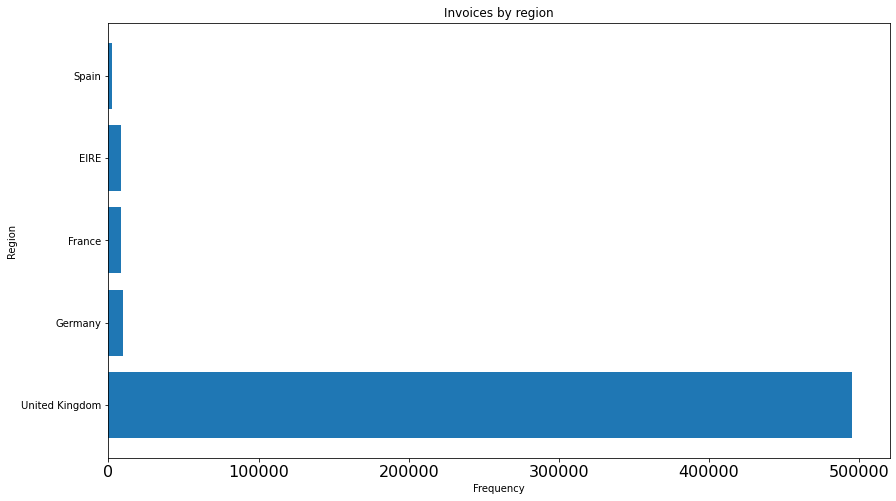

In [70]:
plt.figure(figsize=(14, 8))
plt.barh(trans_by_region.head().index, trans_by_region.head().values)
plt.title('Invoices by region')
plt.ylabel('Region')
plt.xlabel('Frequency')
#plt.xscale('log')
plt.xticks(fontsize=16)
plt.show()

## Como se ven las observaciones con region sin especificar?

In [55]:
df_online_retail[df_online_retail.region == 'Unspecified']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
152712,549687,20685,DOORMAT RED RETROSPOT,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152713,549687,22691,DOORMAT WELCOME SUNRISE,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152714,549687,48116,DOORMAT MULTICOLOUR STRIPE,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152715,549687,21213,PACK OF 72 SKULL CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152716,549687,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
...,...,...,...,...,...,...,...,...
498778,578539,22560,TRADITIONAL MODELLING CLAY,24,24/11/2020 14:55,1.25,NaN,Unspecified
498779,578539,23570,TRADITIONAL PICK UP STICKS GAME,12,24/11/2020 14:55,1.25,NaN,Unspecified
498780,578539,23571,TRADITIONAL NAUGHTS & CROSSES,12,24/11/2020 14:55,1.65,NaN,Unspecified
498781,578539,84992,72 SWEETHEART FAIRY CAKE CASES,24,24/11/2020 14:55,0.55,NaN,Unspecified


In [56]:
df_online_retail[df_online_retail.customer_id == 12363.0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
152712,549687,20685,DOORMAT RED RETROSPOT,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152713,549687,22691,DOORMAT WELCOME SUNRISE,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152714,549687,48116,DOORMAT MULTICOLOUR STRIPE,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152715,549687,21213,PACK OF 72 SKULL CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152716,549687,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152717,549687,21976,PACK OF 60 MUSHROOM CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152718,549687,21212,PACK OF 72 RETROSPOT CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152719,549687,84992,72 SWEETHEART FAIRY CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152720,549687,84991,60 TEATIME FAIRY CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152721,549687,21974,SET OF 36 PAISLEY FLOWER DOILIES,12,11/04/2020 13:29,1.45,12363.0,Unspecified


In [59]:
df_online_retail[df_online_retail.invoice_date == '11/04/2020 13:29']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
152712,549687,20685,DOORMAT RED RETROSPOT,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152713,549687,22691,DOORMAT WELCOME SUNRISE,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152714,549687,48116,DOORMAT MULTICOLOUR STRIPE,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152715,549687,21213,PACK OF 72 SKULL CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152716,549687,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152717,549687,21976,PACK OF 60 MUSHROOM CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152718,549687,21212,PACK OF 72 RETROSPOT CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152719,549687,84992,72 SWEETHEART FAIRY CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152720,549687,84991,60 TEATIME FAIRY CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152721,549687,21974,SET OF 36 PAISLEY FLOWER DOILIES,12,11/04/2020 13:29,1.45,12363.0,Unspecified


In [62]:
df_online_retail[df_online_retail.invoice_no == '549687']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
152712,549687,20685,DOORMAT RED RETROSPOT,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152713,549687,22691,DOORMAT WELCOME SUNRISE,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152714,549687,48116,DOORMAT MULTICOLOUR STRIPE,2,11/04/2020 13:29,7.95,12363.0,Unspecified
152715,549687,21213,PACK OF 72 SKULL CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152716,549687,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152717,549687,21976,PACK OF 60 MUSHROOM CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152718,549687,21212,PACK OF 72 RETROSPOT CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152719,549687,84992,72 SWEETHEART FAIRY CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152720,549687,84991,60 TEATIME FAIRY CAKE CASES,24,11/04/2020 13:29,0.55,12363.0,Unspecified
152721,549687,21974,SET OF 36 PAISLEY FLOWER DOILIES,12,11/04/2020 13:29,1.45,12363.0,Unspecified


- No hay paises que se repitan. 
- Usar ambas escalas, una lineal por default pero que puedan cambiar a escala logaritmica. 
- Limitar al top 5. 

# Explorar customer_id (valores ausentes)

In [66]:
df_customerid_nan = df_online_retail[df_online_retail.customer_id.isna()]
df_customerid_nan

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
622,536414,22139,NaN,56,01/12/2019 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,01/12/2019 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,01/12/2019 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,01/12/2019 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,01/12/2019 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,09/12/2020 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,09/12/2020 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,09/12/2020 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,09/12/2020 10:26,10.79,NaN,United Kingdom


In [71]:
df_customerid_nan.region.value_counts()

United Kingdom    133600
EIRE                 711
Hong Kong            288
Unspecified          202
Switzerland          125
France                66
Israel                47
Portugal              39
Bahrain                2
Name: region, dtype: int64

In [74]:
# Pasar la columna a tipo datetime
df_customerid_nan['invoice_date'] = pd.to_datetime(df_customerid_nan['invoice_date'])

C:\Users\esteb\AppData\Local\Temp/ipykernel_13088/1514992174.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_customerid_nan['invoice_date'] = pd.to_datetime(df_customerid_nan['invoice_date'])


In [78]:
december_dates = df_customerid_nan[df_customerid_nan['invoice_date'].dt.day != 12]
december_dates

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
26779,538524,10002,INFLATABLE POLITICAL GLOBE,2,2019-12-13 09:35:00,1.66,NaN,United Kingdom
26780,538524,10125,MINI FUNKY DESIGN TAPES,1,2019-12-13 09:35:00,1.66,NaN,United Kingdom
26781,538524,10135,COLOURING PENCILS BROWN TUBE,1,2019-12-13 09:35:00,2.51,NaN,United Kingdom
26782,538524,16235,RECYCLED PENCIL WITH RABBIT ERASER,6,2019-12-13 09:35:00,0.43,NaN,United Kingdom
26783,538524,17003,BROCADE RING PURSE,17,2019-12-13 09:35:00,0.43,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
515866,579787,21929,JUMBO BAG PINK VINTAGE PAISLEY,1,2020-11-30 15:33:00,4.13,NaN,United Kingdom
515867,579787,21930,JUMBO STORAGE BAG SKULLS,2,2020-11-30 15:33:00,4.13,NaN,United Kingdom
516171,579873,35819B,check,18,2020-11-30 17:00:00,0.00,NaN,United Kingdom
516188,579879,22759,check,17,2020-11-30 17:13:00,0.00,NaN,United Kingdom


Notas:
- Los valores ausentes no dependen de la region de la hora.

# Explorar description

In [74]:
df_online_retail.description.value_counts().index.str.lower()

Index(['white hanging heart t-light holder', 'regency cakestand 3 tier',
       'jumbo bag red retrospot', 'party bunting', 'lunch bag red retrospot',
       'assorted colour bird ornament', 'set of 3 cake tins pantry design ',
       'pack of 72 retrospot cake cases', 'lunch bag  black skull.',
       'natural slate heart chalkboard ',
       ...
       'lighthouse trading zero invc incorr', 'acrylic jewel snowflakepink',
       'tea time cake stand in gift box', 'white dove honeycomb paper garland',
       'keep out girls door hanger ', 'sold as set/6 by dotcom',
       'damages/dotcom?', 'on cargo order', 'opulent velvet set/3 candles',
       'show samples'],
      dtype='object', length=4214)

In [79]:
# Convertir NaN a 'Nothing'
df_online_retail.description.fillna('No description', inplace=True)

## Preprocesamiento de texto

In [80]:
# Descargar las stopwords en ingles para el preprocesamiento
nltk.download('stopwords')

# Función de preprocesamiento
def preprocesar_texto(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar números y caracteres especiales
    texto = re.sub(r'\d+', '', texto)
    texto = re.sub(r'[^\w\s]', '', texto)
    # Eliminar espacios en blanco adicionales
    texto = texto.strip()
    # Eliminar stopwords
    stop_words = set(stopwords.words('english'))
    texto = ' '.join([word for word in texto.split() if word not in stop_words])
    return texto

# Aplicar preprocesamiento a las descripciones
df_online_retail['clean_description'] = df_online_retail['description'].apply(preprocesar_texto)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\esteb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Análisis de frecuencia de palabras

In [101]:
# Unir todas las descripciones en un solo texto
texto_total = ' '.join(df_online_retail['clean_description'])

# Contar la frecuencia de las palabras
frecuencia_palabras = Counter(texto_total.split())

# Mostrar las 10 palabras más comunes
print(frecuencia_palabras.most_common(10))

[('set', 63845), ('bag', 51911), ('red', 42902), ('heart', 39163), ('retrospot', 35126), ('vintage', 33748), ('design', 30066), ('pink', 29526), ('christmas', 25131), ('box', 24469)]


## Nube de palabras

In [116]:
# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate('hola hola')

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

ValueError: Only supported for TrueType fonts

## Explorar los datos de la columna invoice_no

In [32]:
# Ver con que letra comienzan el codigo
df_online_retail.invoice_no.value_counts().sort_index()

536365      7
536366      2
536367     12
536368      4
536369      1
           ..
C581484     1
C581490     2
C581499     1
C581568     1
C581569     2
Name: invoice_no, Length: 25900, dtype: int64

In [34]:
# Filtrar los datos que comiencen con la letra C
filtro = df_online_retail.invoice_no.str.startswith('C')
df_online_retail[filtro]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
141,C536379,D,Discount,-1,01/12/2019 09:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,01/12/2019 09:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,01/12/2019 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,01/12/2019 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,01/12/2019 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,09/12/2020 09:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,09/12/2020 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,09/12/2020 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,09/12/2020 11:58,1.25,17315.0,United Kingdom


In [61]:
df_online_retail[df_online_retail.customer_id == 15311.0].sort_values('invoice_date').head(20)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
78331,C542866,85063,CREAM SWEETHEART MAGAZINE RACK,-2,01/02/2020 12:14,14.95,15311.0,United Kingdom
78332,C542866,35004G,SET OF 3 GOLD FLYING DUCKS,-2,01/02/2020 12:14,1.95,15311.0,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,01/02/2020 12:14,4.65,15311.0,United Kingdom
78530,542890,22087,PAPER BUNTING WHITE LACE,40,01/02/2020 13:25,2.55,15311.0,United Kingdom
78588,542890,22276,WASH BAG VINTAGE ROSE PAISLEY,2,01/02/2020 13:25,2.55,15311.0,United Kingdom
78587,542890,22278,OVERNIGHT BAG VINTAGE ROSE PAISLEY,2,01/02/2020 13:25,4.95,15311.0,United Kingdom
78586,542890,82583,HOT BATHS METAL SIGN,5,01/02/2020 13:25,2.10,15311.0,United Kingdom
78585,542890,82567,AIRLINE LOUNGEMETAL SIGN,3,01/02/2020 13:25,2.10,15311.0,United Kingdom
78584,542890,82581,TOILET METAL SIGN,5,01/02/2020 13:25,0.55,15311.0,United Kingdom
78583,542890,21169,YOU'RE CONFUSING ME METAL SIGN,5,01/02/2020 13:25,1.69,15311.0,United Kingdom


In [56]:
df_online_retail[filtro].description.head(20)

141                                Discount
154         SET OF 3 COLOURED  FLYING DUCKS
235          PLASTERS IN TIN CIRCUS PARADE 
236        PACK OF 12 PINK PAISLEY TISSUES 
237        PACK OF 12 BLUE PAISLEY TISSUES 
238       PACK OF 12 RED RETROSPOT TISSUES 
239             CHICK GREY HOT WATER BOTTLE
240        PLASTERS IN TIN VINTAGE PAISLEY 
241                  PLASTERS IN TIN SKULLS
939                JAM MAKING SET WITH JARS
1441              HAND WARMER RED RETROSPOT
1442              CHARLOTTE BAG SUKI DESIGN
1973             3 HOOK HANGER MAGIC GARDEN
1974          5 HOOK HANGER MAGIC TOADSTOOL
1975    SET/5 RED RETROSPOT LID GLASS BOWLS
1976      SET OF SALT AND PEPPER TOADSTOOLS
1977                     DELUXE SEWING KIT 
1978            TRIPLE PHOTO FRAME CORNICE 
1979      RETROSPOT PARTY BAG + STICKER SET
1980             HOOK 1 HANGER MAGIC GARDEN
Name: description, dtype: object

In [36]:
df_online_retail[filtro].quantity.max()

-1

In [54]:
df_online_retail[~filtro][df_online_retail[~filtro].quantity < 0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
2406,536589,21777,NaN,-10,01/12/2019 16:50,0.0,NaN,United Kingdom
4347,536764,84952C,NaN,-38,02/12/2019 14:42,0.0,NaN,United Kingdom
7188,536996,22712,NaN,-20,03/12/2019 15:30,0.0,NaN,United Kingdom
7189,536997,22028,NaN,-20,03/12/2019 15:30,0.0,NaN,United Kingdom
7190,536998,85067,NaN,-6,03/12/2019 15:30,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535333,581210,23395,check,-26,07/12/2020 18:36,0.0,NaN,United Kingdom
535335,581212,22578,lost,-1050,07/12/2020 18:38,0.0,NaN,United Kingdom
535336,581213,22576,check,-30,07/12/2020 18:38,0.0,NaN,United Kingdom
536908,581226,23090,missing,-338,08/12/2020 09:56,0.0,NaN,United Kingdom


Nota:
- Se encontro un valor con una C antes del número. Probablemente es un error. Se eliminara la C. 

### Eliminar los errores tipograficos

## Cambiar el tipo de datos de las columnas

In [24]:
df_online_retail.invoice_no = df_online_retail.invoice_no.astype(int)
df_online_retail.customer_id = df_online_retail.customer_id.astype(int)

ValueError: invalid literal for int() with base 10: 'C536379'

# Quantity (valores negativos)

In [21]:
df_online_retail[df_online_retail['quantity']<0].head(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
141,C536379,D,Discount,-1,01/12/2019 09:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,01/12/2019 09:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,01/12/2019 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,01/12/2019 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,01/12/2019 10:24,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,01/12/2019 10:24,0.29,17548.0,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,01/12/2019 10:24,3.45,17548.0,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,01/12/2019 10:24,1.65,17548.0,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,01/12/2019 10:24,1.65,17548.0,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,01/12/2019 12:38,4.25,17897.0,United Kingdom
